# Pitchfork Analysis - Aggregate Album Data Analysis
## Load Libraries & Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

from scipy.stats import mannwhitneyu
from scipy.stats import zscore

import re

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 3000)

In [2]:
top_album_songs = pd.read_csv('top_album_songs.csv', index_col=False)
bottom_album_songs = pd.read_csv('bottom_album_songs.csv', index_col=False)

In [3]:
genre_cols = ['electronic', 'experimental', 'folk/country', 'global', 'jazz', 'metal', 
              'pop/r&b', 'rap', 'rock', 'unknown']

numeric_cols = ['song_duration', 'acousticness', 'danceability', 'energy', 'instrumentalness',
                'liveness', 'speechiness', 'tempo', 'valence', 'popularity']

cat_cols = ['key', 'time_signature', 'song_explicit', 'mode']

In [4]:
top_album_songs['number_of_genres'] = top_album_songs['electronic'] + top_album_songs['experimental'] + top_album_songs['folk/country'] + top_album_songs['global'] + top_album_songs['jazz'] + top_album_songs['metal'] + top_album_songs['pop/r&b'] + top_album_songs['rap'] + top_album_songs['rock'] + top_album_songs['unknown']
bottom_album_songs['number_of_genres'] = bottom_album_songs['electronic'] + bottom_album_songs['experimental'] + bottom_album_songs['folk/country'] + bottom_album_songs['global'] + bottom_album_songs['jazz'] + bottom_album_songs['metal'] + bottom_album_songs['pop/r&b'] + bottom_album_songs['rap'] + bottom_album_songs['rock'] + bottom_album_songs['unknown']

In [5]:
top_album_songs['score'].mean()

8.842022160663992

In [6]:
bottom_album_songs['score'].mean()

4.191729690168326

In [7]:
len(top_album_songs)

25270

In [8]:
len(bottom_album_songs)

20495

In [9]:
def plot_numeric_col(col, upper_df, lower_df, title=None, axis=None, x_limit=None, show_outliers=True, 
                     save=False, save_title=None, x_label = ''):
    top_df = upper_df.loc[:, [col]]
    top_df['album_category'] = 'Top 10%'
    bottom_df = lower_df.loc[:, [col]]
    bottom_df['album_category'] = 'Bottom 10%'
    combined_df = pd.concat([top_df, bottom_df])
    
    if axis != None:
        sns.boxplot(data=combined_df, y='album_category', x=col, ax=axis, showfliers=show_outliers)
        axis.set_xlabel(x_label, fontsize=12)
        axis.set_ylabel('')
        axis.tick_params(axis='both', which='major', labelsize=12)
        axis.set_title(title, fontsize=12)
        if x_limit != None:
            axis.set_xlim(0, x_limit)
        axis.xaxis.get_offset_text().set_fontsize(12)
            
    else:
        fig, ax = plt.subplots(figsize=(18,8))
        sns.boxplot(data=combined_df, y='album_category', x=col, showfliers=show_outliers)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('') 
        ax.tick_params(axis='both', which='major', labelsize=12)
        if x_limit != None:
            ax.set_xlim(0, x_limit)
        ax.xaxis.get_offset_text().set_fontsize(12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=12)
    if save:
        plt.savefig('images/' + save_title)

In [10]:
def plot_numeric_grid(num_var, upper_df, lower_df, title, x_limit=None, show_outliers=True, x_label=''):
    fig, axs = plt.subplots(5,2, figsize=(14,18))
    genre_counter = 0

    for row in range(5):
        for col in range(2):
            genre = genre_cols[genre_counter]
            top_genre_df = upper_df.loc[upper_df[genre] == 1]
            bottom_genre_df = lower_df.loc[lower_df[genre] == 1]
            plot_numeric_col(num_var, top_genre_df, bottom_genre_df, 
                             title=genre, axis=axs[row,col], x_limit=x_limit, 
                             show_outliers=show_outliers, x_label=x_label)
            genre_counter += 1
    
    fig.tight_layout(pad=3, rect=[0, 0.03, 1, 0.97])
    plt.suptitle(title, fontsize=12)

In [11]:
def plot_histogram(num_var, upper_df, lower_df, title, save=False, save_title=None):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.distplot(upper_df[num_var], norm_hist=False, kde=False, label='Top 10%')
    sns.distplot(lower_df[num_var], norm_hist=False, kde=False, label='Bottom 10%')
    plt.ylabel('# of Songs')
    plt.legend(loc='upper left')
    plt.title(title)
    if save:
        plt.savefig('images/' + save_title)
    plt.show()

In [12]:
def var_comparison(num_var, upper_df, lower_df):
    u_value, p_value = mannwhitneyu(upper_df[num_var], lower_df[num_var])
    
    p_value = round(p_value, 3)

    # Calculate common langauge effect size
    com_lang_eff_size = round(u_value / (len(upper_df)*len(lower_df)), 3)
    
    top_quantiles = upper_df[num_var].quantile([0.25, 0.5, 0.75])
    bottom_quantiles = lower_df[num_var].quantile([0.25, 0.5, 0.75])
    
    top_outliers = len(np.where(np.abs(zscore(upper_df[num_var]) > 3))[0])
    bottom_outliers = len(np.where(np.abs(zscore(lower_df[num_var]) > 3))[0])
    
#     top_med_quar = str(top_quantiles[0.5]) + ' [' + str(top_quantiles[0.25]) + ' - ' + str(top_quantiles[0.75]) + ']'
#     bottom_med_quar = str(bottom_quantiles[0.5]) + ' [' + str(bottom_quantiles[0.25]) + ' - ' + str(bottom_quantiles[0.75]) + ']' 

    sig_value = False
    if p_value < 0.05:
        sig_value = True
    
    print('N1 (Top 10%):', len(upper_df))
    print('N2 (Bottom 10%):', len(lower_df))
    print('U-value: ', u_value)
    print('p-value: ', p_value)
    print('Significant: ', sig_value)
    print('Common Language Effect Size: ', com_lang_eff_size)
    print('Top 10% Median: ', top_quantiles[0.5])
    print('Bottom 10% Median: ', bottom_quantiles[0.5])
    print('Number of Outliers (Top 10%): ', top_outliers)
    print('Number of Outliers (Bottom 10%): ', bottom_outliers)

In [13]:
def color_sig_green(s, column):
    is_sig = pd.Series(data=False, index=s.index) 
    is_sig[column] = s.loc[column]
    return ['background-color: honeydew' if is_sig.any() else 'background-color: mistyrose' for v in is_sig]

def genre_comparison(num_var, upper_df, lower_df, caption_text=''):
    return_df = pd.DataFrame(columns=['Genre', 'Top 10% Count', 'Bottom 10% Count', 'U', 'p', 
                                      'Sig?', 'CL', 'Top 10% Median', 
                                      'Bottom 10% Median', 'Top 10% Outliers', 'Bottom 10% Outliers'])
    
    for genre_index in range(len(genre_cols)):
        genre = genre_cols[genre_index]
        top_genre_df = upper_df.loc[upper_df[genre] == 1]
        bottom_genre_df = lower_df.loc[lower_df[genre] == 1]
        
        u_value, p_value = mannwhitneyu(top_genre_df[num_var], bottom_genre_df[num_var])
        
        # Calculate common langauge effect size
        com_lang_eff_size = u_value / (len(top_genre_df)*len(bottom_genre_df))
        
        top_quantiles = top_genre_df[num_var].quantile([0.25, 0.5, 0.75])
        bottom_quantiles = bottom_genre_df[num_var].quantile([0.25, 0.5, 0.75])
        
        top_outliers = len(np.where(np.abs(zscore(top_genre_df[num_var]) > 3))[0])
        bottom_outliers = len(np.where(np.abs(zscore(bottom_genre_df[num_var]) > 3))[0])
        
#         top_med_quar = str(top_quantiles[0.5]) + ' [' + str(top_quantiles[0.25]) + ' - ' + str(top_quantiles[0.75]) + ']'
#         bottom_med_quar = str(bottom_quantiles[0.5]) + ' [' + str(bottom_quantiles[0.25]) + ' - ' + str(bottom_quantiles[0.75]) + ']'
    
        sig_value = False
        if p_value < 0.05:
            sig_value = True
            
              
        return_df.loc[len(return_df)] = [genre, len(top_genre_df), len(bottom_genre_df), u_value.astype(np.int64), 
                                         p_value, sig_value, 
                                         '{:.3f}'.format(round(com_lang_eff_size, 3)), 
                                         '{:.2f}'.format(round(top_quantiles[0.5], 2)), 
                                         '{:.2f}'.format(round(bottom_quantiles[0.5], 2)),
                                         top_outliers, bottom_outliers]

    caption_props = [('text-align', 'center'), ('font-size', '125%')]
        
    return return_df.style.apply(color_sig_green, column='Sig?', axis=1).\
                     set_caption(caption_text).\
                     set_table_styles([dict(selector='caption', props=caption_props)])
    

## Song Lyrics

In [193]:
print('% Lyrics Not Found: ', len(top_album_songs[top_album_songs['song_lyrics'] == 'lyrics not found']) / len(top_album_songs) * 100)

% Lyrics Not Found:  34.772457459438066


In [194]:
print('% Lyrics Not Found: ', len(bottom_album_songs[bottom_album_songs['song_lyrics'] == 'lyrics not found']) / len(bottom_album_songs) * 100)

% Lyrics Not Found:  36.72603073920469


In [16]:
def clean_text(text_input, remove_lines=True):
    text_input = text_input.lower()
    if remove_lines:
        text_input = re.sub('\n', ' ', text_input)
    else:
        text_input = re.sub('\n', 'QZQ', text_input)
    text_input = re.sub(r'\([^)]*\)', '', text_input).strip()
    text_input = re.sub("[\(\[].*?[\)\]]", "", text_input).strip()
    text_input = re.sub(' & ', ' and ', text_input)
    text_input = re.sub('-', ' ', text_input)
    text_input = re.sub("[,.']", '', text_input)
    text_input = re.sub(' +', ' ', text_input)
    text_input = re.sub('"', '', text_input)
    text_input = re.sub('!', '', text_input)
    text_input = re.sub(':', '', text_input)
    text_input = re.sub('/', ' ', text_input)
    text_input = re.sub(r'[^0-9A-Za-z ]', '', text_input)
    if not remove_lines:
        text_input = re.sub('QZQ', '\n', text_input)
    text_input = text_input.strip()

    return text_input

In [17]:
def count_lines(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text, remove_lines=False)
        return len(lyric_text.split('\n'))

In [18]:
def count_words(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text)
        return len(lyric_text.split(' '))

In [19]:
def count_unique_words(lyric_text):
    if lyric_text == 'lyrics not found':
        return 0
    else:
        lyric_text = clean_text(lyric_text)
        return len(set(lyric_text.split(' ')))

In [20]:
top_album_songs['lyric_lines'] = top_album_songs['song_lyrics'].apply(count_lines)
bottom_album_songs['lyric_lines'] = bottom_album_songs['song_lyrics'].apply(count_lines)

top_album_songs['lyric_words'] = top_album_songs['song_lyrics'].apply(count_words)
bottom_album_songs['lyric_words'] = bottom_album_songs['song_lyrics'].apply(count_words)

top_album_songs['lyric_unique_words'] = top_album_songs['song_lyrics'].apply(count_unique_words)
bottom_album_songs['lyric_unique_words'] = bottom_album_songs['song_lyrics'].apply(count_unique_words)

top_album_songs['words_per_line'] = top_album_songs['lyric_words'] / top_album_songs['lyric_lines']
bottom_album_songs['words_per_line'] = bottom_album_songs['lyric_words'] / bottom_album_songs['lyric_lines']

## Aggregate Album Data

In [21]:
top_album_songs = top_album_songs.fillna(0)
bottom_album_songs = bottom_album_songs.fillna(0)

In [22]:
top_album_mean = top_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).mean()
top_album_df = top_album_mean[genre_cols]
top_album_mean_cols = [x + '_mean' for x in top_album_mean.columns]
top_album_mean.columns = top_album_mean_cols

bottom_album_mean = bottom_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).mean()
bottom_album_df = bottom_album_mean[genre_cols]
bottom_album_mean_cols = [x + '_mean' for x in bottom_album_mean.columns]
bottom_album_mean.columns = bottom_album_mean_cols

mean_cols = ['score_mean', 'song_duration_mean', 'song_explicit_mean', 'acousticness_mean', 'danceability_mean',  
             'energy_mean', 'mode_mean', 'instrumentalness_mean', 'liveness_mean', 'speechiness_mean', 
             'tempo_mean', 'valence_mean', 'popularity_mean', 'lyric_lines_mean', 'lyric_words_mean', 
             'lyric_unique_words_mean', 'words_per_line_mean']

top_album_df = pd.concat([top_album_df, top_album_mean[mean_cols]], axis=1)
bottom_album_df = pd.concat([bottom_album_df, bottom_album_mean[mean_cols]], axis=1)

In [23]:
top_album_var = top_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).var()
top_album_var_cols = [x + '_var' for x in top_album_var.columns]
top_album_var.columns = top_album_var_cols

bottom_album_var = bottom_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).var()
bottom_album_var_cols = [x + '_var' for x in bottom_album_var.columns]
bottom_album_var.columns = bottom_album_var_cols

var_cols = ['song_duration_var', 'song_explicit_var', 'acousticness_var', 'danceability_var', 'energy_var', 
            'mode_var', 'time_signature_var', 'instrumentalness_var', 'liveness_var', 'speechiness_var', 
            'tempo_var', 'valence_var', 'popularity_var', 'lyric_lines_var', 'lyric_words_var',
            'lyric_unique_words_var', 'words_per_line_var']

top_album_df = pd.concat([top_album_df, top_album_var[var_cols]], axis=1)
bottom_album_df = pd.concat([bottom_album_df, bottom_album_var[var_cols]], axis=1)

In [24]:
top_album_max = top_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).count()
top_album_max_cols = [x + '_count' for x in top_album_max.columns]
top_album_max.columns = top_album_max_cols

bottom_album_max = bottom_album_songs.groupby(['reviewid', 'artist_name', 'album_title']).count()
bottom_album_max_cols = [x + '_count' for x in bottom_album_max.columns]
bottom_album_max.columns = bottom_album_max_cols

max_cols = ['song_track_number_count']

top_album_df = pd.concat([top_album_df, top_album_max[max_cols]], axis=1)
bottom_album_df = pd.concat([bottom_album_df, bottom_album_max[max_cols]], axis=1)

In [25]:
top_album_df = top_album_df.fillna(0)
bottom_album_df = bottom_album_df.fillna(0)

### Song Duration
#### Mean

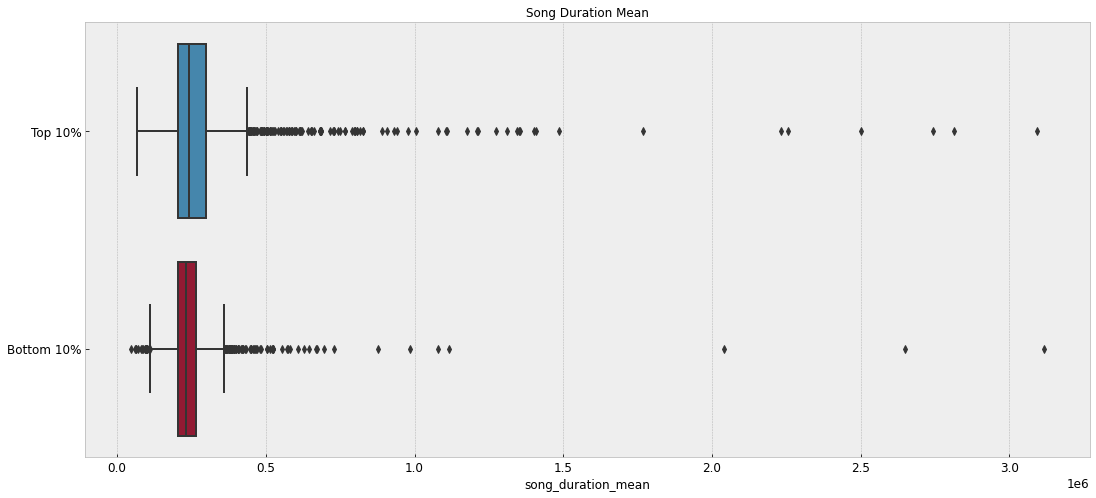

In [26]:
plot_numeric_col('song_duration_mean', top_album_df, bottom_album_df, 'Song Duration Mean')

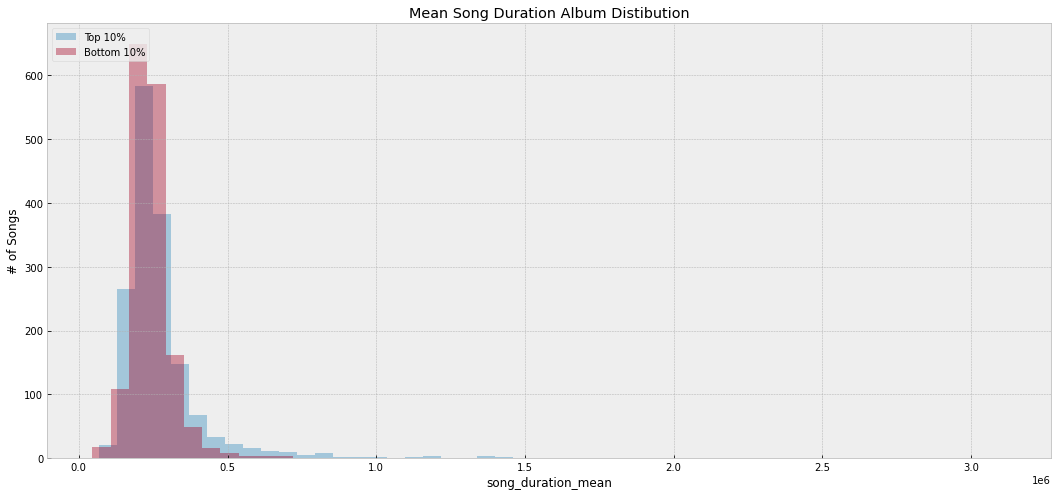

In [27]:
plot_histogram('song_duration_mean', top_album_df, bottom_album_df, 'Mean Song Duration Album Distibution')

In [28]:
var_comparison('song_duration_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1149767.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.444
Top 10% Median:  243050.63461538462
Bottom 10% Median:  232520.4238095238
Number of Outliers (Top 10%):  25
Number of Outliers (Bottom 10%):  12


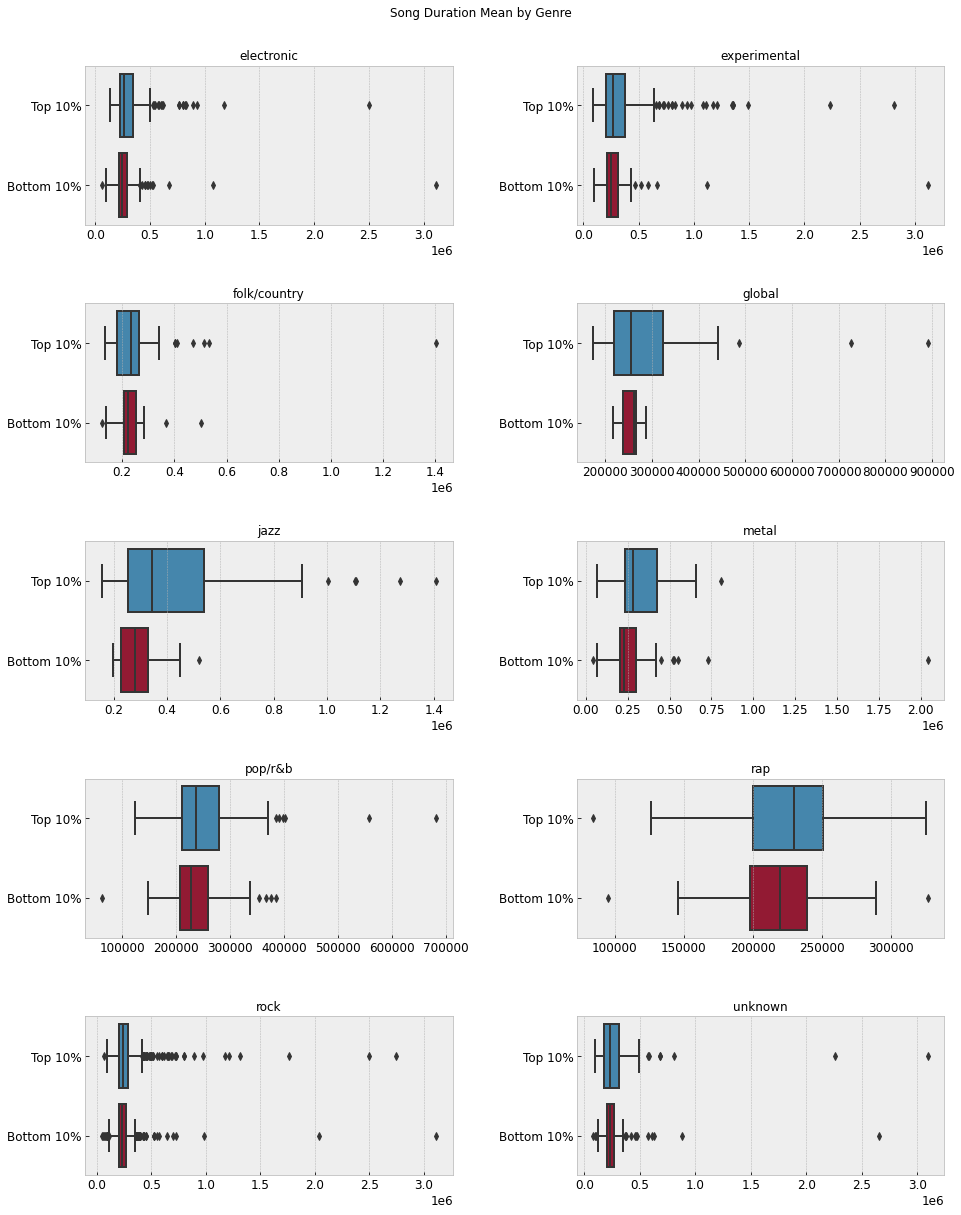

In [29]:
plot_numeric_grid('song_duration_mean', top_album_df, bottom_album_df, 'Song Duration Mean by Genre')

In [30]:
song_duration_mean_df = genre_comparison('song_duration_mean', top_album_df, bottom_album_df)
song_duration_mean_df

#### Variance

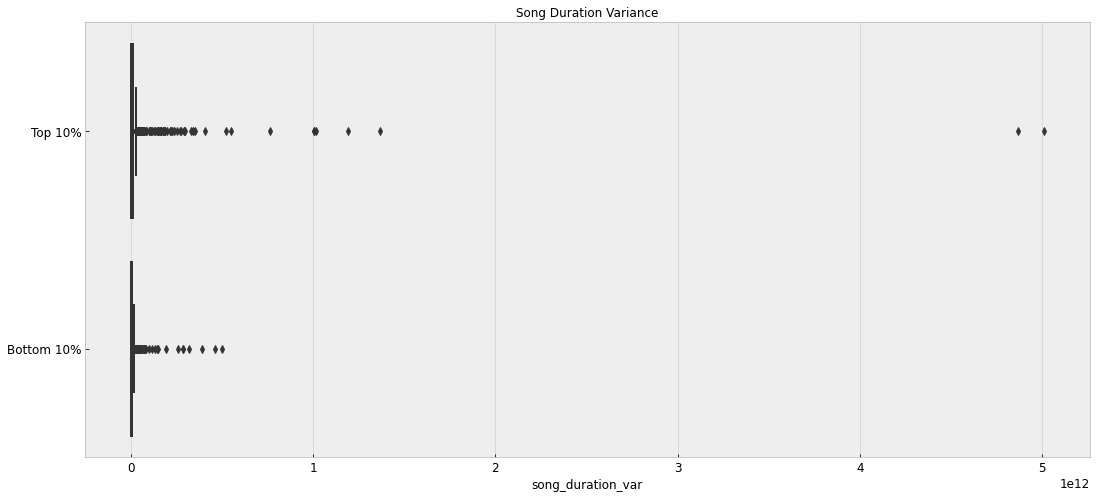

In [31]:
plot_numeric_col('song_duration_var', top_album_df, bottom_album_df, 'Song Duration Variance')

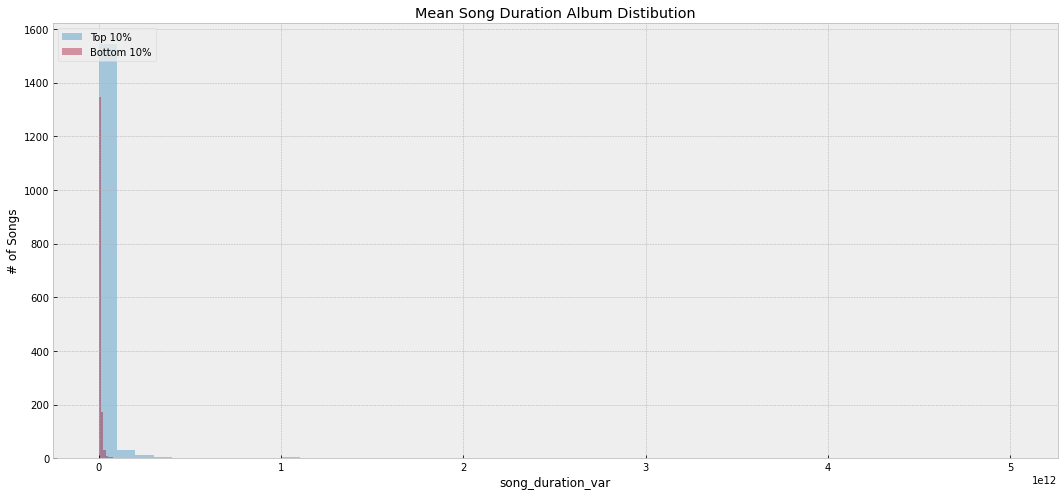

In [32]:
plot_histogram('song_duration_var', top_album_df, bottom_album_df, 'Mean Song Duration Album Distibution')

In [33]:
var_comparison('song_duration_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  997754.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.385
Top 10% Median:  5620427703.953297
Bottom 10% Median:  3359197726.8701396
Number of Outliers (Top 10%):  8
Number of Outliers (Bottom 10%):  13


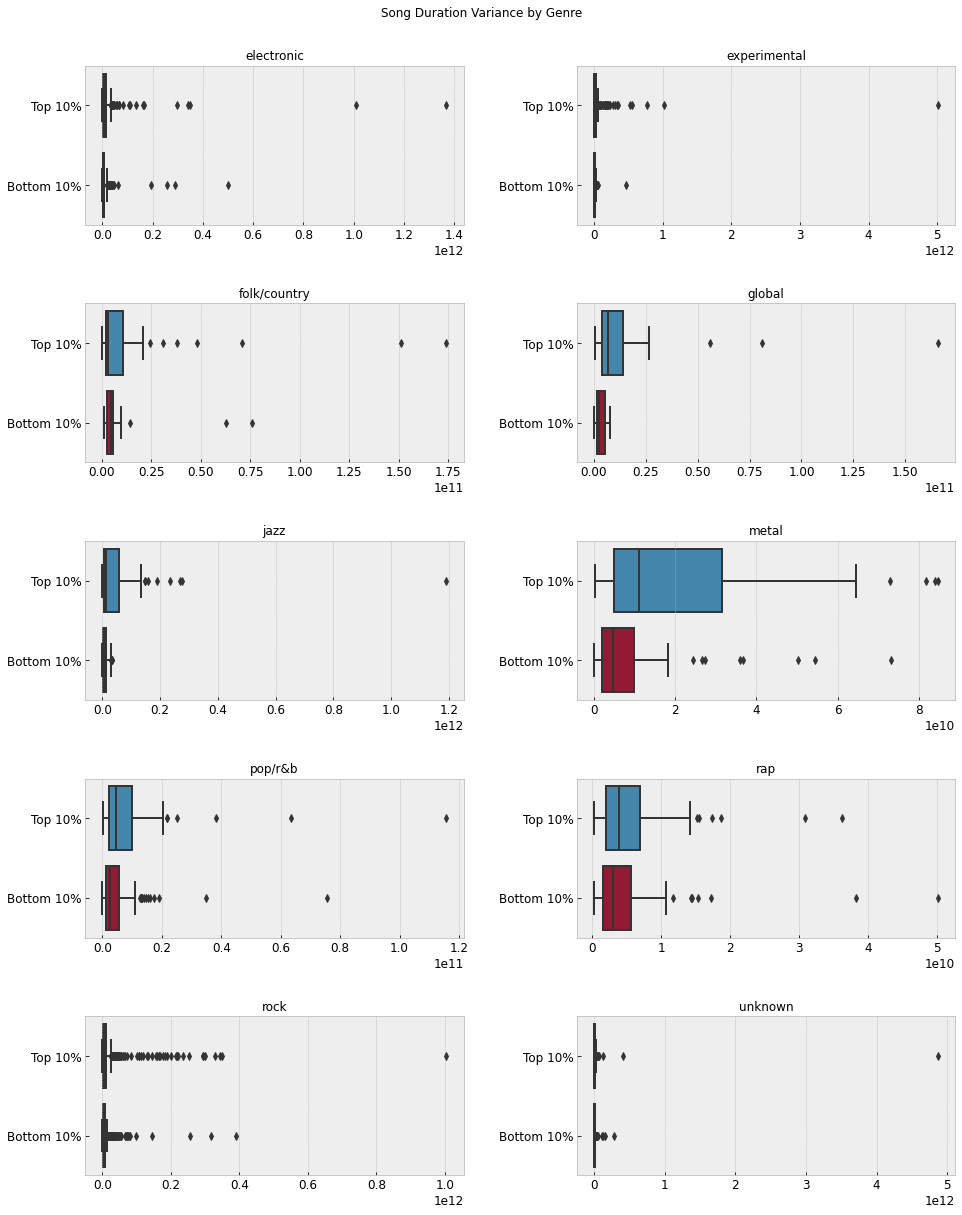

In [34]:
plot_numeric_grid('song_duration_var', top_album_df, bottom_album_df, 'Song Duration Variance by Genre')

In [35]:
song_duration_var_df = genre_comparison('song_duration_var', top_album_df, bottom_album_df)
song_duration_var_df

### Explicit Lyrics
#### Mean

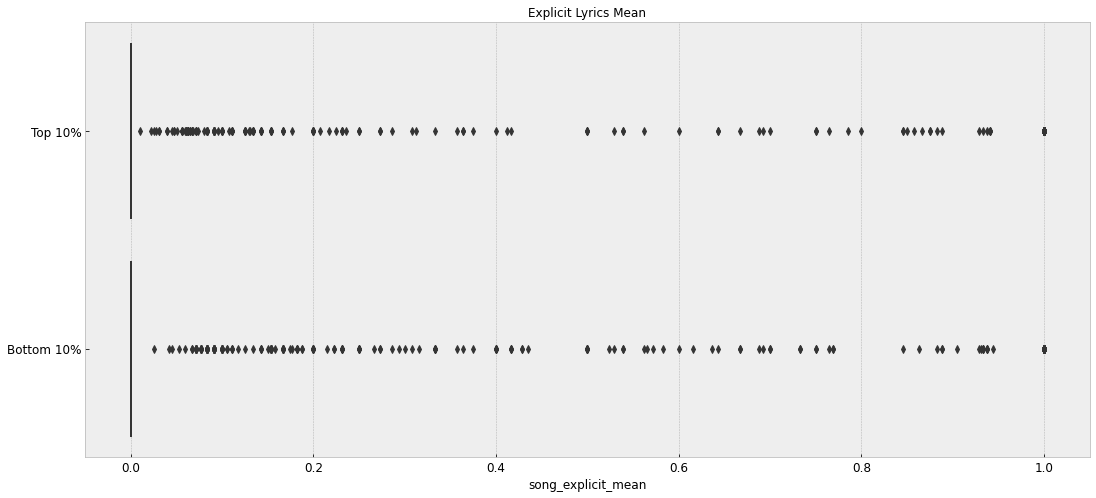

In [36]:
plot_numeric_col('song_explicit_mean', top_album_df, bottom_album_df, 'Explicit Lyrics Mean')

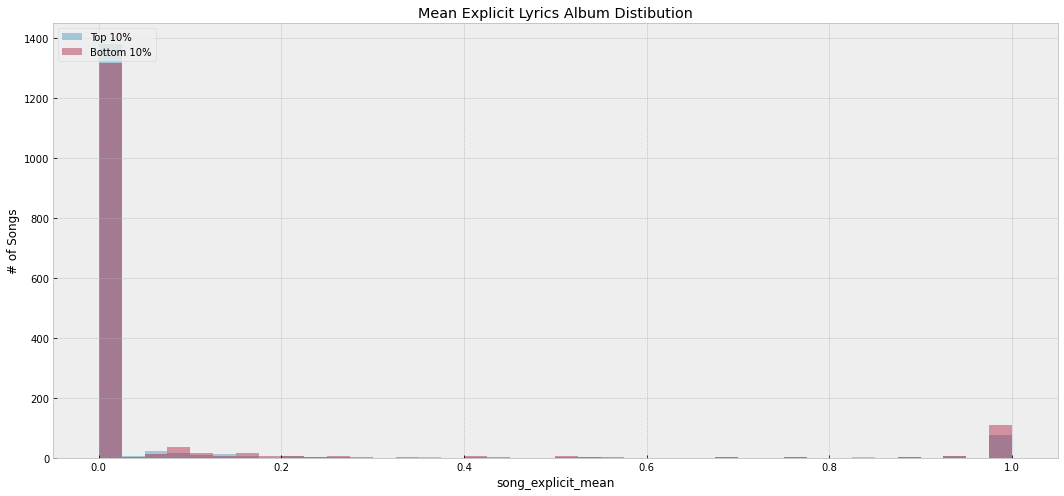

In [37]:
plot_histogram('song_explicit_mean', top_album_df, bottom_album_df, 'Mean Explicit Lyrics Album Distibution')

In [38]:
var_comparison('song_explicit_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1232719.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.476
Top 10% Median:  0.0
Bottom 10% Median:  0.0
Number of Outliers (Top 10%):  94
Number of Outliers (Bottom 10%):  116


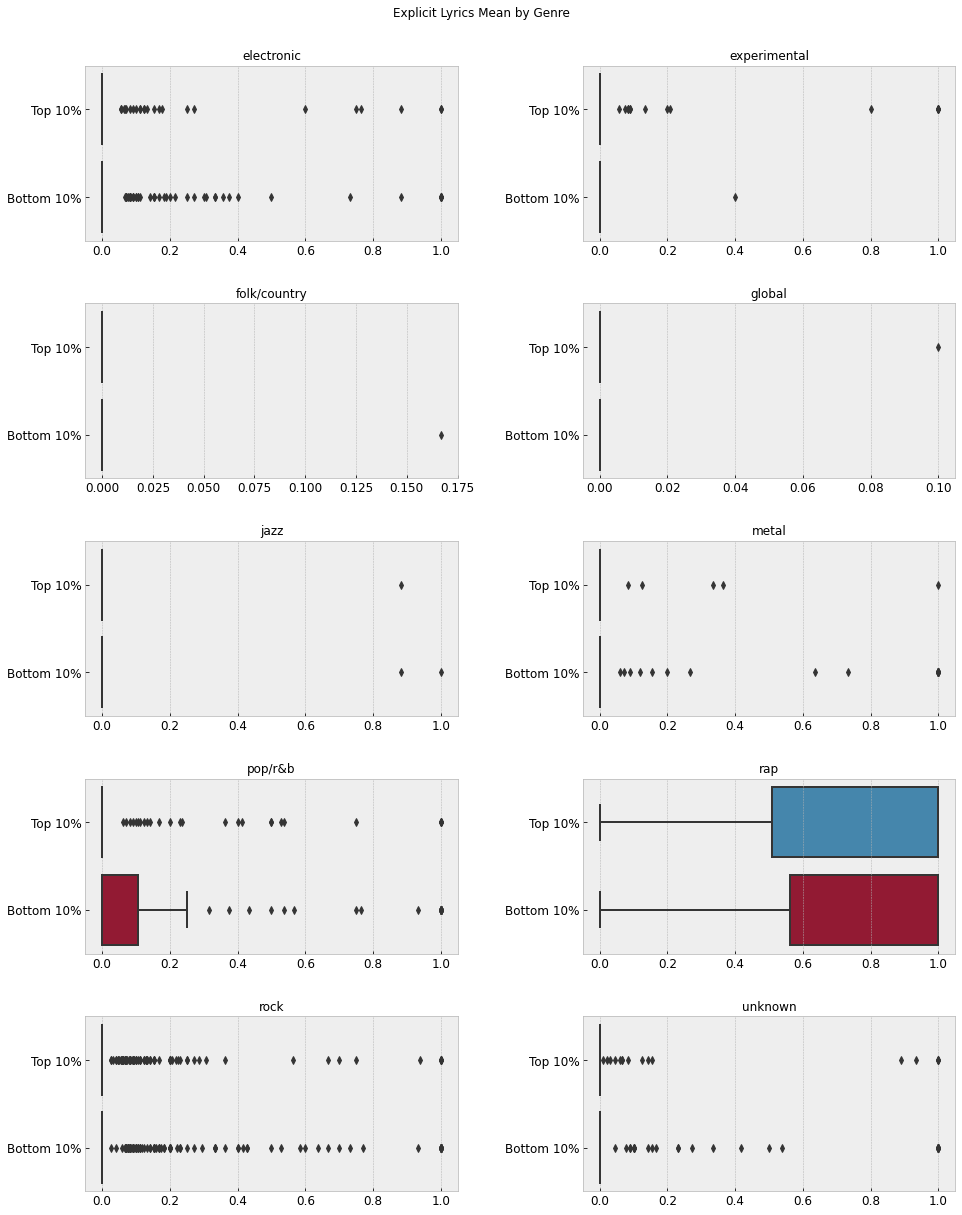

In [39]:
plot_numeric_grid('song_explicit_mean', top_album_df, bottom_album_df, 'Explicit Lyrics Mean by Genre')

In [40]:
song_explicit_mean_df = genre_comparison('song_explicit_mean', top_album_df, bottom_album_df)
song_explicit_mean_df

/Users/scottduda/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


#### Variance

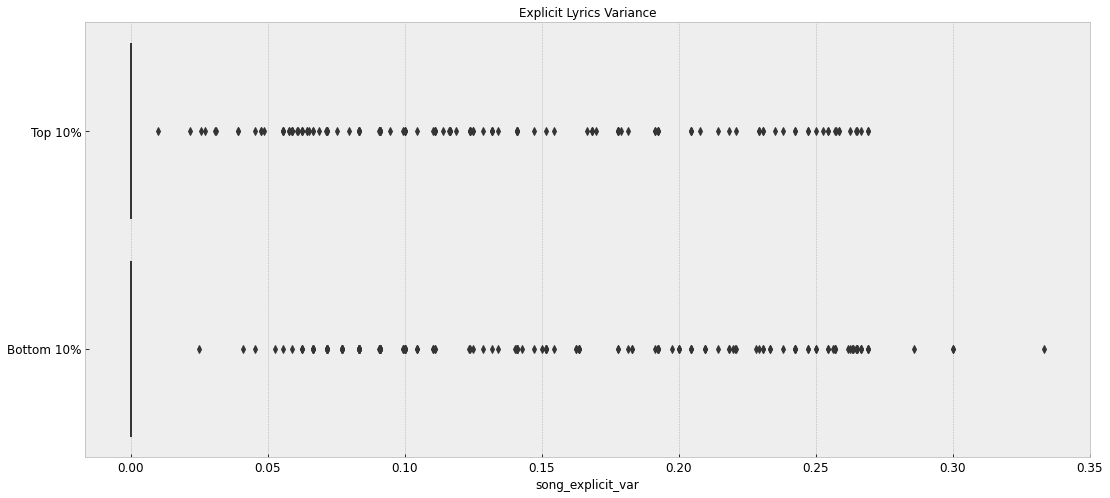

In [41]:
plot_numeric_col('song_explicit_var', top_album_df, bottom_album_df, 'Explicit Lyrics Variance')

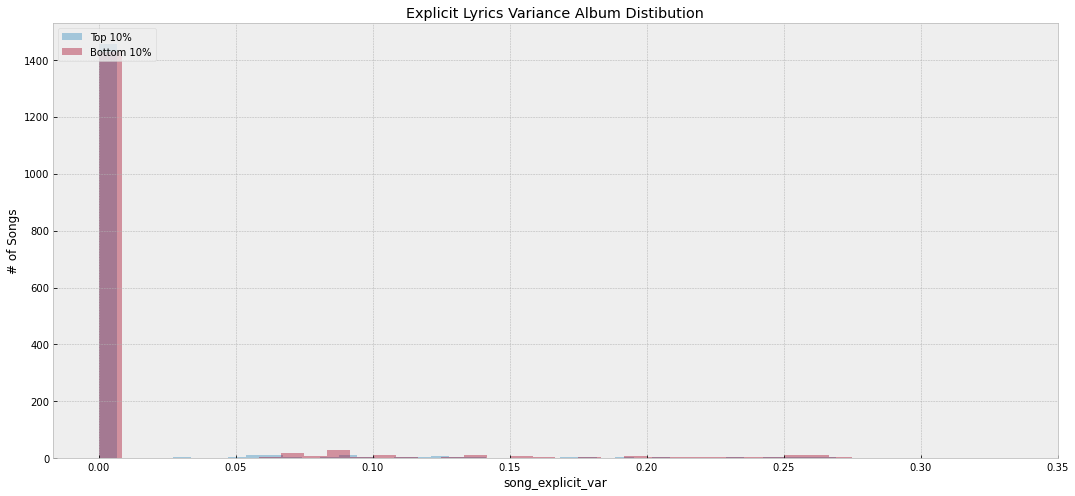

In [42]:
plot_histogram('song_explicit_var', top_album_df, bottom_album_df, 'Explicit Lyrics Variance Album Distibution')

In [43]:
var_comparison('song_explicit_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1259476.0
p-value:  0.006
Significant:  True
Common Language Effect Size:  0.487
Top 10% Median:  0.0
Bottom 10% Median:  0.0
Number of Outliers (Top 10%):  50
Number of Outliers (Bottom 10%):  68


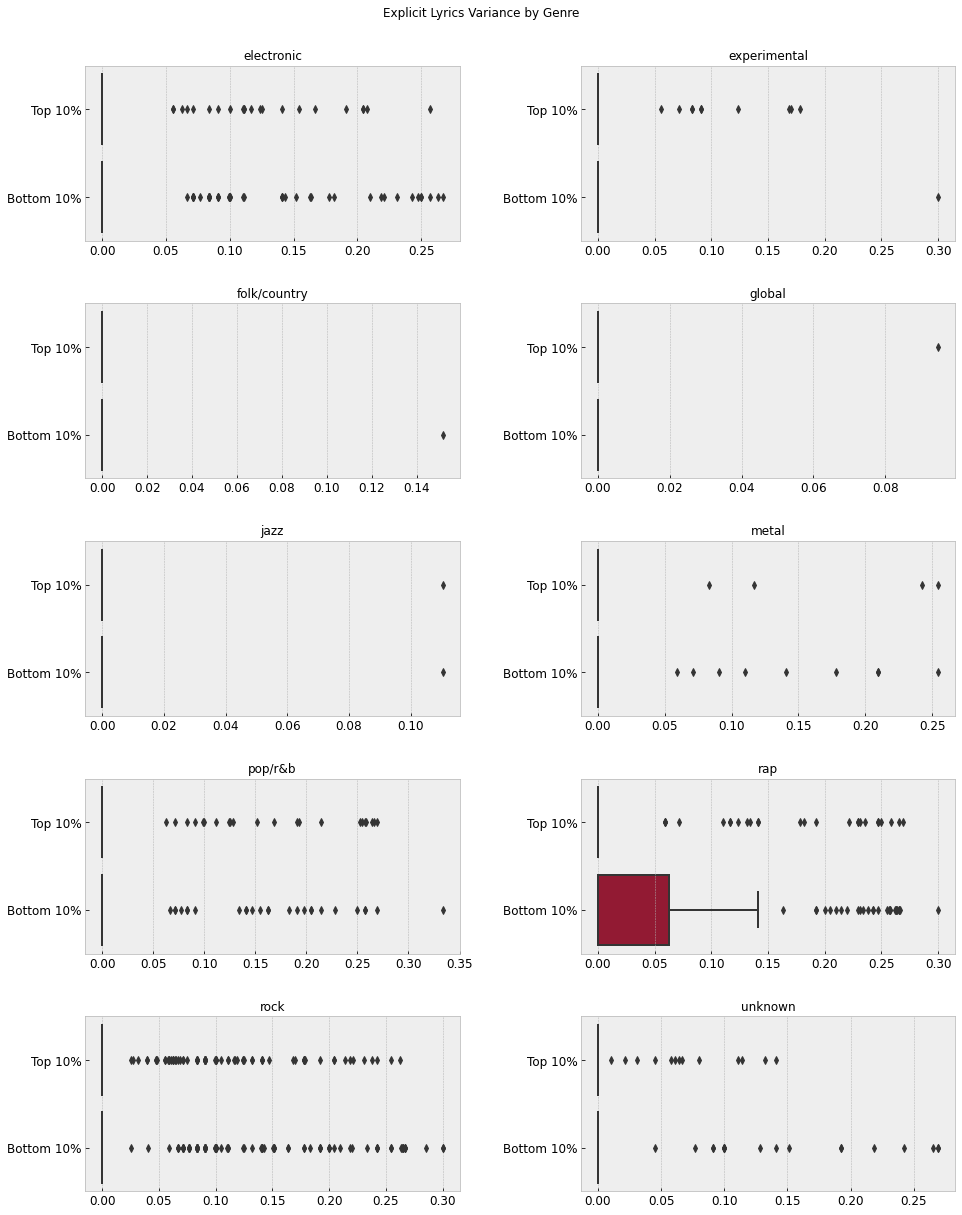

In [44]:
plot_numeric_grid('song_explicit_var', top_album_df, bottom_album_df, 'Explicit Lyrics Variance by Genre')

In [45]:
song_explict_var_df = genre_comparison('song_explicit_var', top_album_df, bottom_album_df)
song_explict_var_df

/Users/scottduda/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/scottduda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


### Acousticness
#### Mean

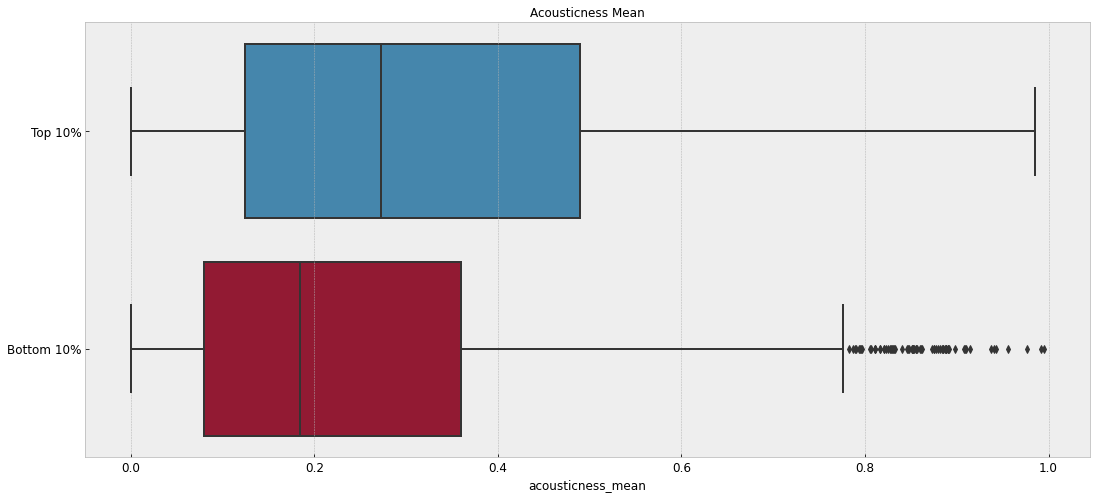

In [46]:
plot_numeric_col('acousticness_mean', top_album_df, bottom_album_df, 'Acousticness Mean')

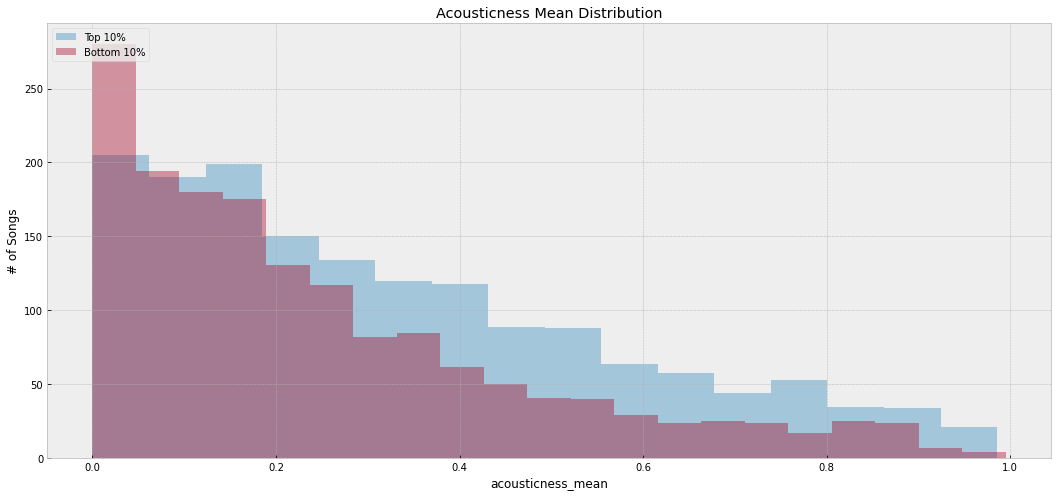

In [47]:
plot_histogram('acousticness_mean', top_album_df, bottom_album_df, title='Acousticness Mean Distribution')

In [48]:
var_comparison('acousticness_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1046694.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.404
Top 10% Median:  0.2720990625
Bottom 10% Median:  0.18420664335664338
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  7


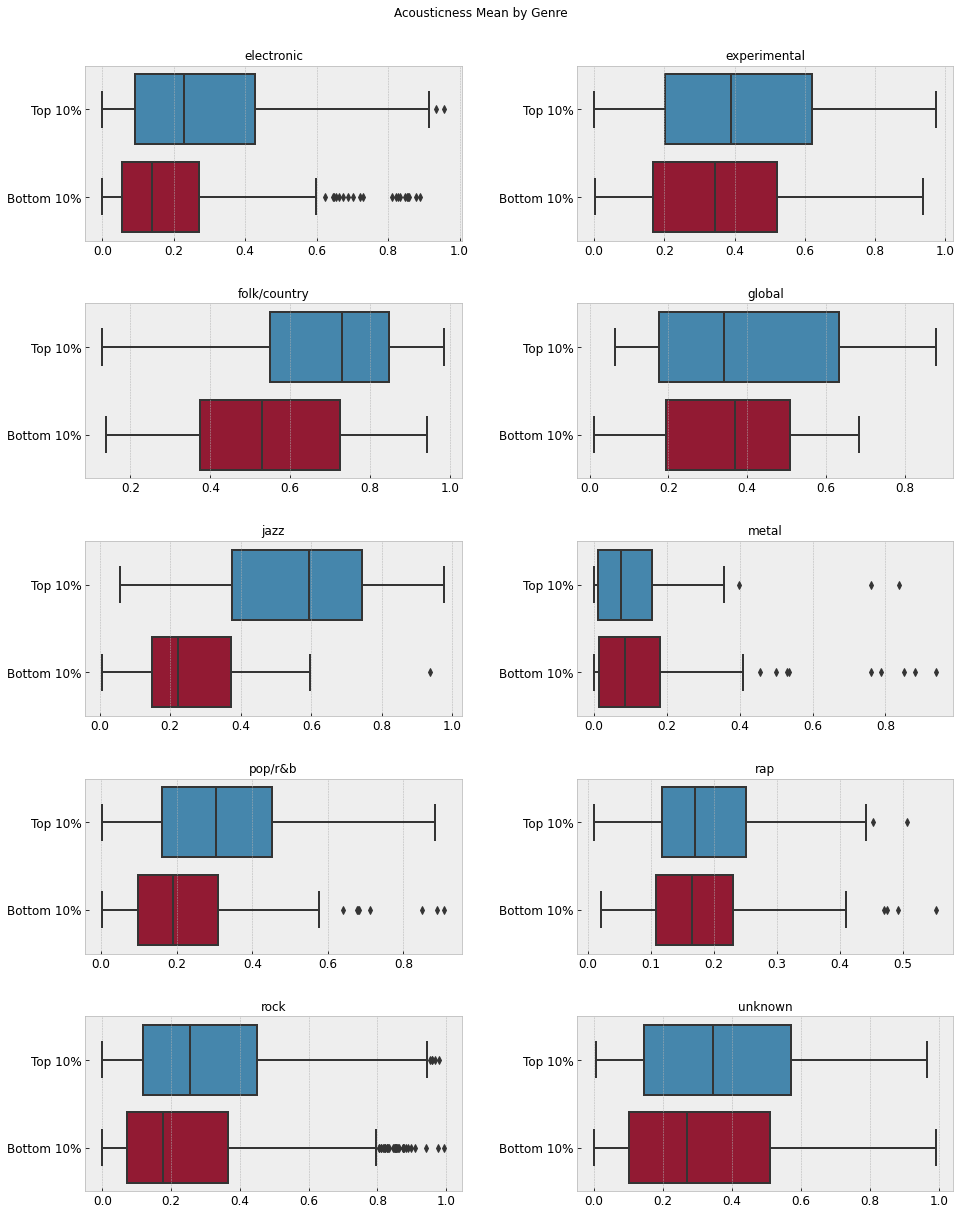

In [49]:
plot_numeric_grid('acousticness_mean', top_album_df, bottom_album_df, 'Acousticness Mean by Genre')

In [50]:
acousticness_mean_df = genre_comparison('acousticness_mean', top_album_df, bottom_album_df)
acousticness_mean_df

#### Variance

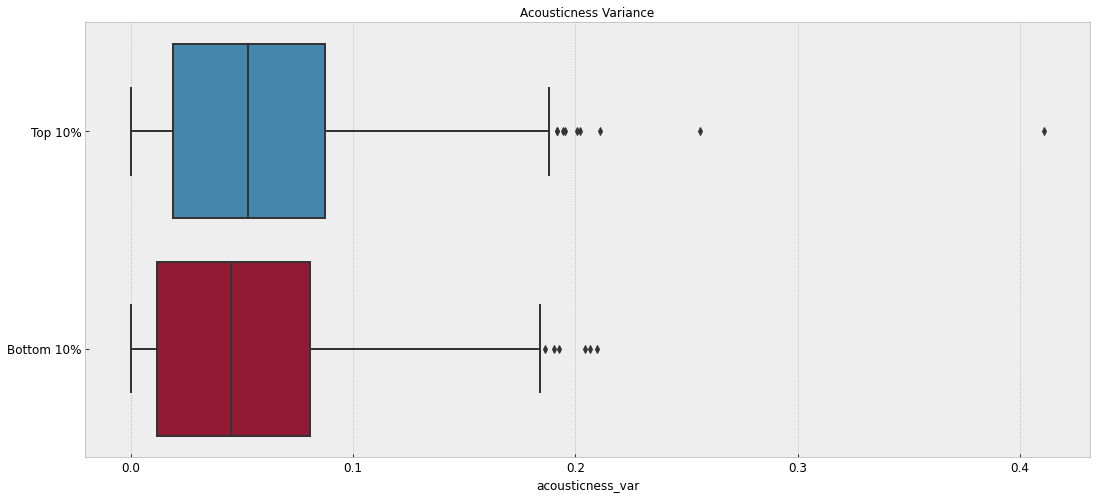

In [51]:
plot_numeric_col('acousticness_var', top_album_df, bottom_album_df, 'Acousticness Variance')

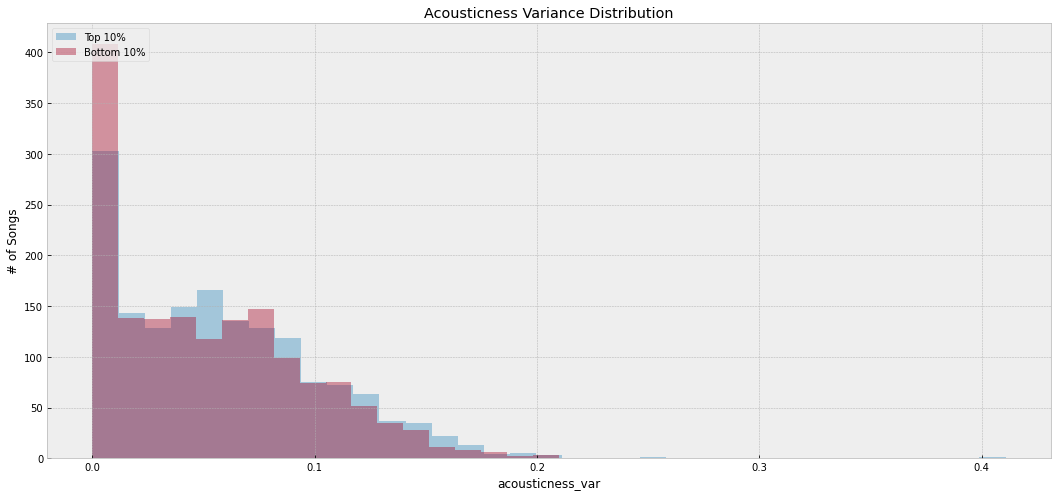

In [52]:
plot_histogram('acousticness_var', top_album_df, bottom_album_df, title='Acousticness Variance Distribution')

In [53]:
var_comparison('acousticness_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1186193.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.458
Top 10% Median:  0.052592947528168885
Bottom 10% Median:  0.045219720285984845
Number of Outliers (Top 10%):  6
Number of Outliers (Bottom 10%):  7


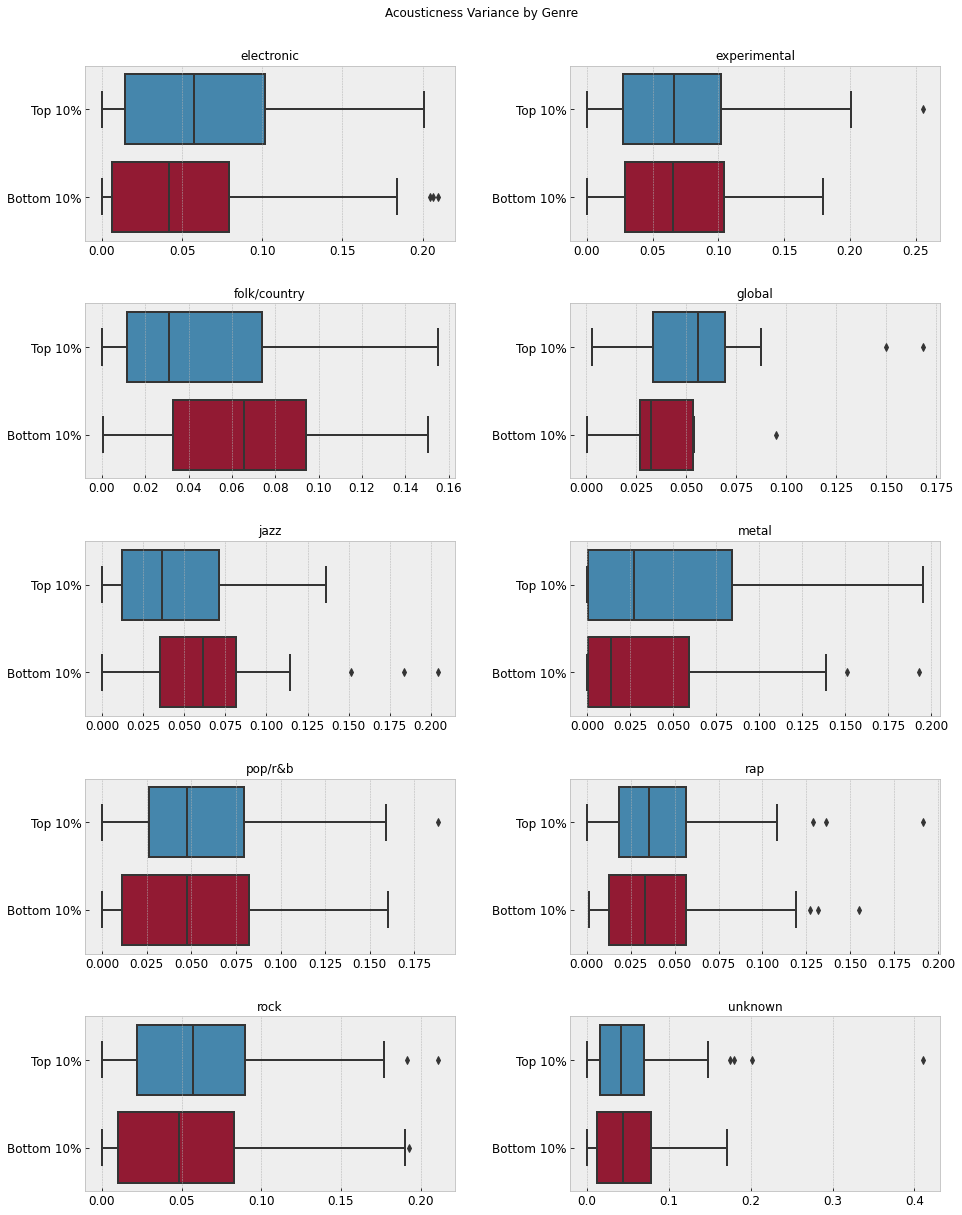

In [54]:
plot_numeric_grid('acousticness_var', top_album_df, bottom_album_df, 'Acousticness Variance by Genre')

In [55]:
acousticness_var_df = genre_comparison('acousticness_var', top_album_df, bottom_album_df)
acousticness_var_df

### Danceability
#### Mean

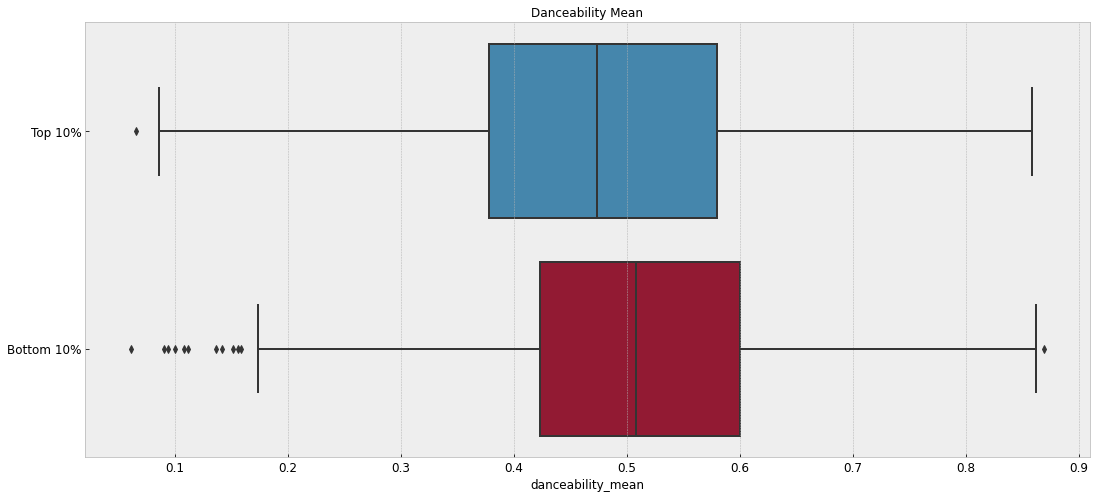

In [56]:
plot_numeric_col('danceability_mean', top_album_df, bottom_album_df, 'Danceability Mean')

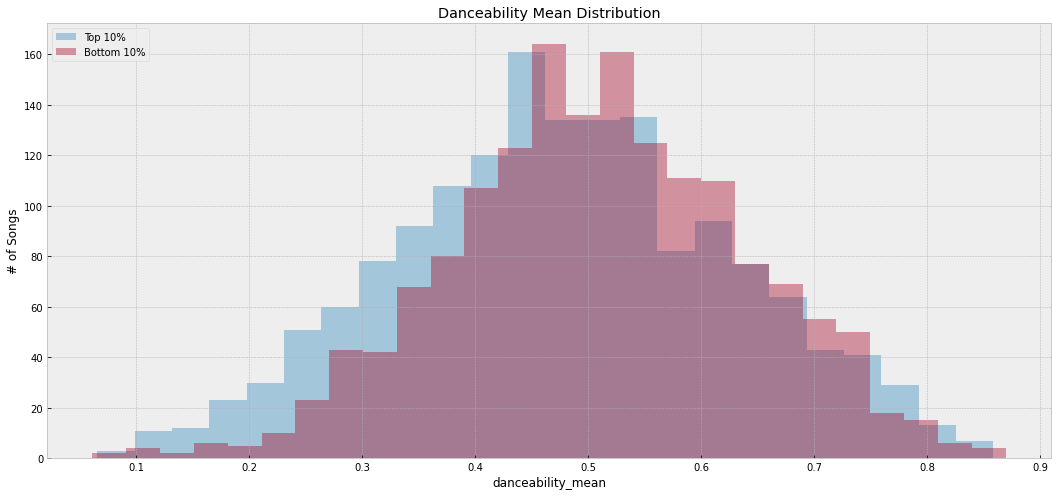

In [57]:
plot_histogram('danceability_mean', top_album_df, bottom_album_df, title='Danceability Mean Distribution')

In [58]:
var_comparison('danceability_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1134216.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.438
Top 10% Median:  0.47399999999999987
Bottom 10% Median:  0.5085227272727273
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


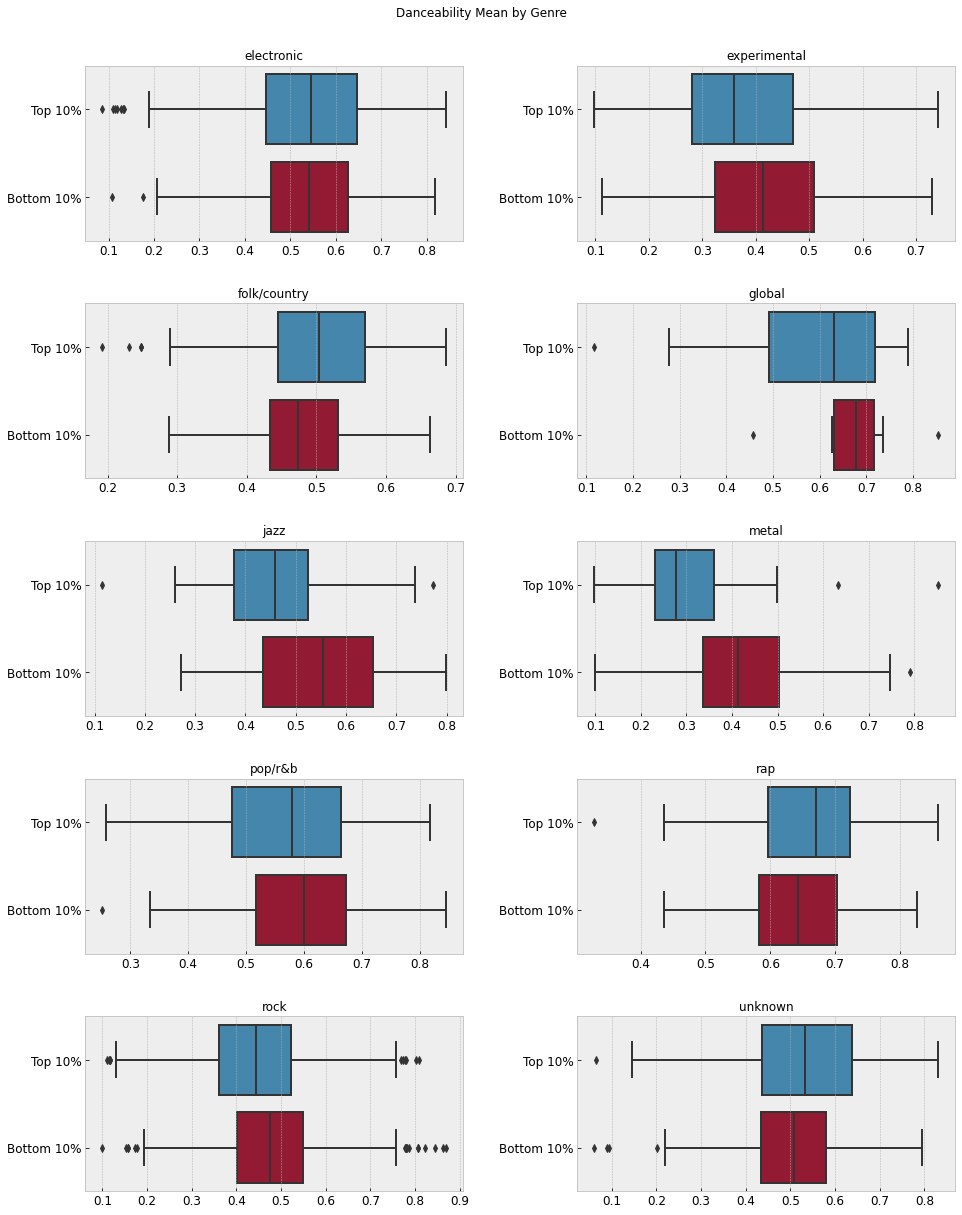

In [59]:
plot_numeric_grid('danceability_mean', top_album_df, bottom_album_df, 'Danceability Mean by Genre')

In [60]:
danceability_mean_df = genre_comparison('danceability_mean', top_album_df, bottom_album_df)
danceability_mean_df

#### Variance

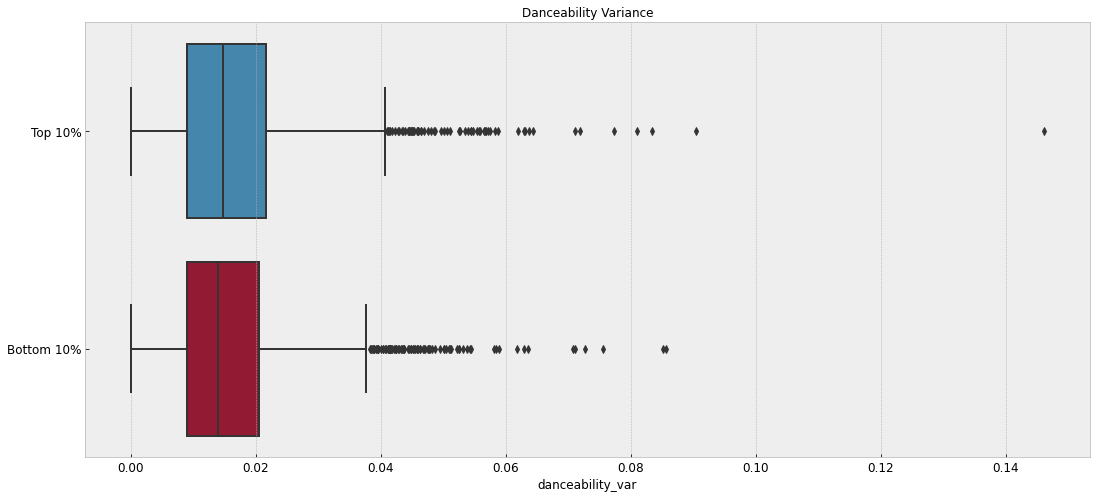

In [61]:
plot_numeric_col('danceability_var', top_album_df, bottom_album_df, 'Danceability Variance')

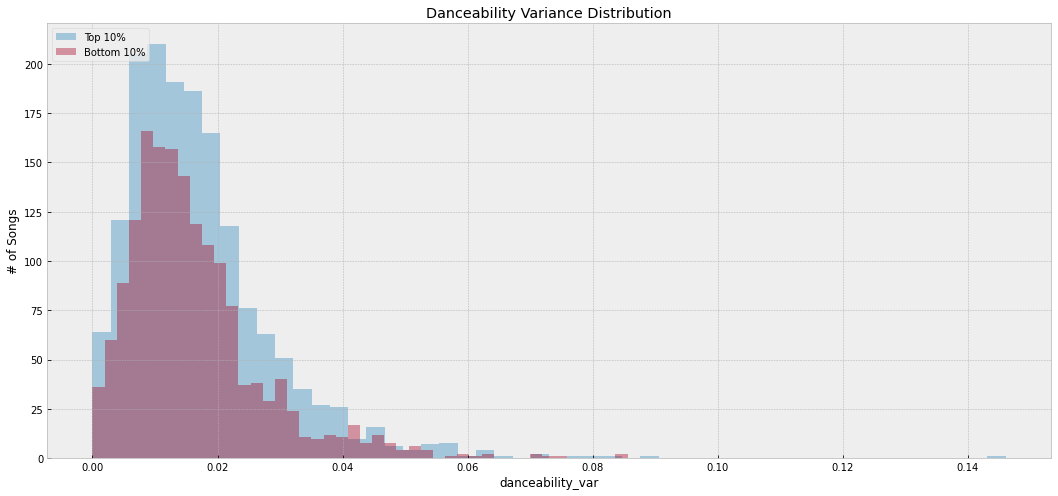

In [62]:
plot_histogram('danceability_var', top_album_df, bottom_album_df, title='Danceability Variance Distribution')

In [63]:
var_comparison('danceability_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1243995.0
p-value:  0.028
Significant:  True
Common Language Effect Size:  0.481
Top 10% Median:  0.014810977073365227
Bottom 10% Median:  0.013893802406417105
Number of Outliers (Top 10%):  27
Number of Outliers (Bottom 10%):  26


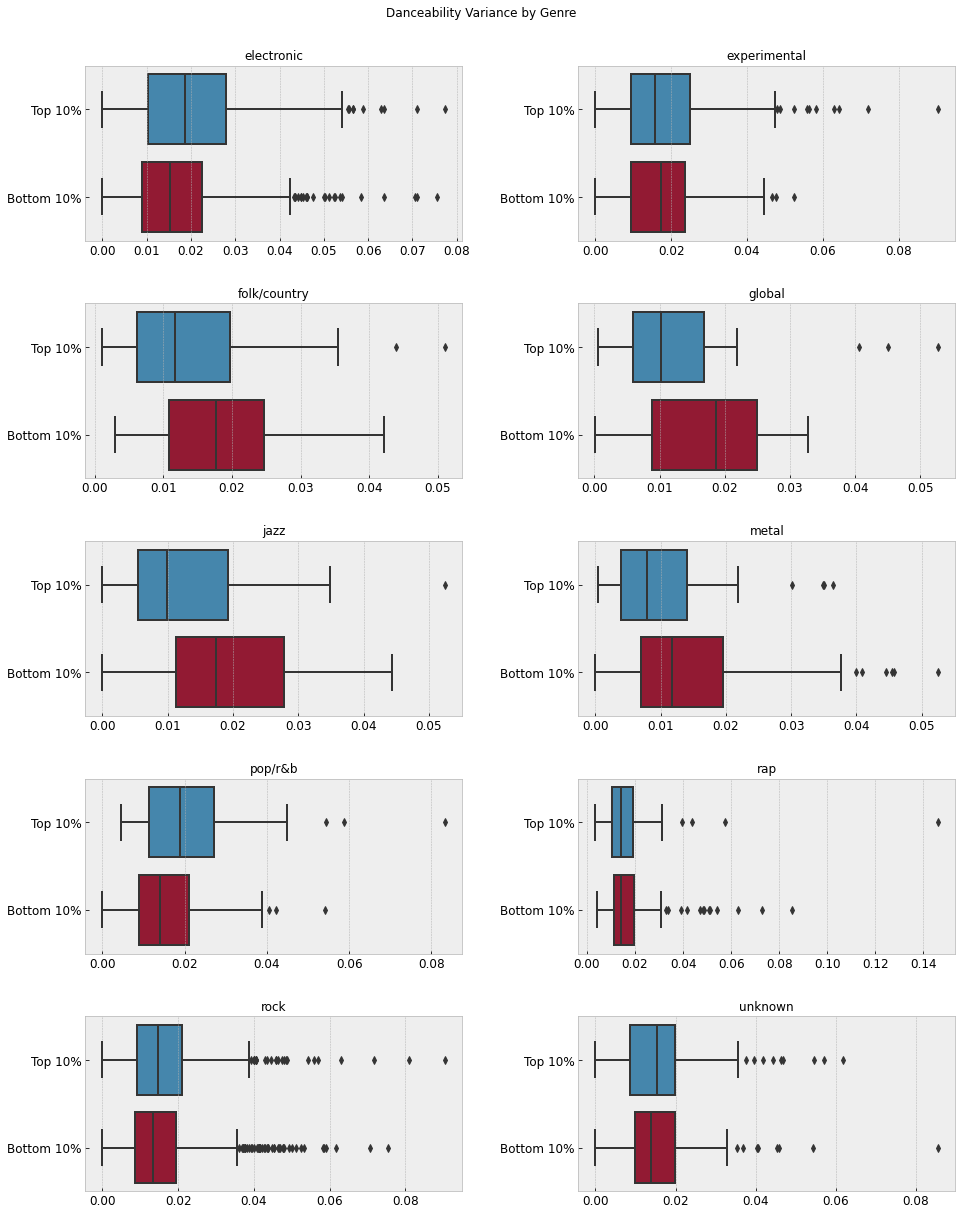

In [64]:
plot_numeric_grid('danceability_var', top_album_df, bottom_album_df, 'Danceability Variance by Genre')

In [65]:
danceability_var_df = genre_comparison('danceability_var', top_album_df, bottom_album_df)
danceability_var_df

### Energy
#### Mean

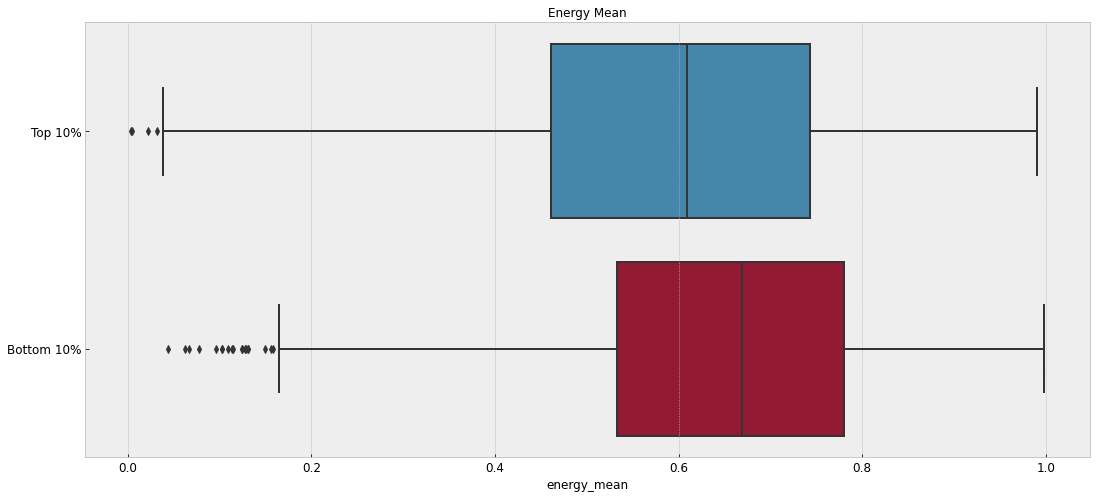

In [66]:
plot_numeric_col('energy_mean', top_album_df, bottom_album_df, 'Energy Mean')

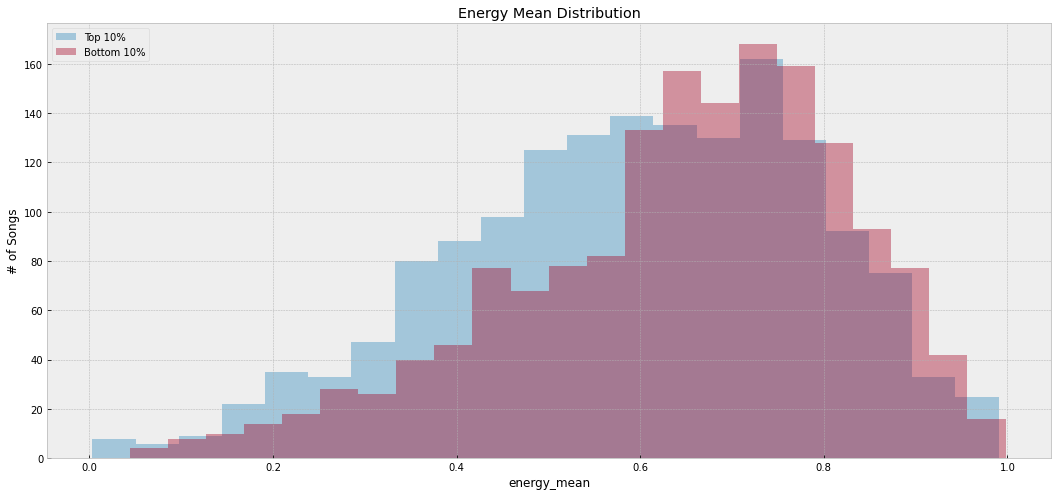

In [67]:
plot_histogram('energy_mean', top_album_df, bottom_album_df, title='Energy Mean Distribution')

In [68]:
var_comparison('energy_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1084335.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.419
Top 10% Median:  0.6094162895927602
Bottom 10% Median:  0.6694053030303031
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


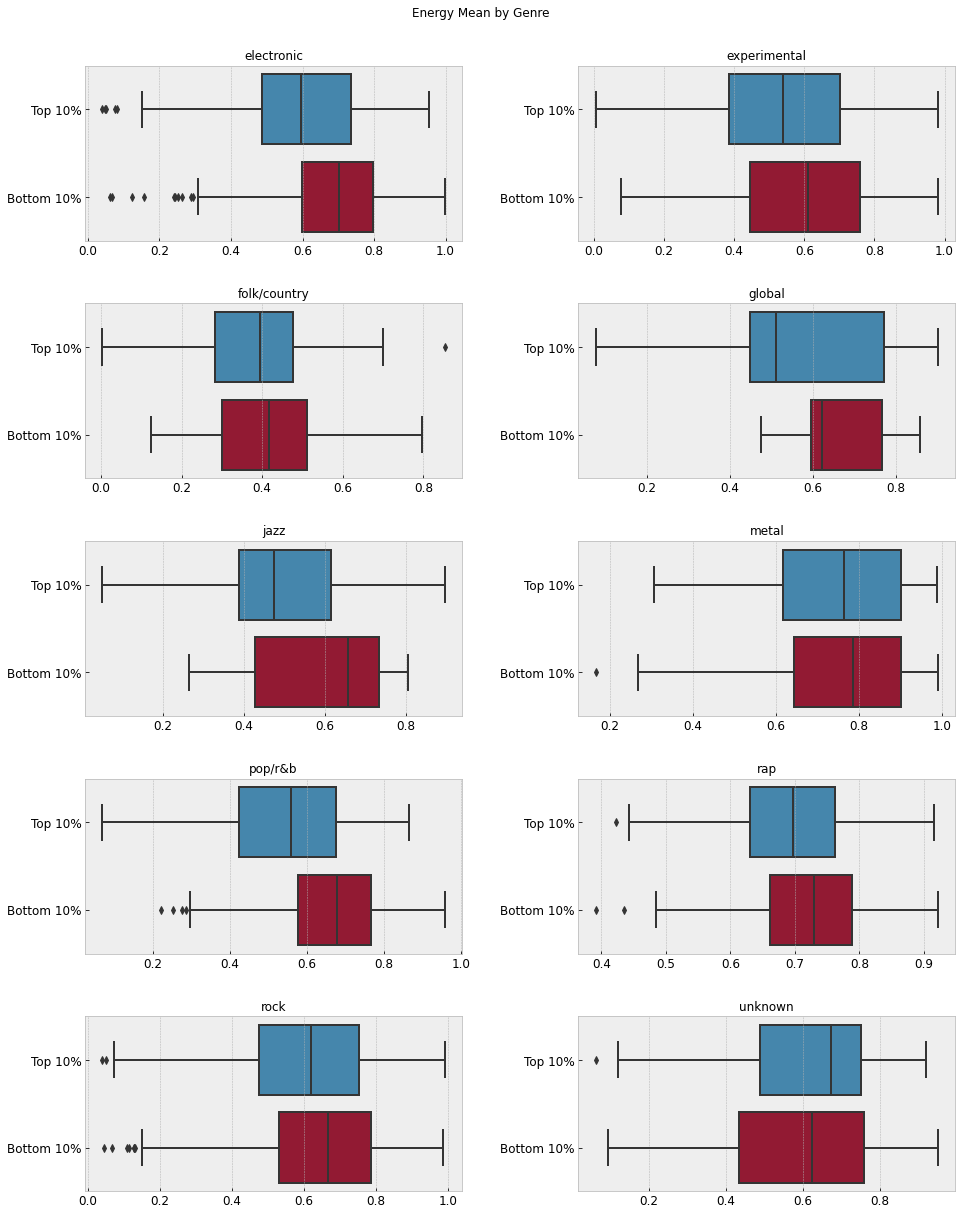

In [69]:
plot_numeric_grid('energy_mean', top_album_df, bottom_album_df, 'Energy Mean by Genre')

In [70]:
energy_mean_df = genre_comparison('energy_mean', top_album_df, bottom_album_df)
energy_mean_df

#### Variance

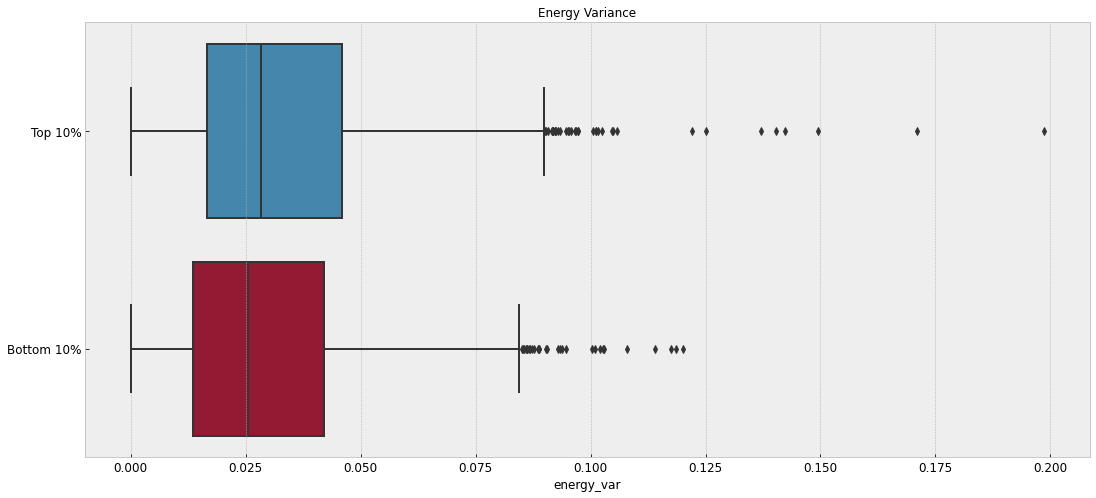

In [71]:
plot_numeric_col('energy_var', top_album_df, bottom_album_df, 'Energy Variance')

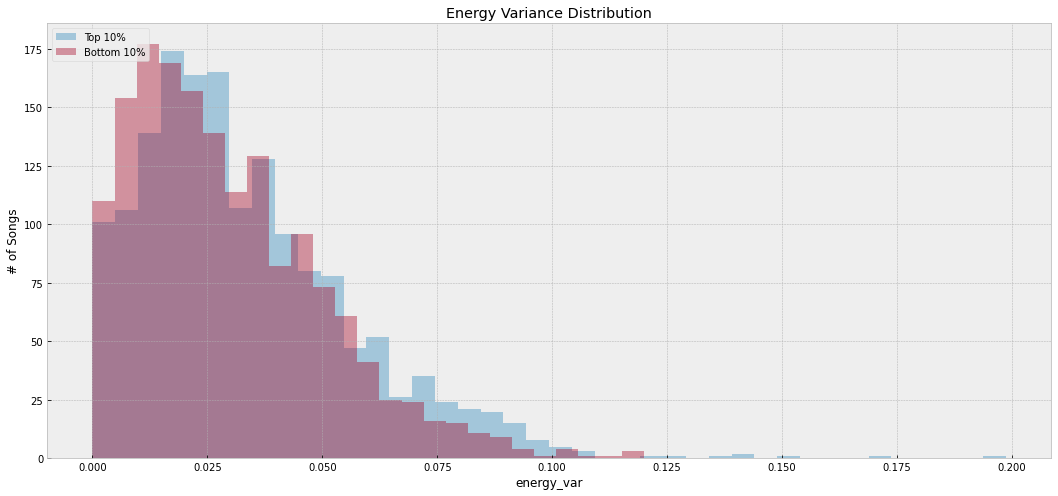

In [72]:
plot_histogram('energy_var', top_album_df, bottom_album_df, title='Energy Variance Distribution')

In [73]:
var_comparison('energy_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1175348.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.454
Top 10% Median:  0.02835714826548899
Bottom 10% Median:  0.025463503787878778
Number of Outliers (Top 10%):  11
Number of Outliers (Bottom 10%):  14


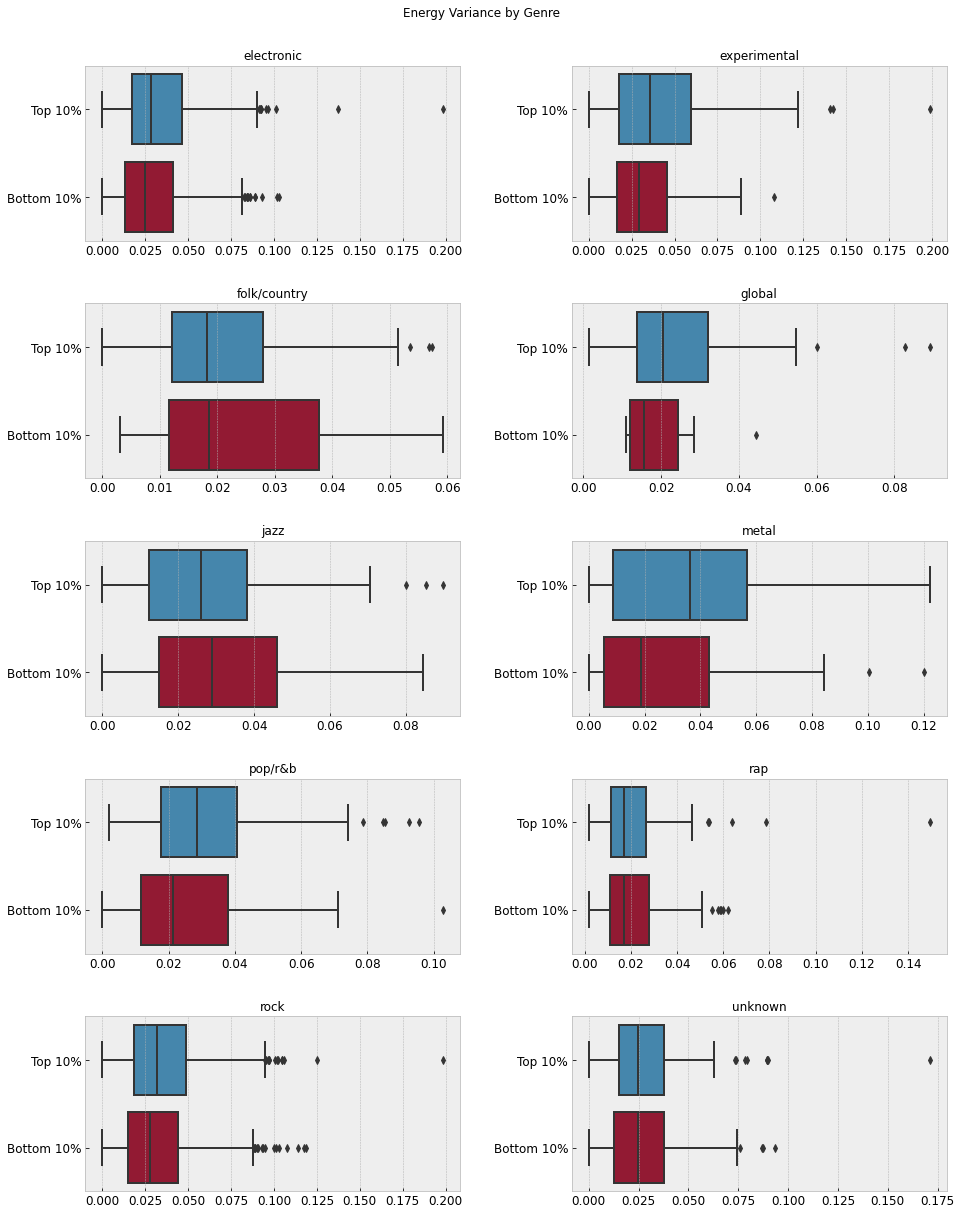

In [74]:
plot_numeric_grid('energy_var', top_album_df, bottom_album_df, 'Energy Variance by Genre')

In [75]:
energy_var_df = genre_comparison('energy_var', top_album_df, bottom_album_df)
energy_var_df

### Mode
#### Mean

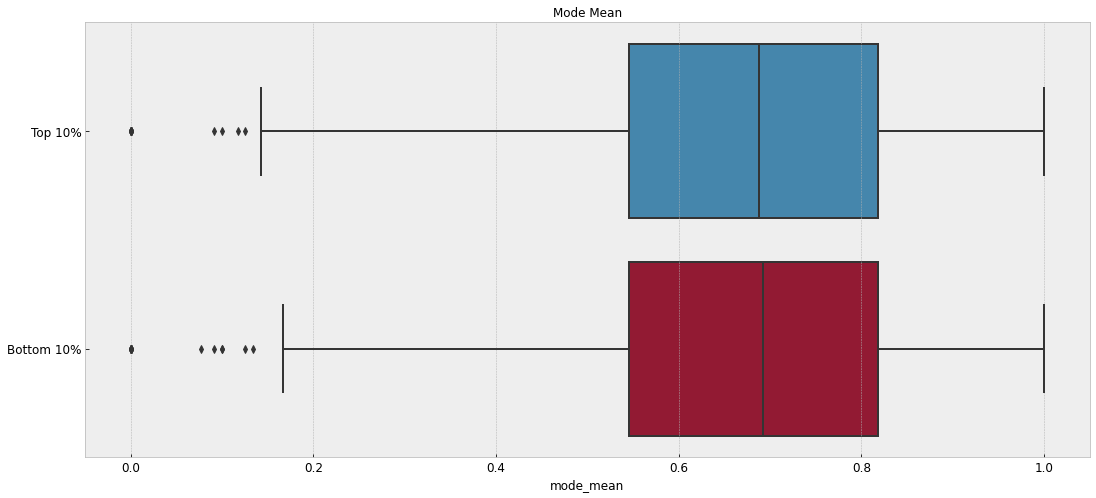

In [76]:
plot_numeric_col('mode_mean', top_album_df, bottom_album_df, 'Mode Mean')

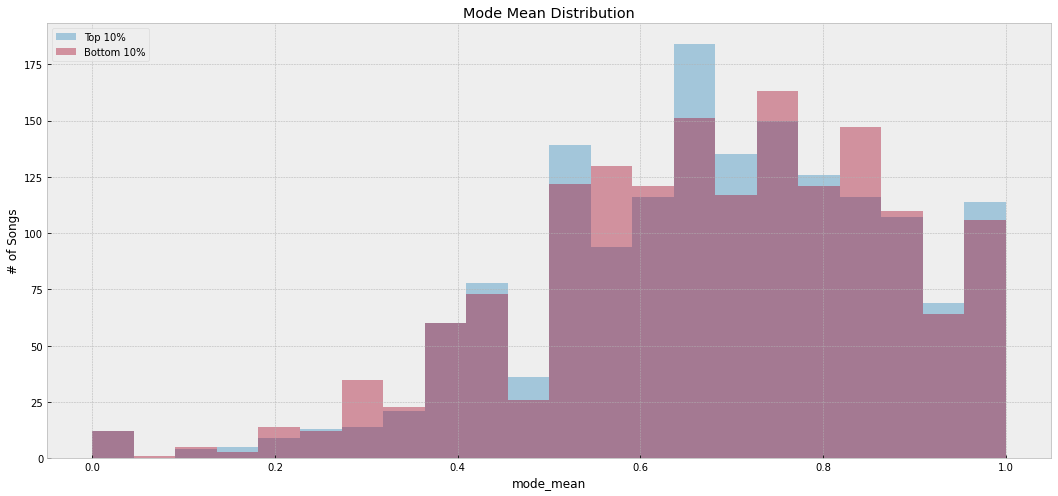

In [77]:
plot_histogram('mode_mean', top_album_df, bottom_album_df, title='Mode Mean Distribution')

In [78]:
var_comparison('mode_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1288064.5
p-value:  0.405
Significant:  False
Common Language Effect Size:  0.498
Top 10% Median:  0.6875
Bottom 10% Median:  0.6923076923076923
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


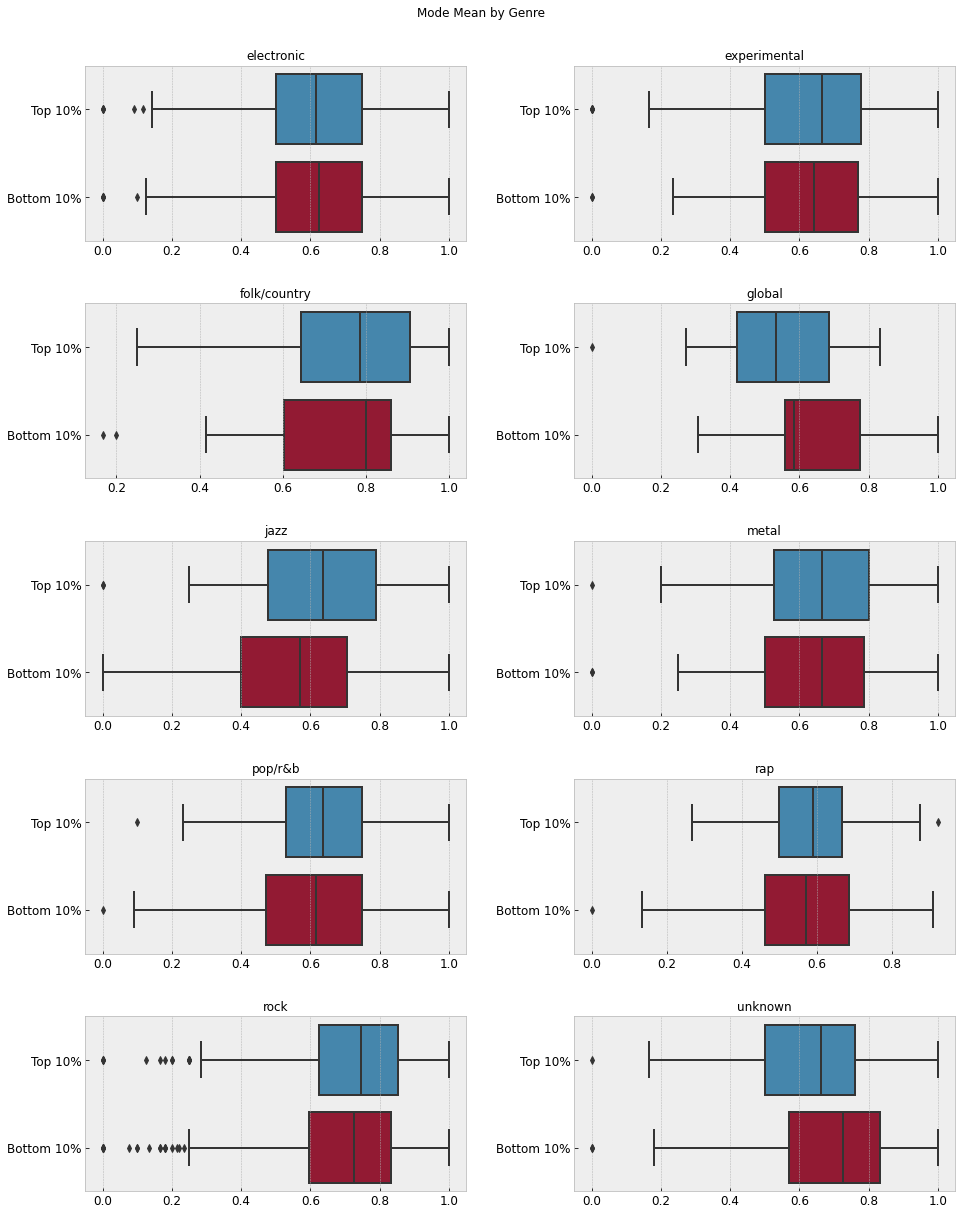

In [79]:
plot_numeric_grid('mode_mean', top_album_df, bottom_album_df, 'Mode Mean by Genre')

In [80]:
mode_mean_df = genre_comparison('mode_mean', top_album_df, bottom_album_df)
mode_mean_df

#### Variance

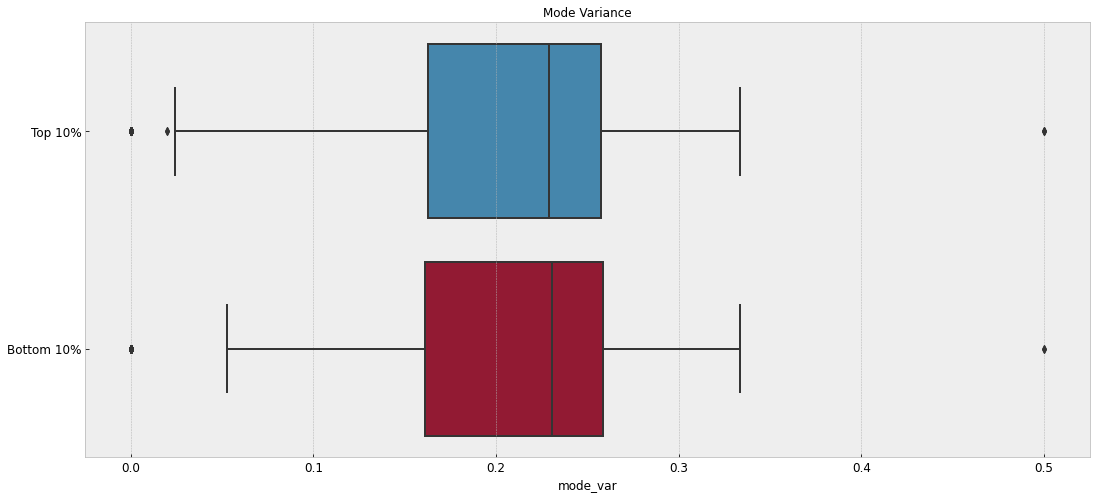

In [81]:
plot_numeric_col('mode_var', top_album_df, bottom_album_df, 'Mode Variance')

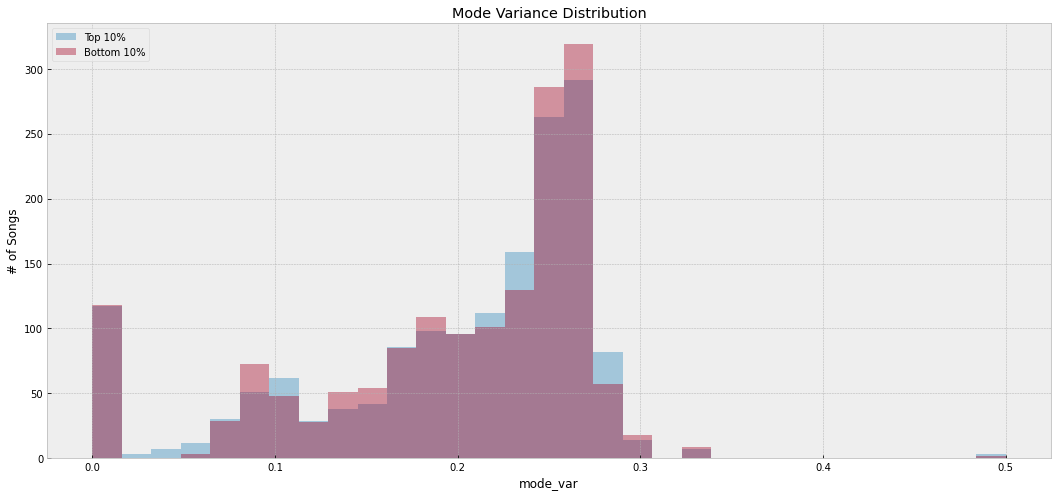

In [82]:
plot_histogram('mode_var', top_album_df, bottom_album_df, title='Mode Variance Distribution')

In [83]:
var_comparison('mode_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1292444.0
p-value:  0.47
Significant:  False
Common Language Effect Size:  0.499
Top 10% Median:  0.22916666666666666
Bottom 10% Median:  0.23076923076923075
Number of Outliers (Top 10%):  3
Number of Outliers (Bottom 10%):  2


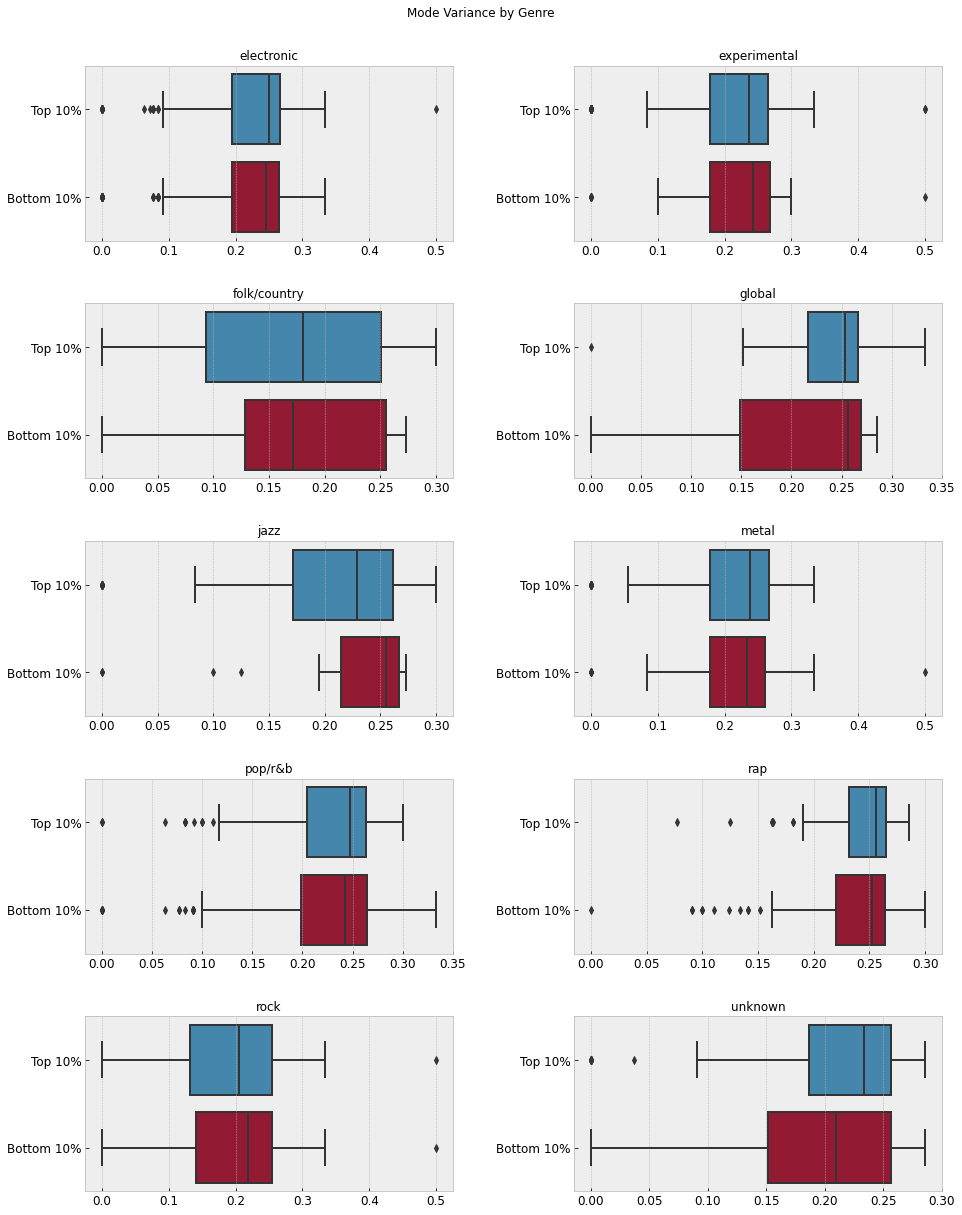

In [84]:
plot_numeric_grid('mode_var', top_album_df, bottom_album_df, 'Mode Variance by Genre')

In [85]:
mode_var_df = genre_comparison('mode_var', top_album_df, bottom_album_df)
mode_var_df

### Instrumentalness
#### Mean

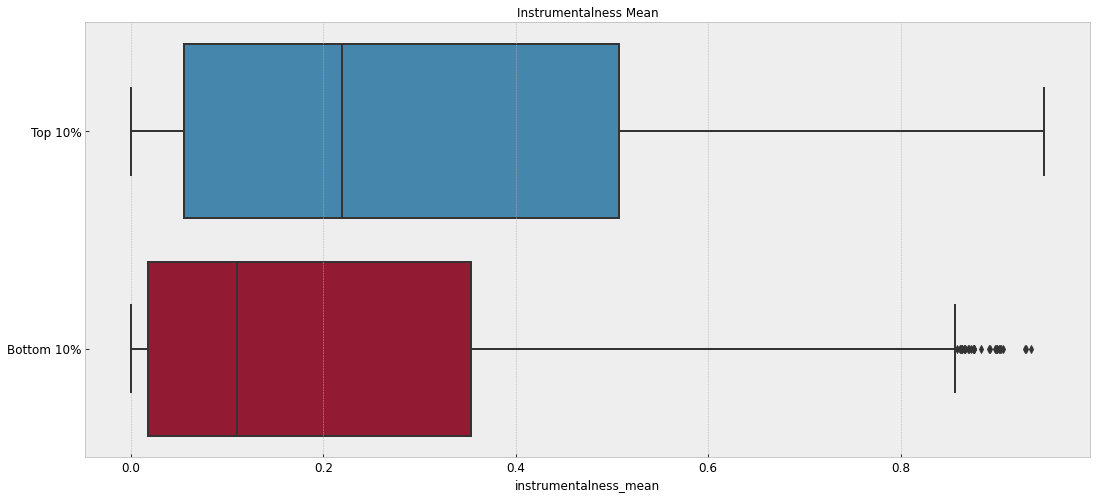

In [86]:
plot_numeric_col('instrumentalness_mean', top_album_df, bottom_album_df, 'Instrumentalness Mean')

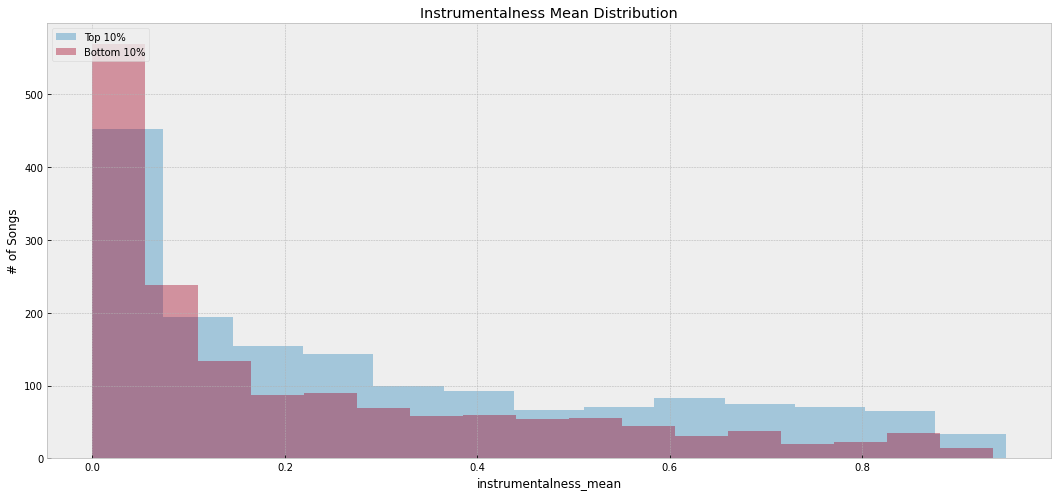

In [87]:
plot_histogram('instrumentalness_mean', top_album_df, bottom_album_df, title='Instrumentalness Mean Distribution')

In [88]:
var_comparison('instrumentalness_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1051537.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.406
Top 10% Median:  0.219097693125
Bottom 10% Median:  0.11042221922222223
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


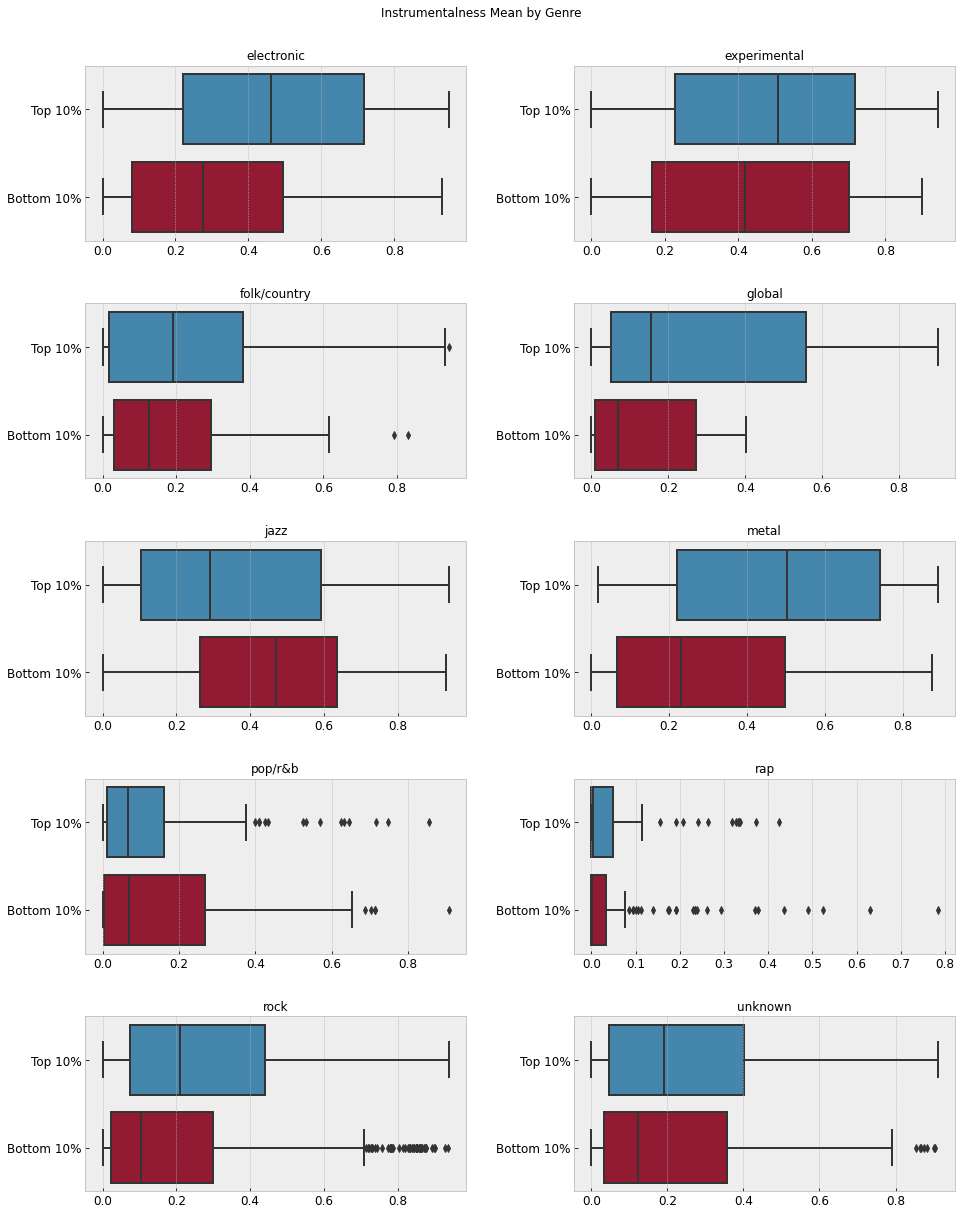

In [89]:
plot_numeric_grid('instrumentalness_mean', top_album_df, bottom_album_df, 'Instrumentalness Mean by Genre')

In [90]:
instrumentalness_mean_df = genre_comparison('instrumentalness_mean', top_album_df, bottom_album_df)
instrumentalness_mean_df

#### Variance

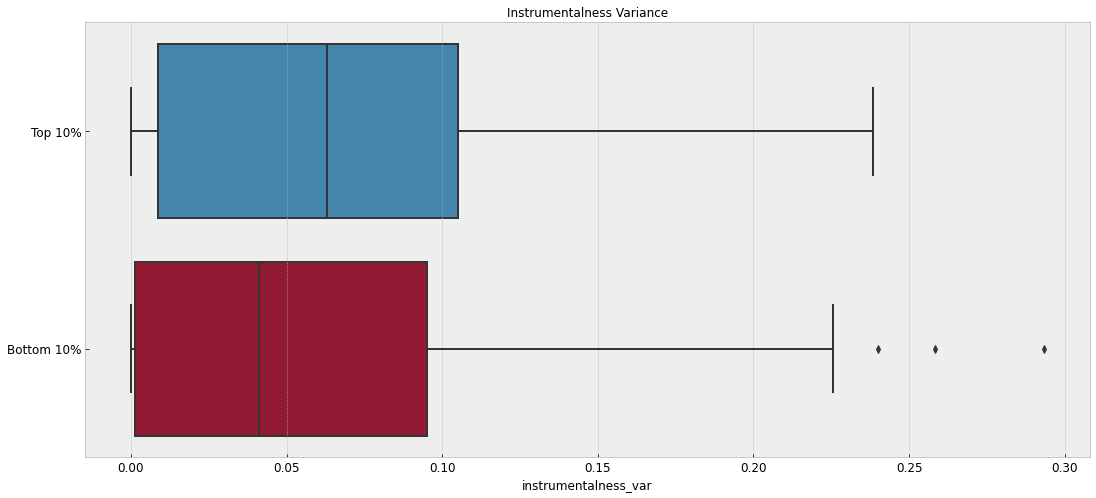

In [91]:
plot_numeric_col('instrumentalness_var', top_album_df, bottom_album_df, 'Instrumentalness Variance')

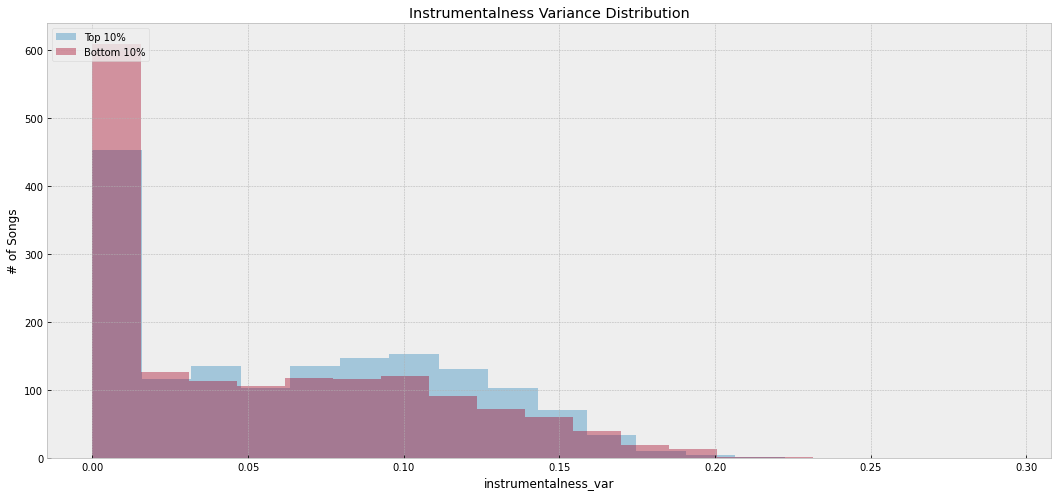

In [92]:
plot_histogram('instrumentalness_var', top_album_df, bottom_album_df, title='Instrumentalness Variance Distribution')

In [93]:
var_comparison('instrumentalness_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1131556.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.437
Top 10% Median:  0.06287774561937573
Bottom 10% Median:  0.0411349
Number of Outliers (Top 10%):  1
Number of Outliers (Bottom 10%):  5


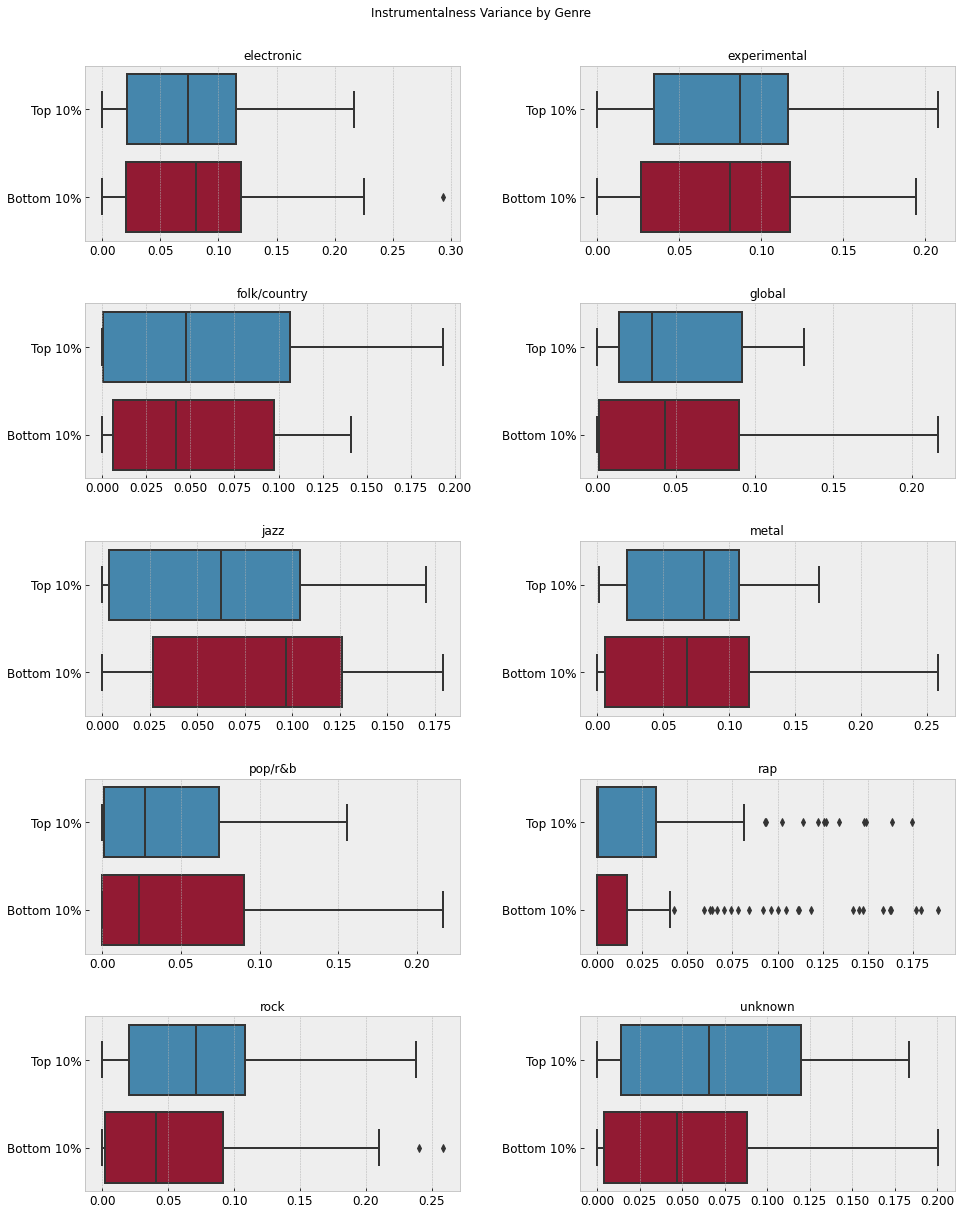

In [94]:
plot_numeric_grid('instrumentalness_var', top_album_df, bottom_album_df, 'Instrumentalness Variance by Genre')

In [95]:
instrumentalness_var_df = genre_comparison('instrumentalness_var', top_album_df, bottom_album_df)
instrumentalness_var_df

### Liveness
#### Mean

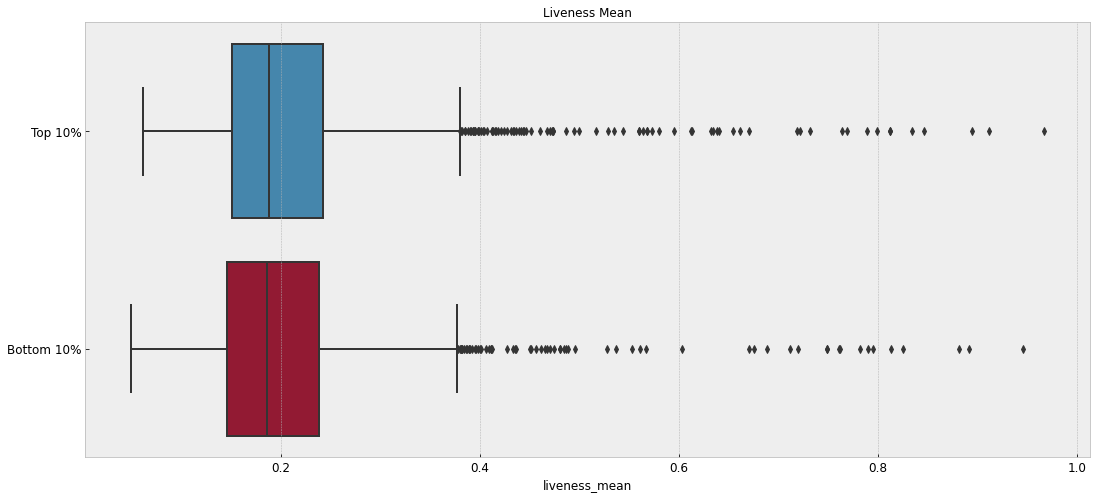

In [96]:
plot_numeric_col('liveness_mean', top_album_df, bottom_album_df, 'Liveness Mean')

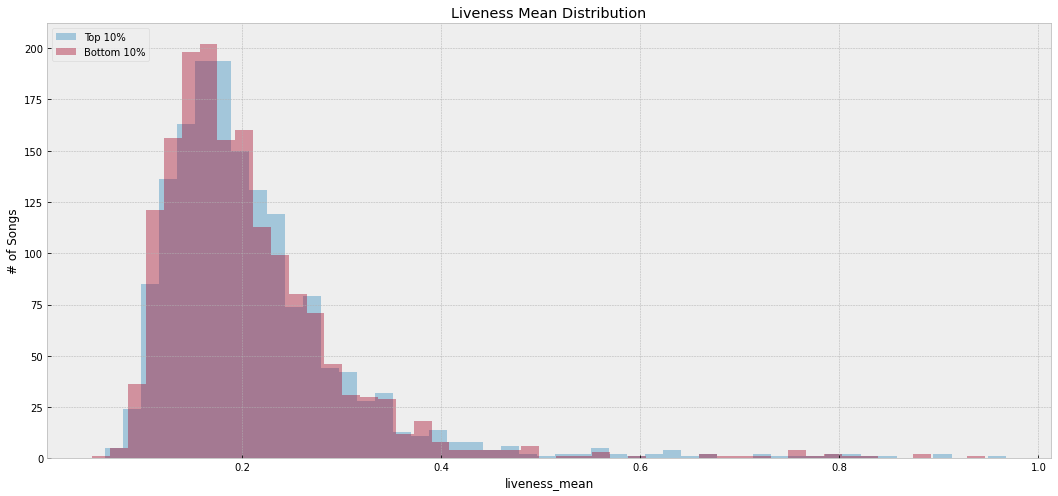

In [97]:
plot_histogram('liveness_mean', top_album_df, bottom_album_df, title='Liveness Mean Distribution')

In [98]:
var_comparison('liveness_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1251215.5
p-value:  0.051
Significant:  False
Common Language Effect Size:  0.483
Top 10% Median:  0.18828
Bottom 10% Median:  0.1860017156862745
Number of Outliers (Top 10%):  34
Number of Outliers (Bottom 10%):  24


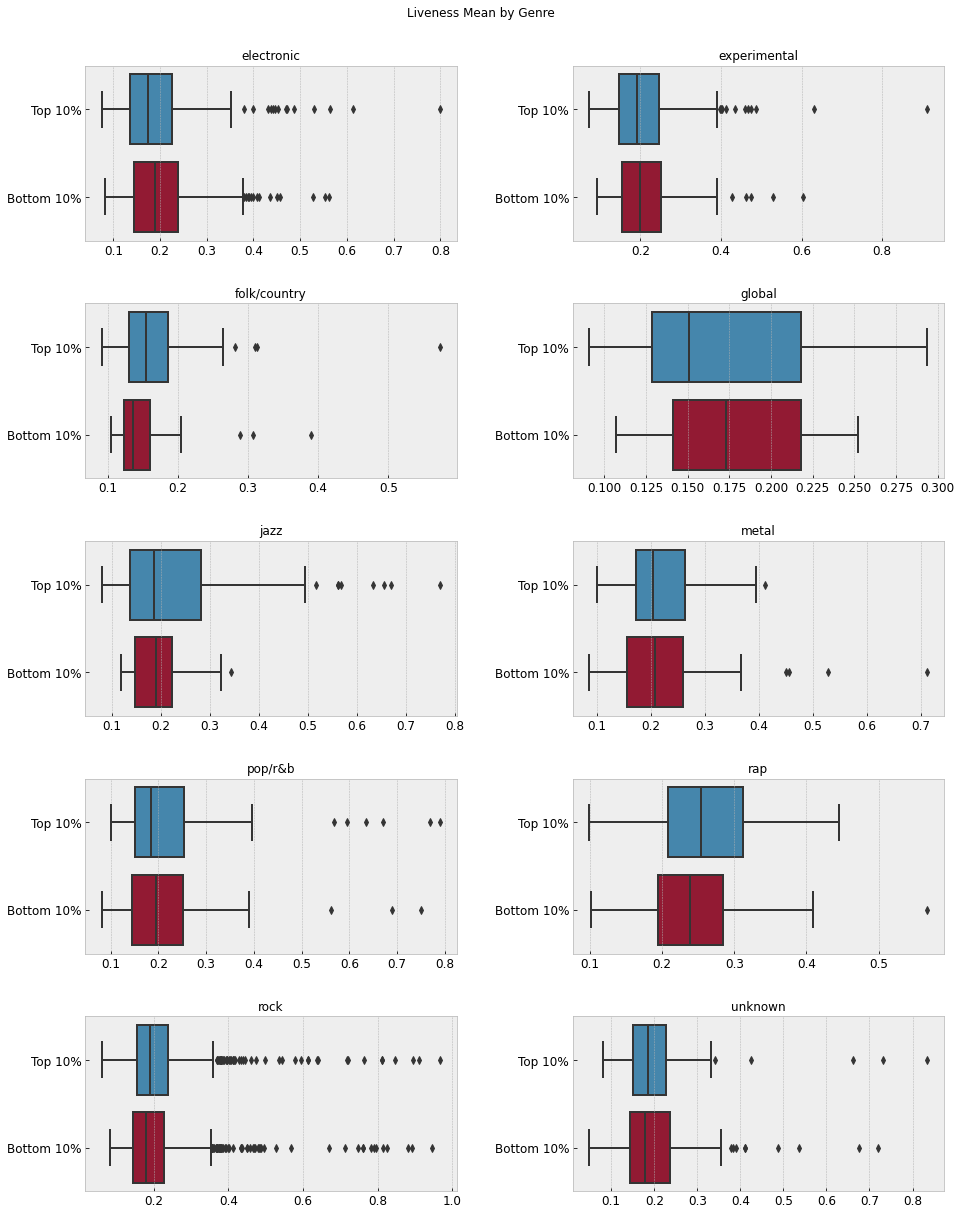

In [99]:
plot_numeric_grid('liveness_mean', top_album_df, bottom_album_df, 'Liveness Mean by Genre')

In [100]:
liveness_mean_df = genre_comparison('liveness_mean', top_album_df, bottom_album_df)
liveness_mean_df

#### Variance

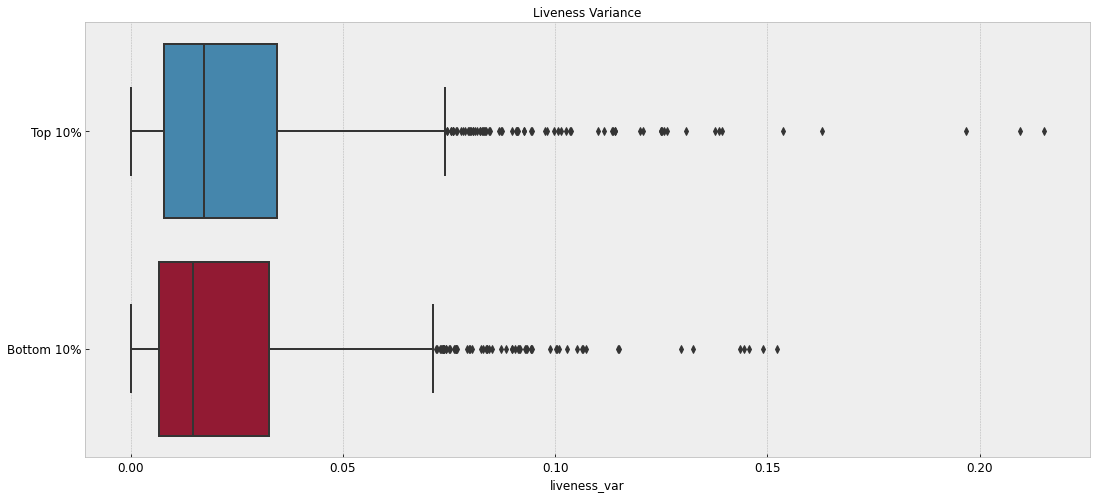

In [101]:
plot_numeric_col('liveness_var', top_album_df, bottom_album_df, 'Liveness Variance')

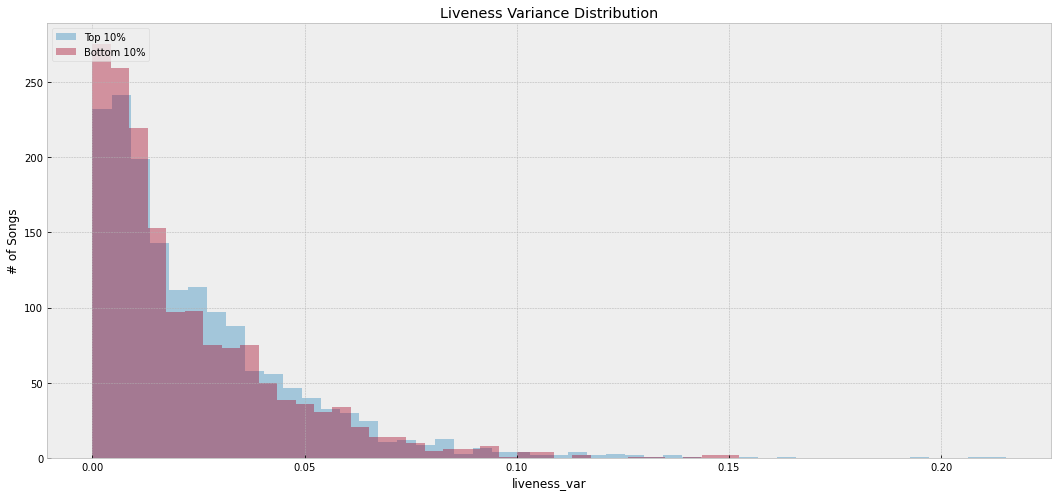

In [102]:
plot_histogram('liveness_var', top_album_df, bottom_album_df, title='Liveness Variance Distribution')

In [103]:
var_comparison('liveness_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1210278.0
p-value:  0.001
Significant:  True
Common Language Effect Size:  0.467
Top 10% Median:  0.01732064083333333
Bottom 10% Median:  0.014649369749999998
Number of Outliers (Top 10%):  28
Number of Outliers (Bottom 10%):  30


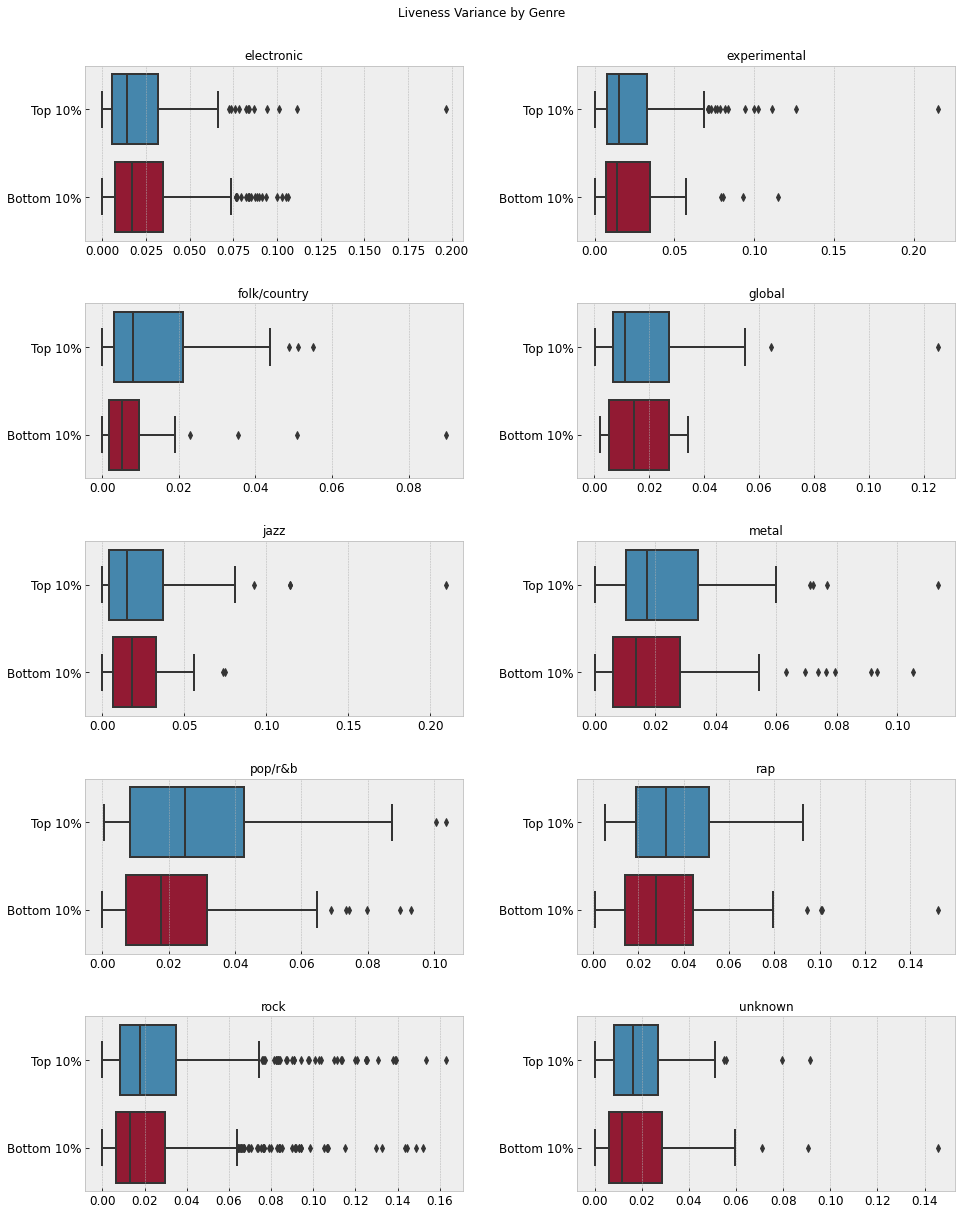

In [104]:
plot_numeric_grid('liveness_var', top_album_df, bottom_album_df, 'Liveness Variance by Genre')

In [105]:
liveness_var_df = genre_comparison('liveness_var', top_album_df, bottom_album_df)
liveness_var_df

### Speechiness 
#### Mean

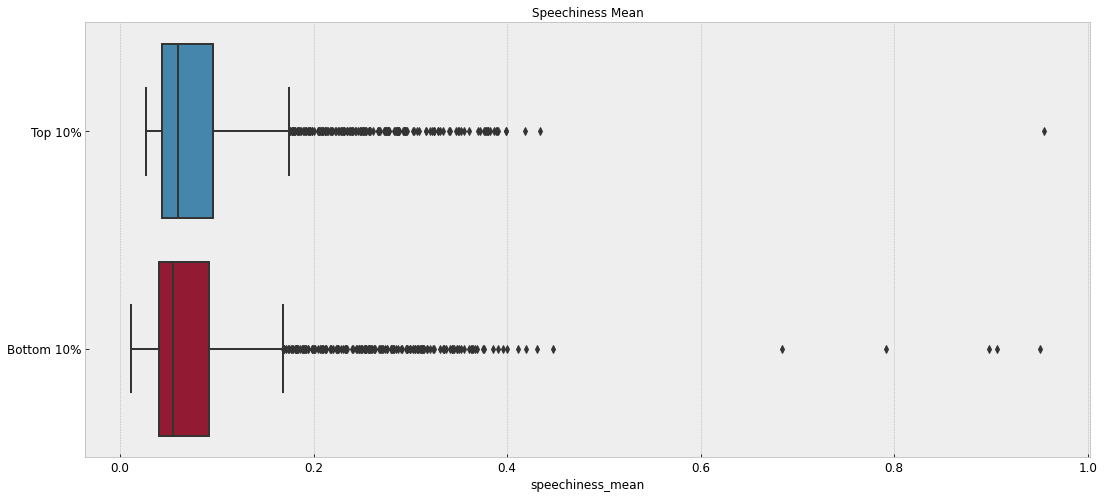

In [106]:
plot_numeric_col('speechiness_mean', top_album_df, bottom_album_df, 'Speechiness Mean')

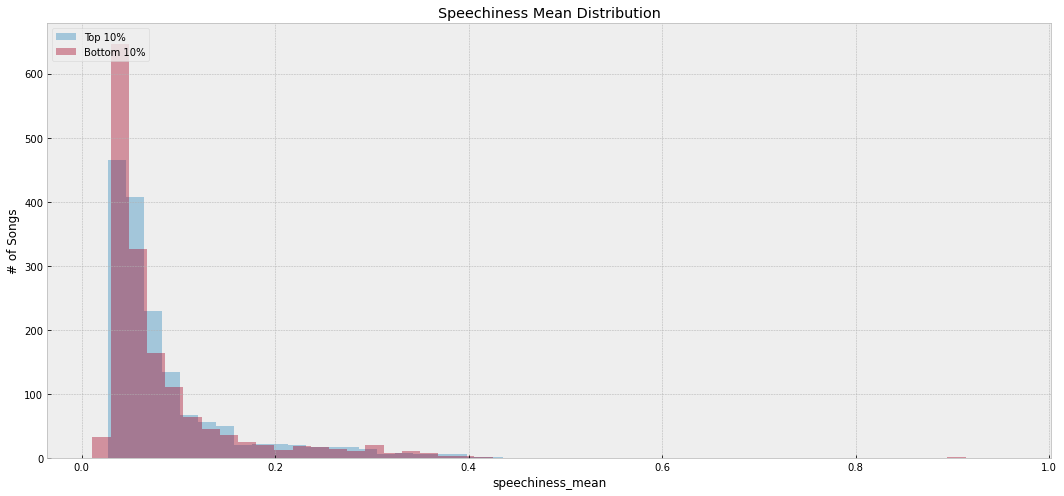

In [107]:
plot_histogram('speechiness_mean', top_album_df, bottom_album_df, title='Speechiness Mean Distribution')

In [108]:
var_comparison('speechiness_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1190189.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.46
Top 10% Median:  0.05966333333333333
Bottom 10% Median:  0.05465641025641026
Number of Outliers (Top 10%):  37
Number of Outliers (Bottom 10%):  31


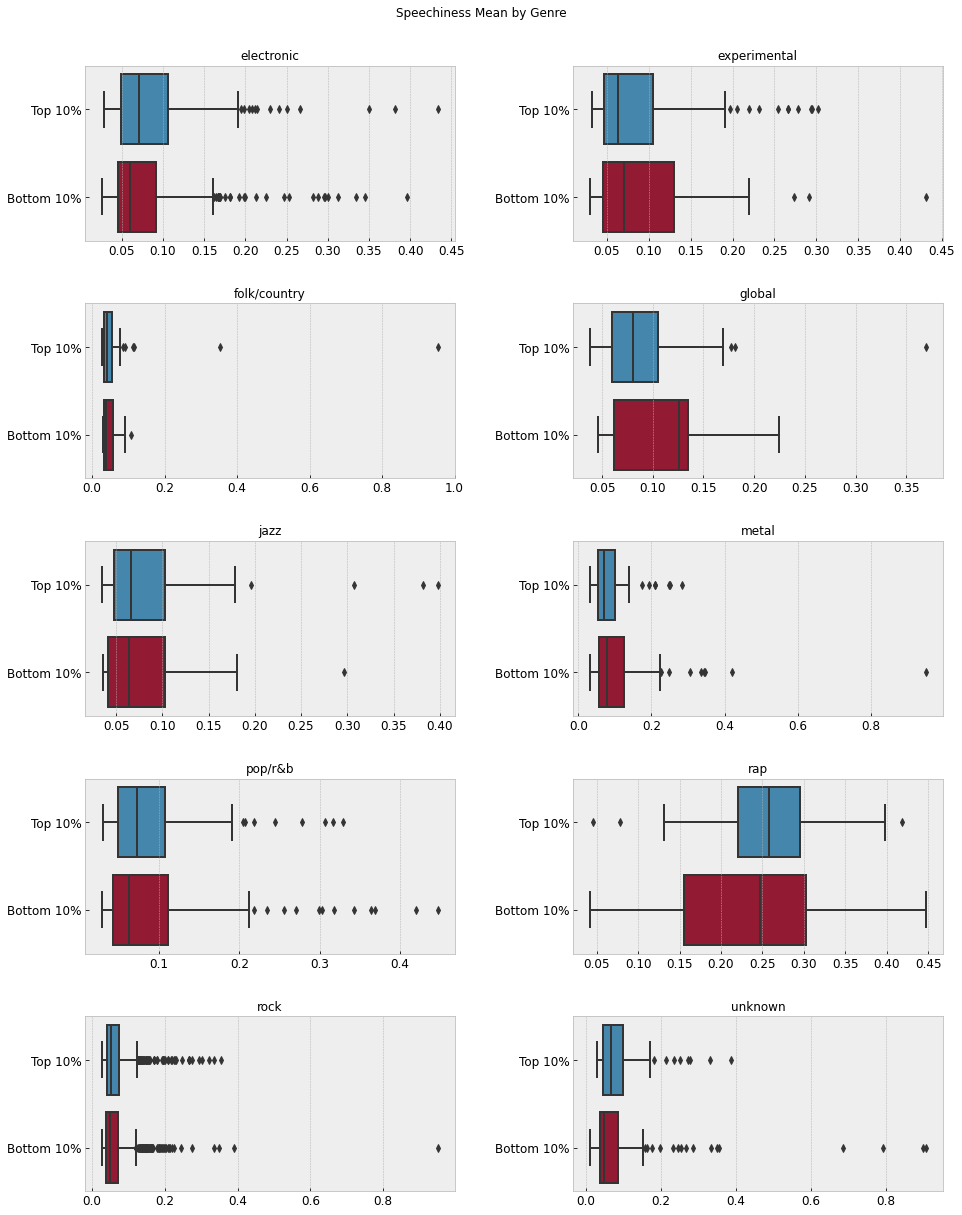

In [109]:
plot_numeric_grid('speechiness_mean', top_album_df, bottom_album_df, 'Speechiness Mean by Genre')

In [110]:
speechiness_mean_df = genre_comparison('speechiness_mean', top_album_df, bottom_album_df)
speechiness_mean_df

#### Variance

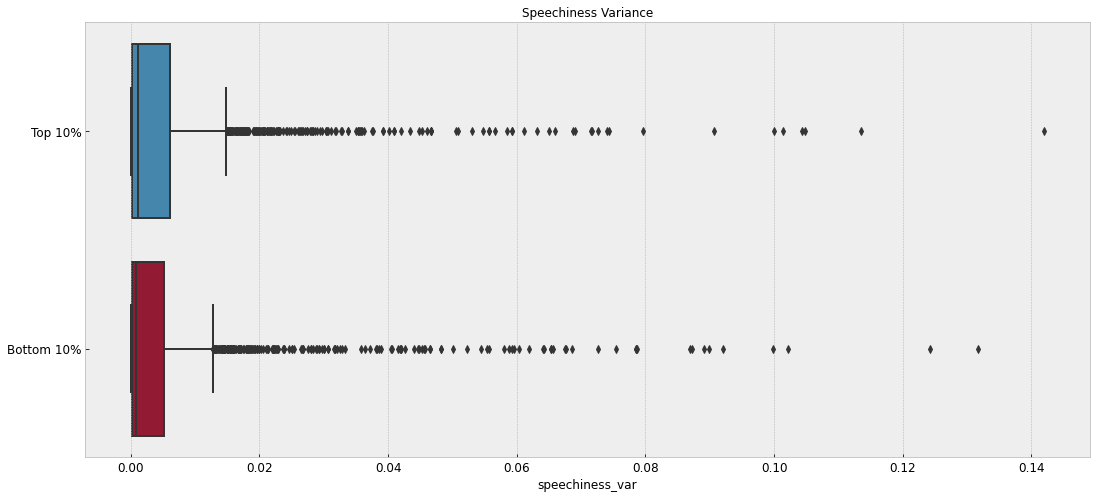

In [111]:
plot_numeric_col('speechiness_var', top_album_df, bottom_album_df, 'Speechiness Variance')

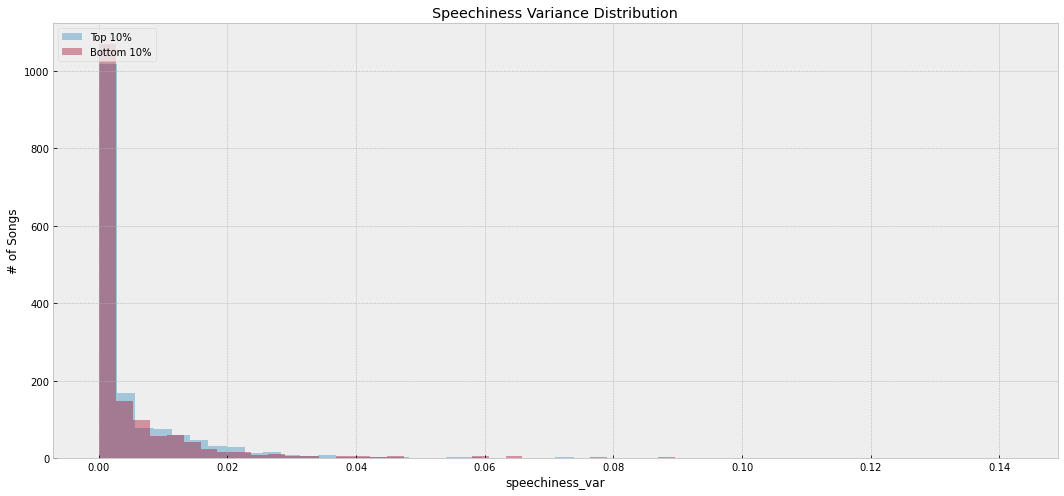

In [112]:
plot_histogram('speechiness_var', top_album_df, bottom_album_df, title='Speechiness Variance Distribution')

In [113]:
var_comparison('speechiness_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1197438.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.463
Top 10% Median:  0.0011602178484848486
Bottom 10% Median:  0.000746016517628205
Number of Outliers (Top 10%):  36
Number of Outliers (Bottom 10%):  43


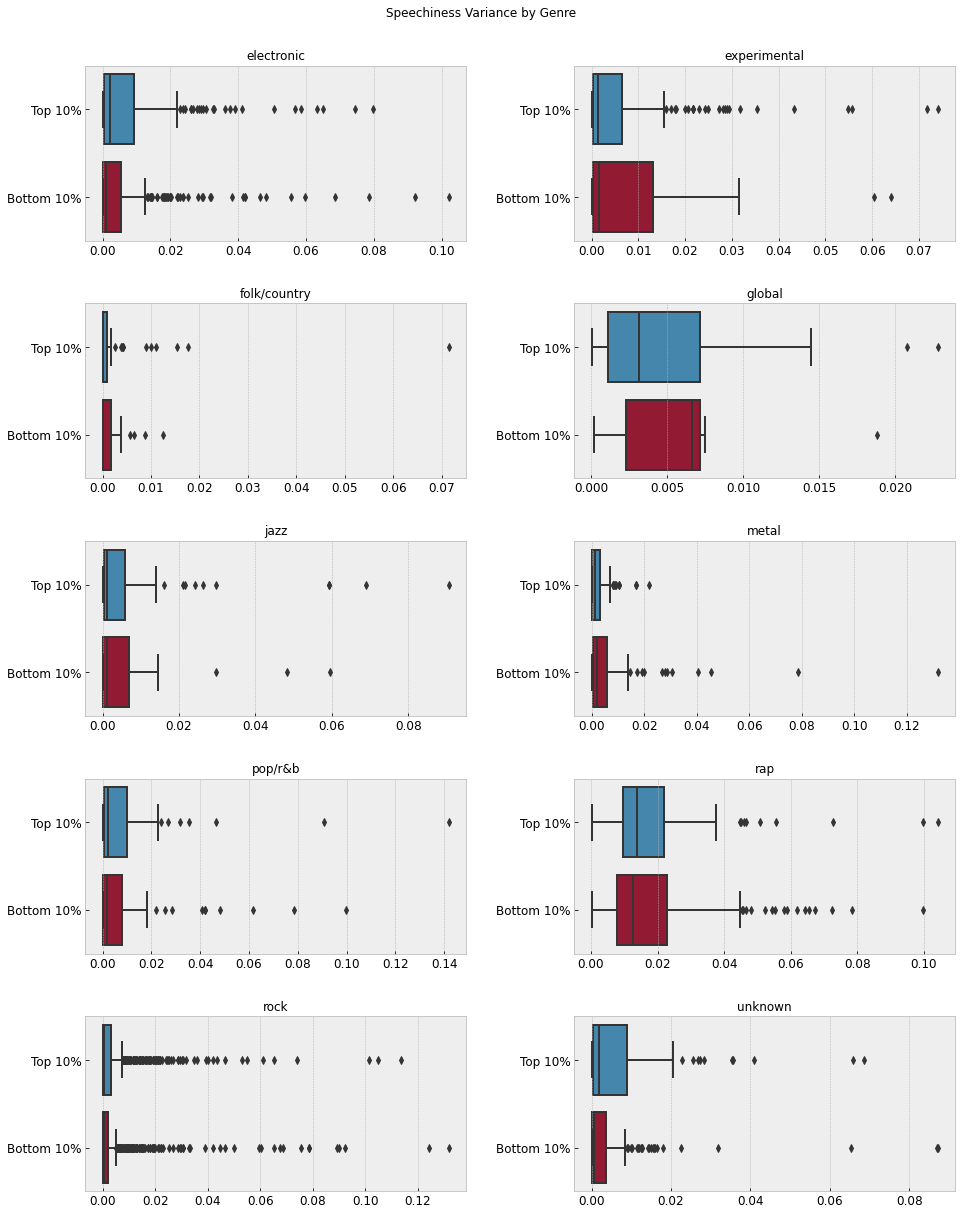

In [114]:
plot_numeric_grid('speechiness_var', top_album_df, bottom_album_df, 'Speechiness Variance by Genre')

In [115]:
speechiness_var_df = genre_comparison('speechiness_var', top_album_df, bottom_album_df)
speechiness_var_df

### Tempo
#### Mean

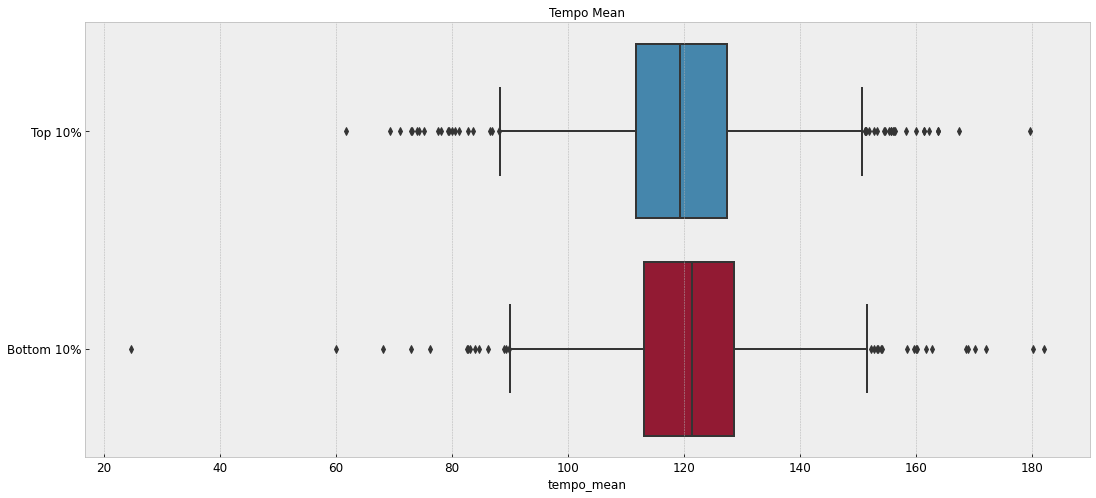

In [116]:
plot_numeric_col('tempo_mean', top_album_df, bottom_album_df, 'Tempo Mean')

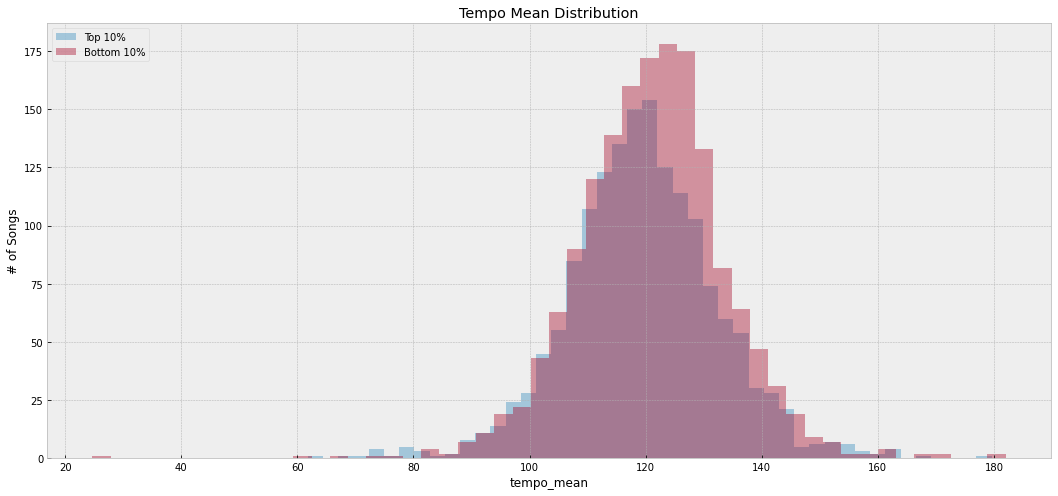

In [117]:
plot_histogram('tempo_mean', top_album_df, bottom_album_df, title='Tempo Mean Distribution')

In [118]:
var_comparison('tempo_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1195879.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.462
Top 10% Median:  119.30659166666666
Bottom 10% Median:  121.39465196078432
Number of Outliers (Top 10%):  8
Number of Outliers (Bottom 10%):  11


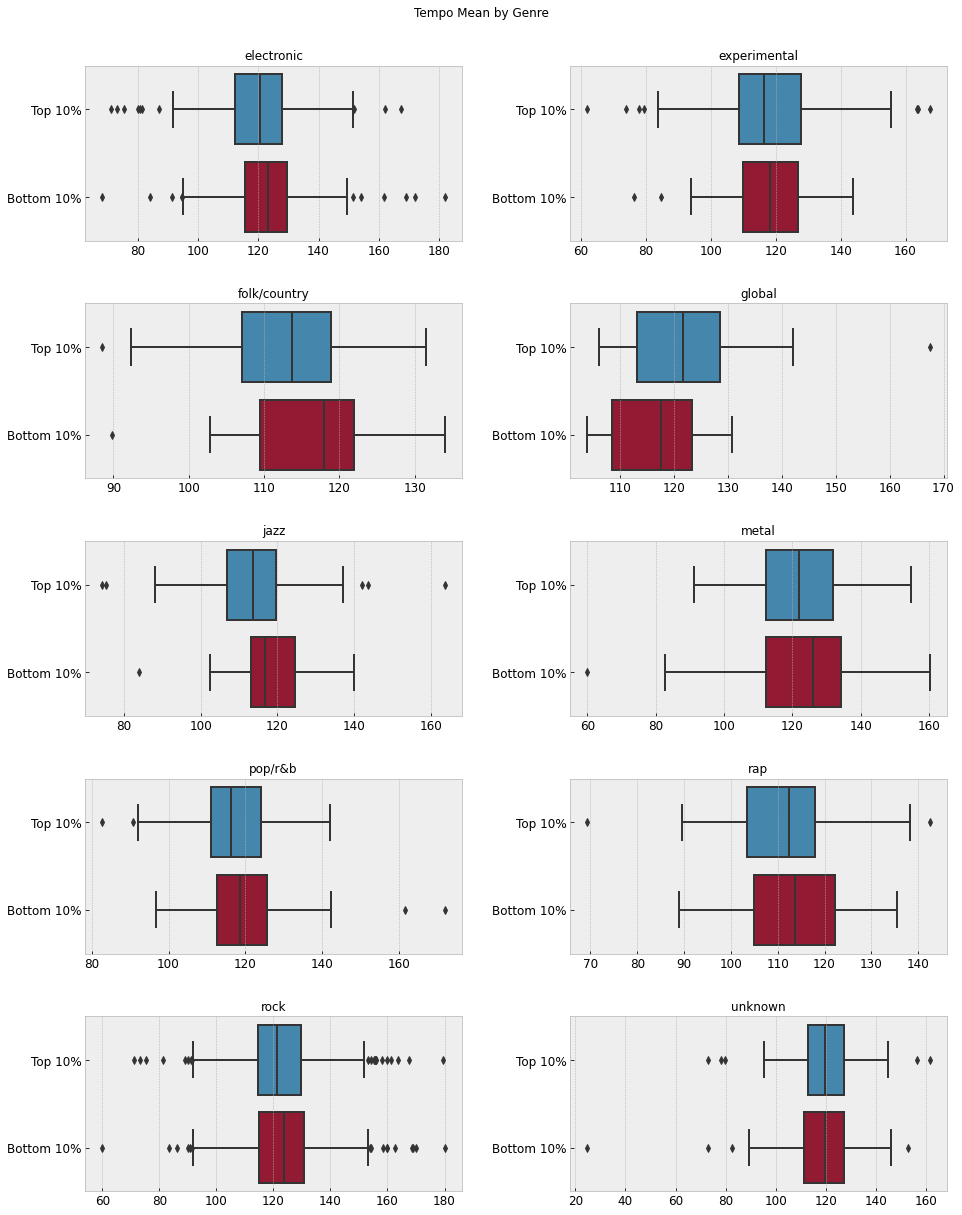

In [119]:
plot_numeric_grid('tempo_mean', top_album_df, bottom_album_df, 'Tempo Mean by Genre')

In [120]:
tempo_mean_df = genre_comparison('tempo_mean', top_album_df, bottom_album_df)
tempo_mean_df

#### Variance

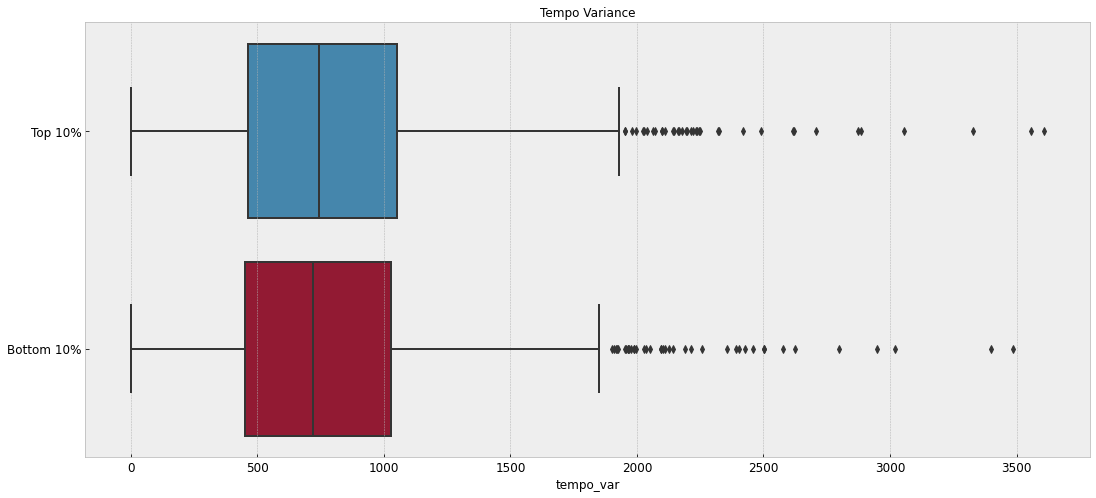

In [121]:
plot_numeric_col('tempo_var', top_album_df, bottom_album_df, 'Tempo Variance')

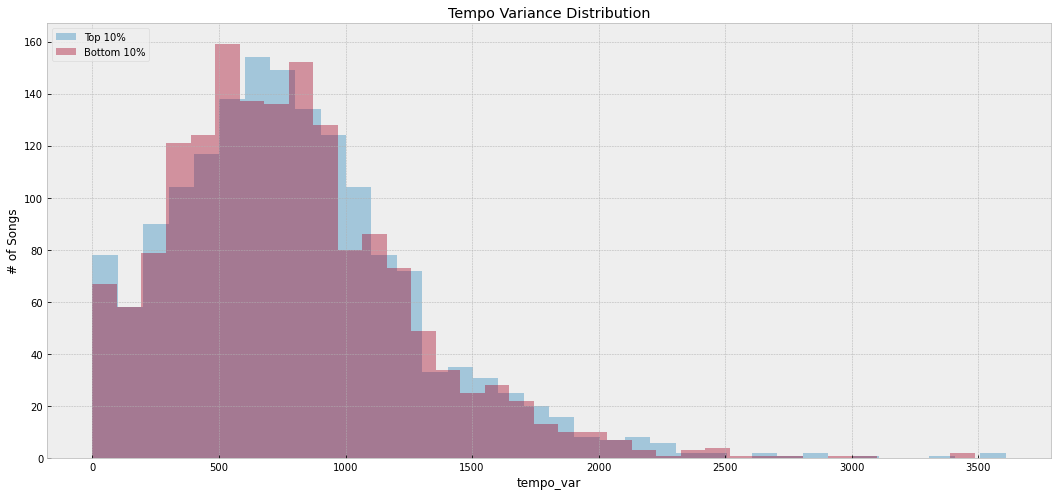

In [122]:
plot_histogram('tempo_var', top_album_df, bottom_album_df, title='Tempo Variance Distribution')

In [123]:
var_comparison('tempo_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1261674.0
p-value:  0.107
Significant:  False
Common Language Effect Size:  0.487
Top 10% Median:  743.8757342974747
Bottom 10% Median:  721.4640031388889
Number of Outliers (Top 10%):  13
Number of Outliers (Bottom 10%):  17


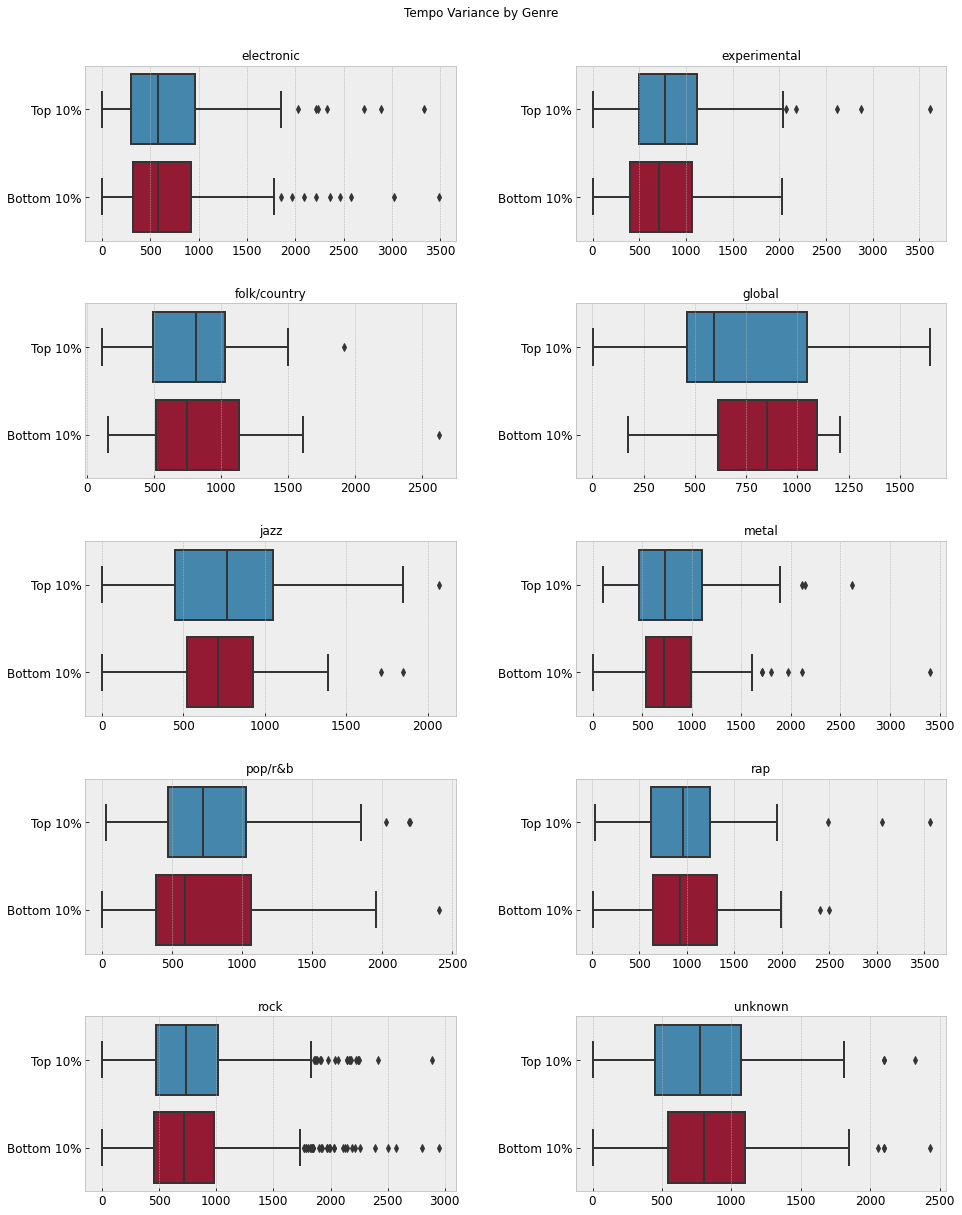

In [124]:
plot_numeric_grid('tempo_var', top_album_df, bottom_album_df, 'Tempo Variance by Genre')

In [125]:
tempo_var_df = genre_comparison('tempo_var', top_album_df, bottom_album_df)
tempo_var_df

### Valence
#### Mean

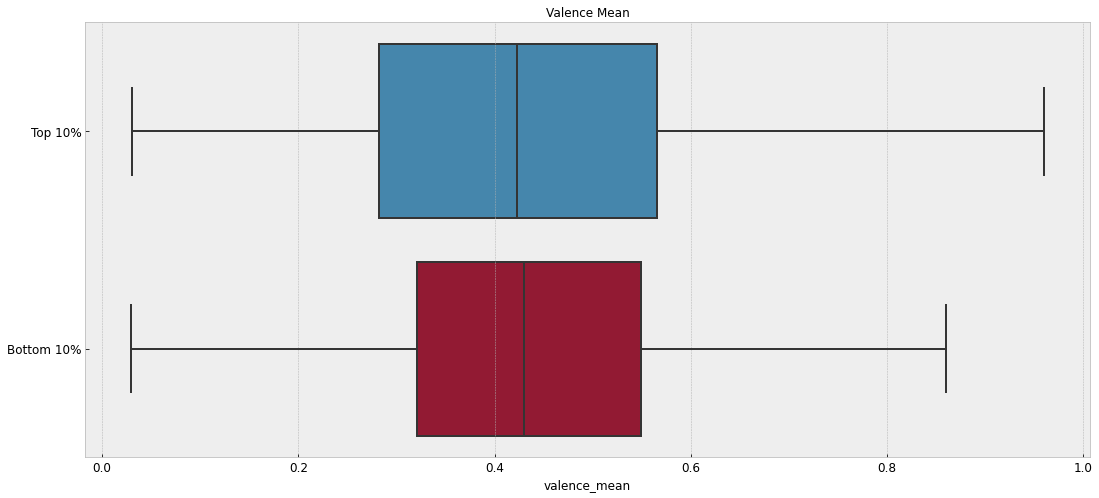

In [126]:
plot_numeric_col('valence_mean', top_album_df, bottom_album_df, 'Valence Mean')

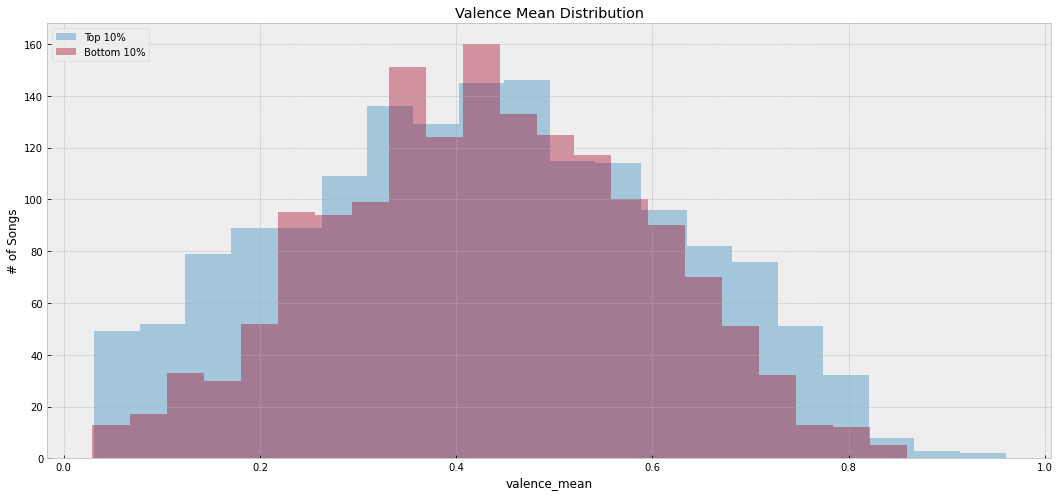

In [127]:
plot_histogram('valence_mean', top_album_df, bottom_album_df, title='Valence Mean Distribution')

In [128]:
var_comparison('valence_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1261381.5
p-value:  0.105
Significant:  False
Common Language Effect Size:  0.487
Top 10% Median:  0.4230714285714285
Bottom 10% Median:  0.4304958333333333
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  0


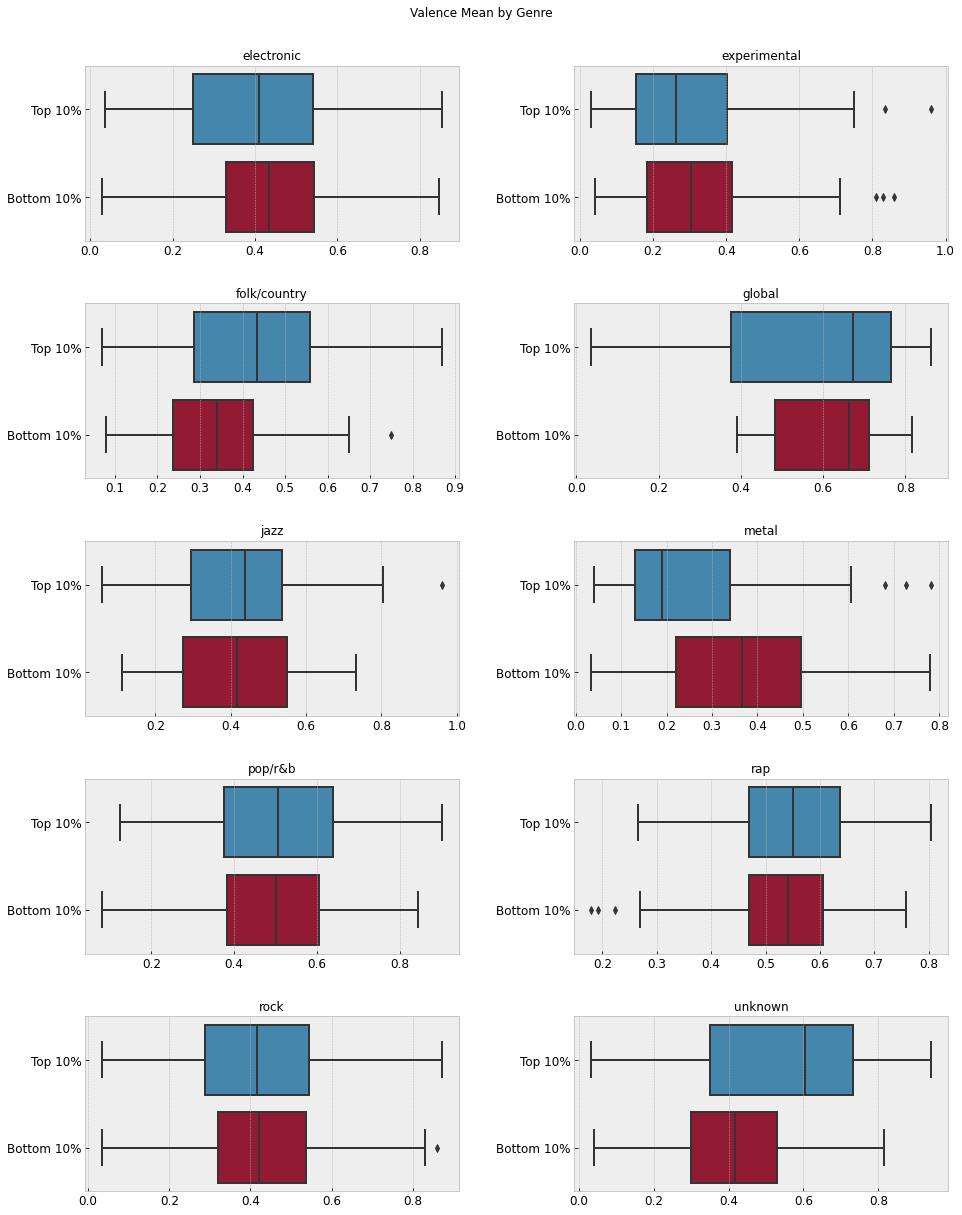

In [129]:
plot_numeric_grid('valence_mean', top_album_df, bottom_album_df, 'Valence Mean by Genre')

In [130]:
valence_mean_df = genre_comparison('valence_mean', top_album_df, bottom_album_df)
valence_mean_df

#### Variance

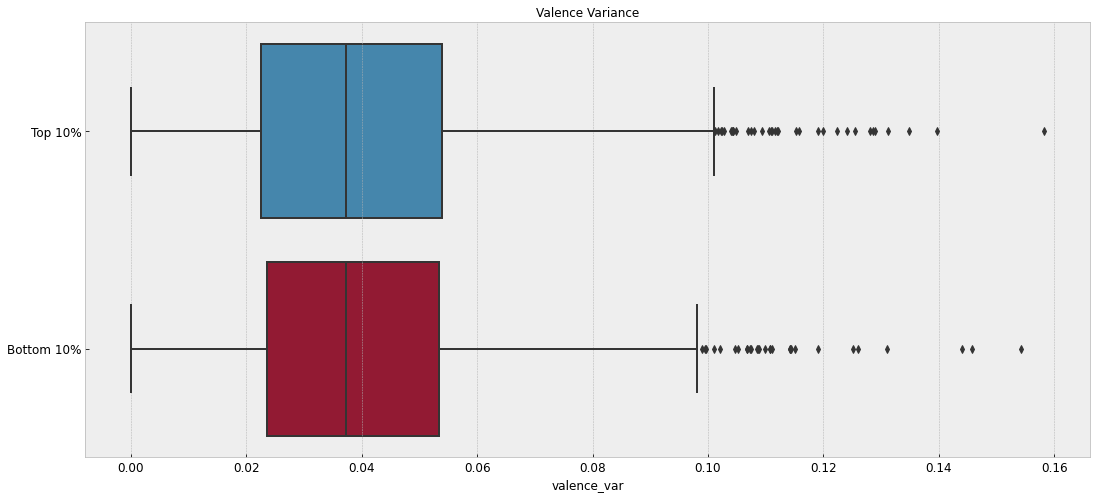

In [131]:
plot_numeric_col('valence_var', top_album_df, bottom_album_df, 'Valence Variance')

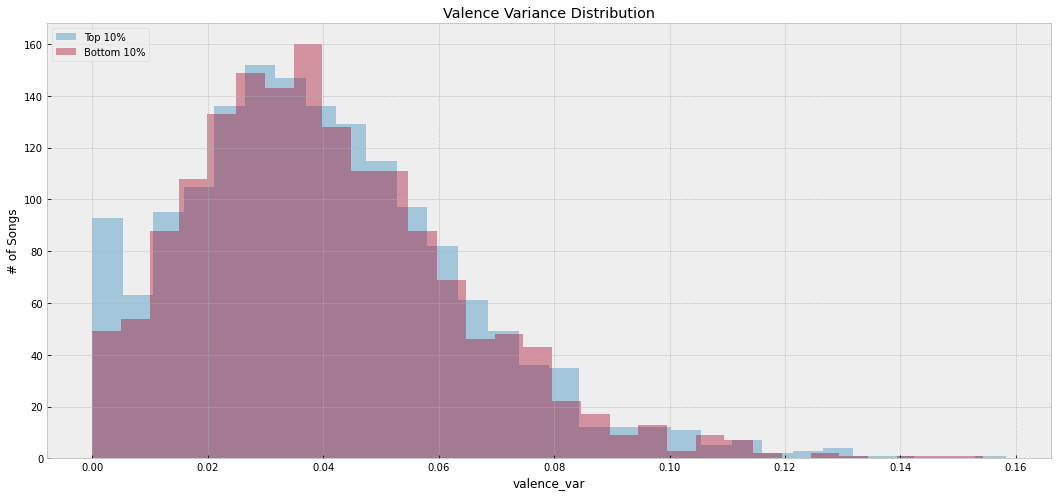

In [132]:
plot_histogram('valence_var', top_album_df, bottom_album_df, title='Valence Variance Distribution')

In [133]:
var_comparison('valence_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1279396.0
p-value:  0.284
Significant:  False
Common Language Effect Size:  0.494
Top 10% Median:  0.03719836666666667
Bottom 10% Median:  0.03721695642156862
Number of Outliers (Top 10%):  14
Number of Outliers (Bottom 10%):  15


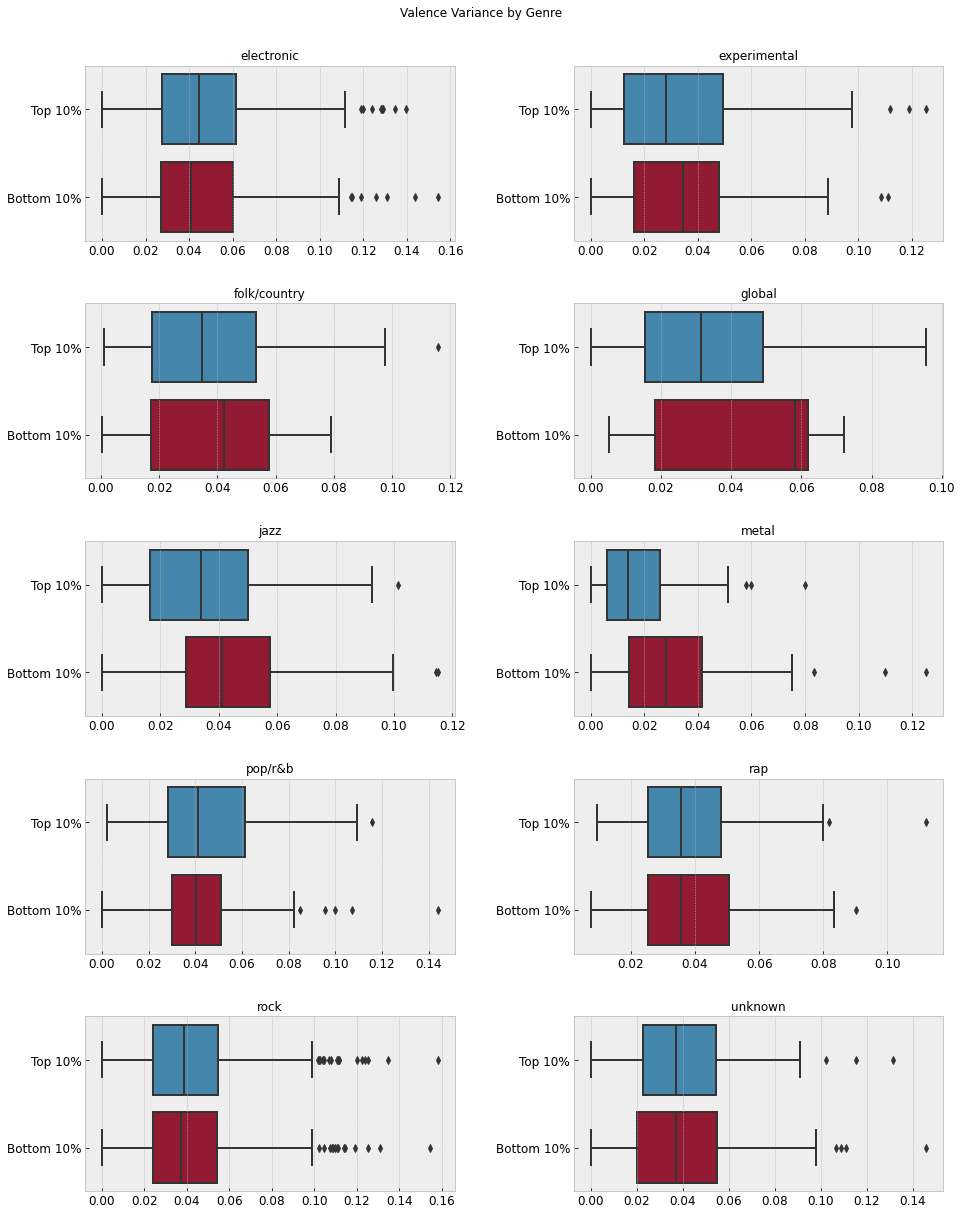

In [134]:
plot_numeric_grid('valence_var', top_album_df, bottom_album_df, 'Valence Variance by Genre')

In [135]:
valence_var_df = genre_comparison('valence_var', top_album_df, bottom_album_df)
valence_var_df

### Popularity
#### Mean

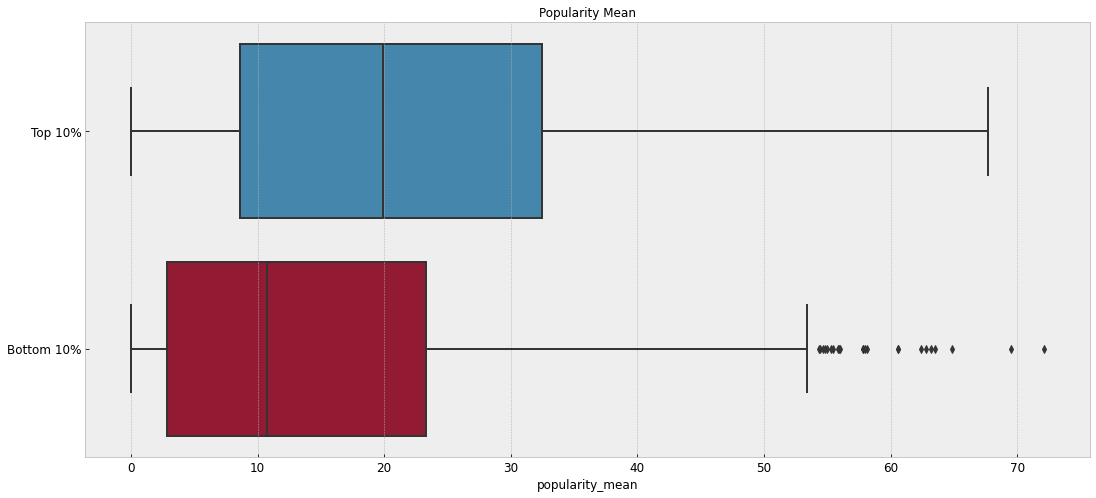

In [136]:
plot_numeric_col('popularity_mean', top_album_df, bottom_album_df, 'Popularity Mean')

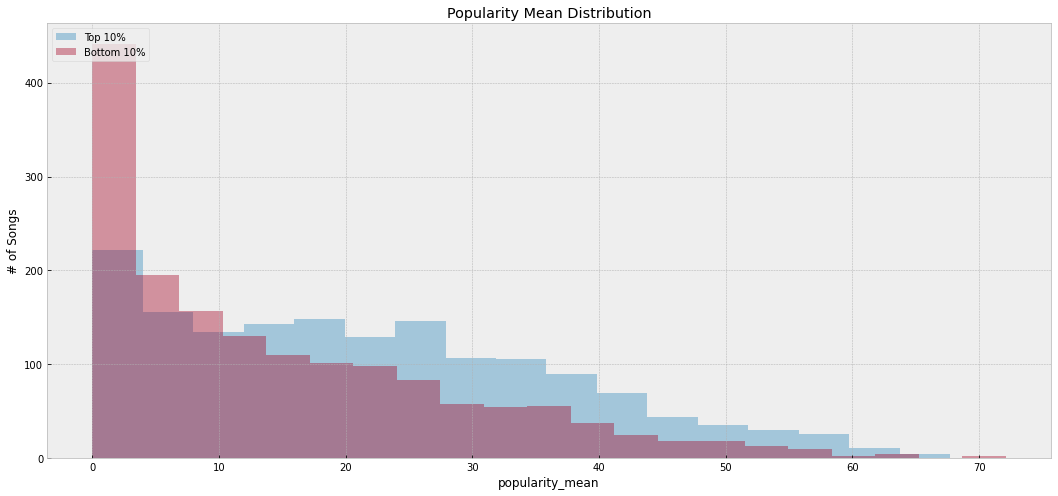

In [137]:
plot_histogram('popularity_mean', top_album_df, bottom_album_df, title='Popularity Mean Distribution')

In [138]:
var_comparison('popularity_mean', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  928732.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.359
Top 10% Median:  19.88486842105263
Bottom 10% Median:  10.741666666666667
Number of Outliers (Top 10%):  0
Number of Outliers (Bottom 10%):  13


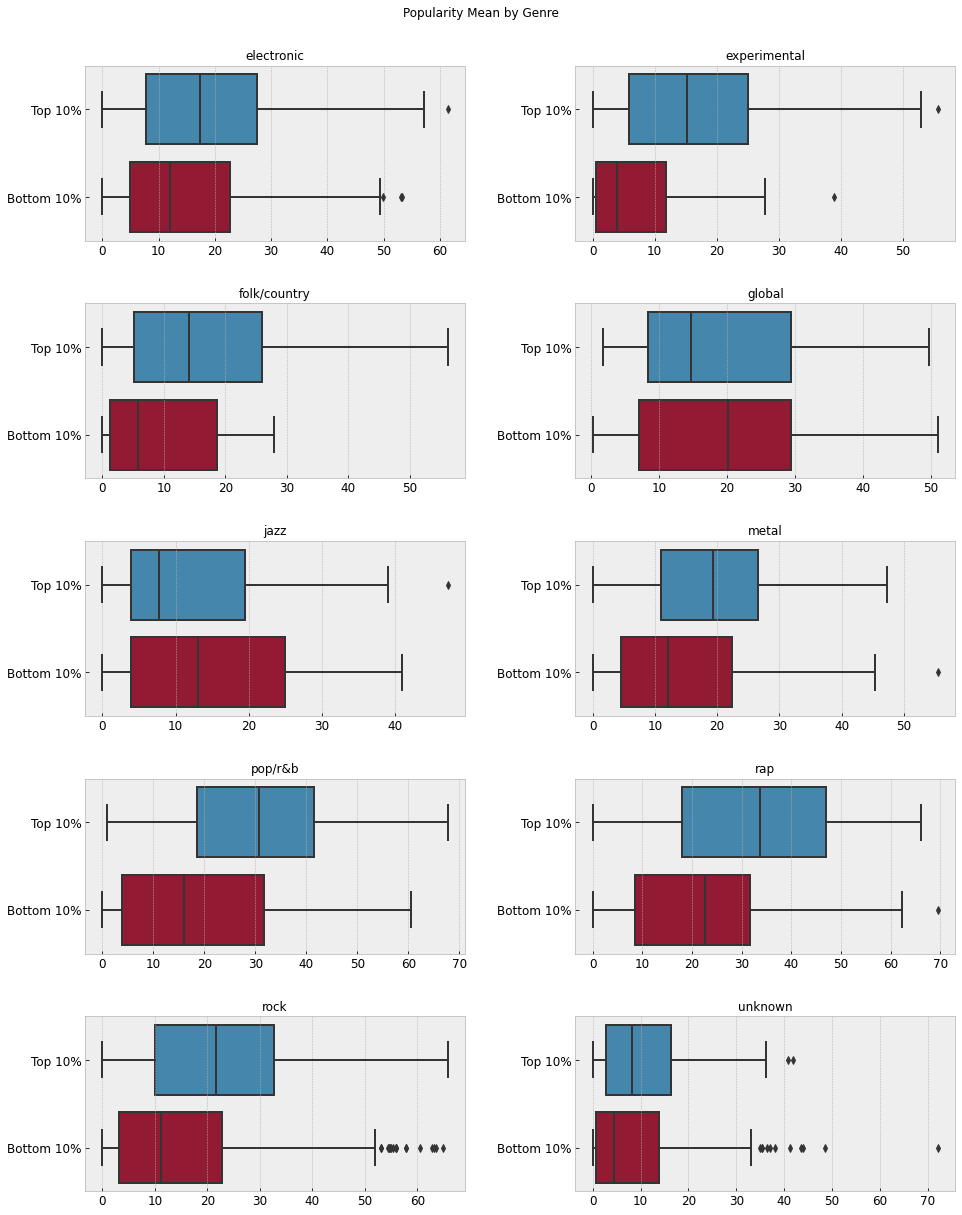

In [139]:
plot_numeric_grid('popularity_mean', top_album_df, bottom_album_df, 'Popularity Mean by Genre')

In [140]:
popularity_mean_df = genre_comparison('popularity_mean', top_album_df, bottom_album_df)
popularity_mean_df

#### Variance

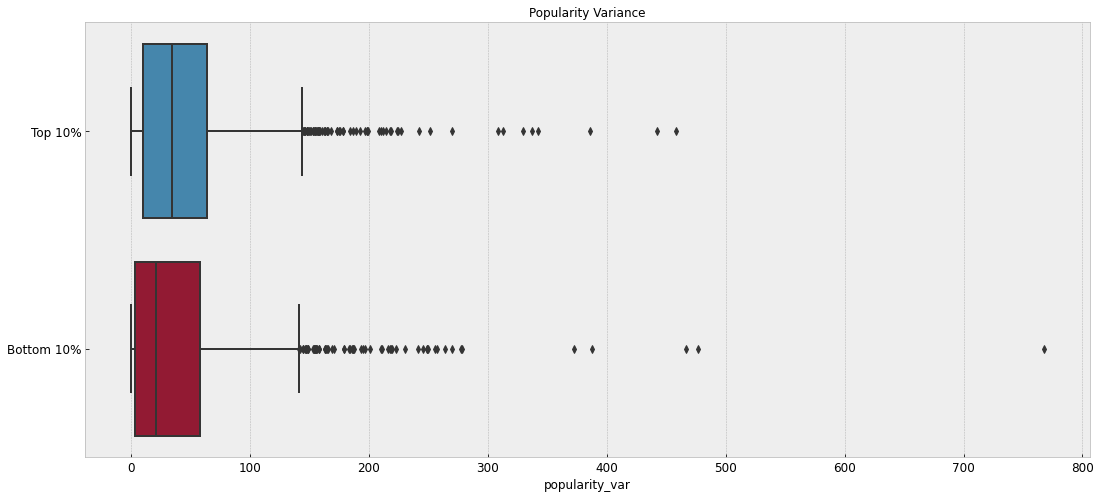

In [141]:
plot_numeric_col('popularity_var', top_album_df, bottom_album_df, 'Popularity Variance')

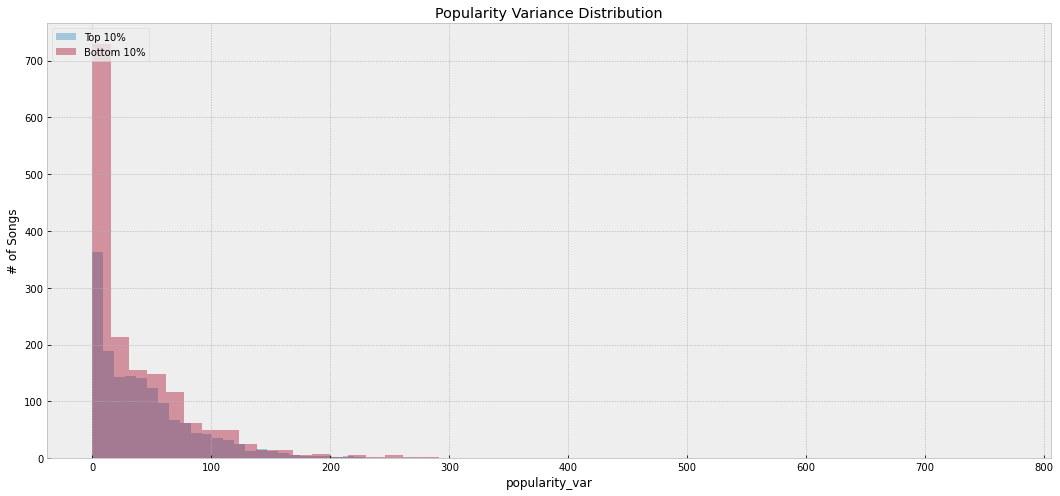

In [142]:
plot_histogram('popularity_var', top_album_df, bottom_album_df, title='Popularity Variance Distribution')

In [143]:
var_comparison('popularity_var', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1084861.5
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.419
Top 10% Median:  34.84516627163686
Bottom 10% Median:  20.839393939393943
Number of Outliers (Top 10%):  25
Number of Outliers (Bottom 10%):  25


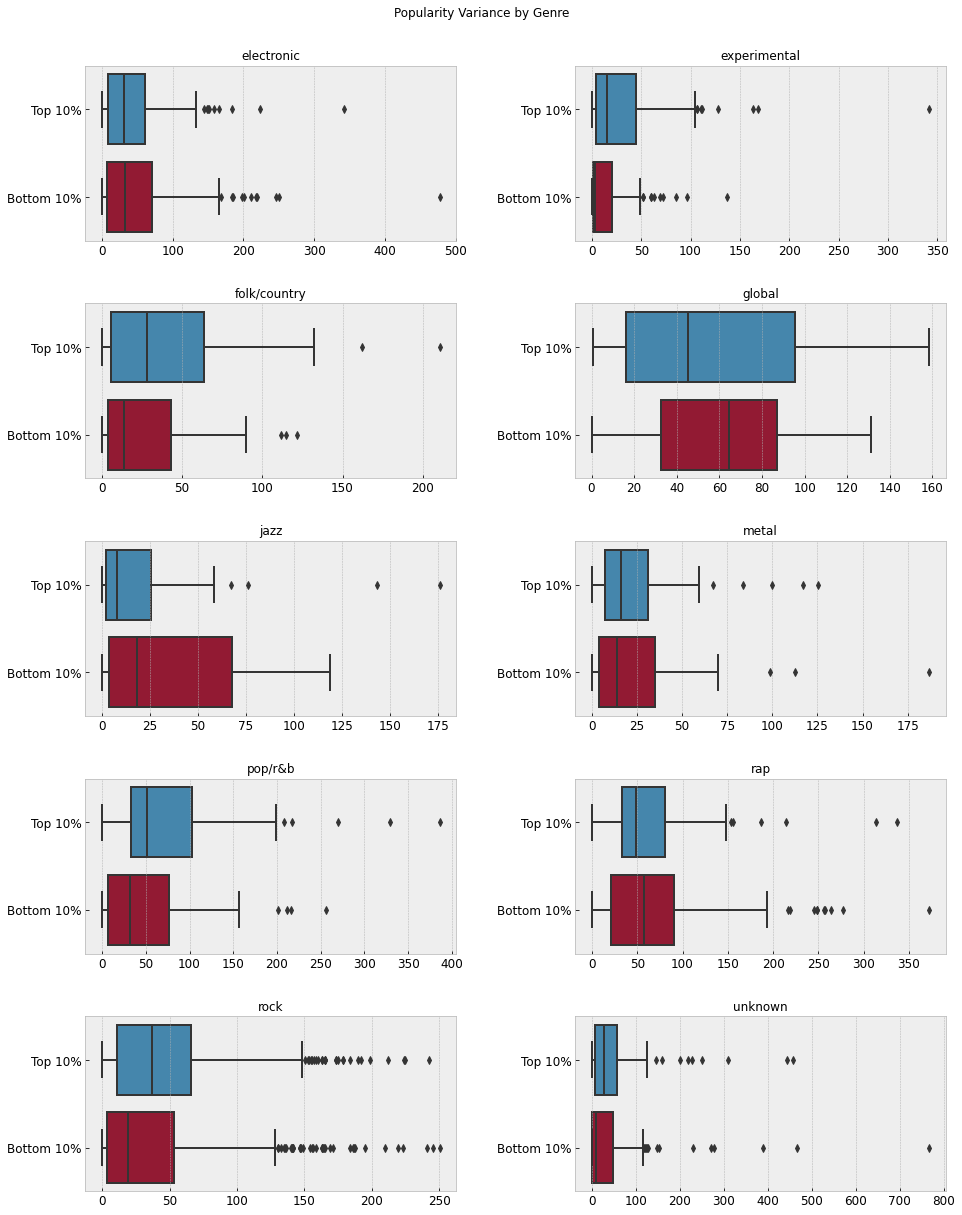

In [144]:
plot_numeric_grid('popularity_var', top_album_df, bottom_album_df, 'Popularity Variance by Genre')

In [145]:
popularity_var_df = genre_comparison('popularity_var', top_album_df, bottom_album_df)
popularity_var_df

### Number of Tracks

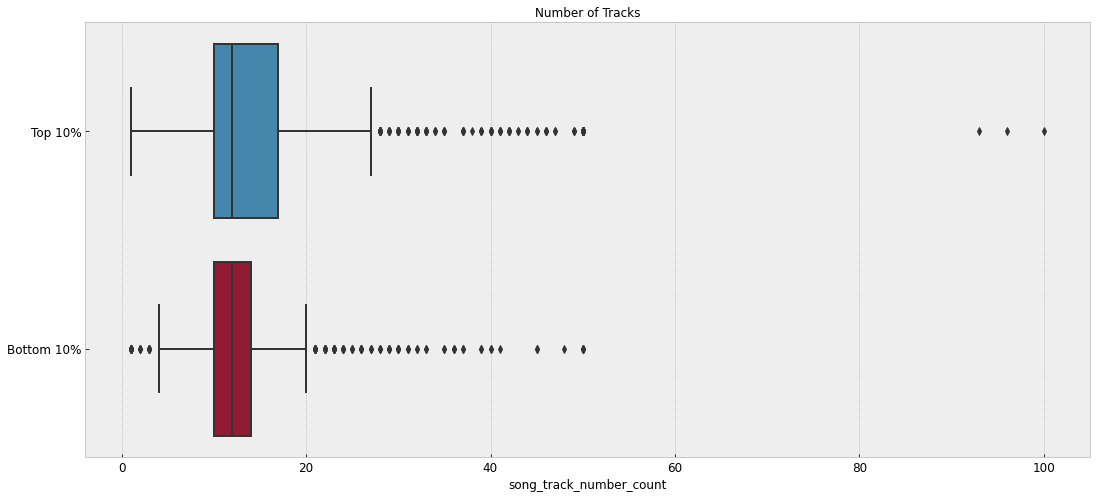

In [146]:
plot_numeric_col('song_track_number_count', top_album_df, bottom_album_df, 'Number of Tracks')

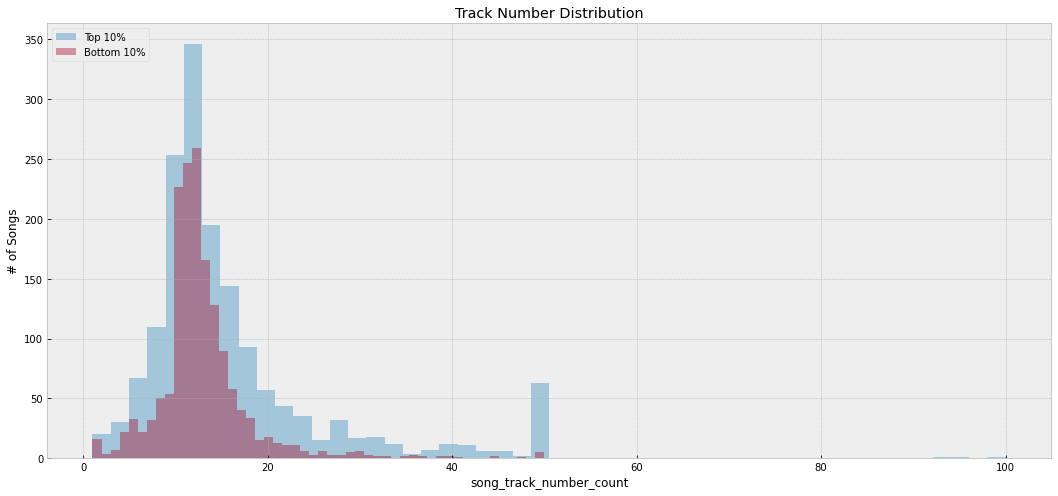

In [147]:
plot_histogram('song_track_number_count', top_album_df, bottom_album_df, title='Track Number Distribution')

In [148]:
var_comparison('song_track_number_count', top_album_df, bottom_album_df)

N1 (Top 10%): 1602
N2 (Bottom 10%): 1616
U-value:  1153126.0
p-value:  0.0
Significant:  True
Common Language Effect Size:  0.445
Top 10% Median:  12.0
Bottom 10% Median:  12.0
Number of Outliers (Top 10%):  66
Number of Outliers (Bottom 10%):  33


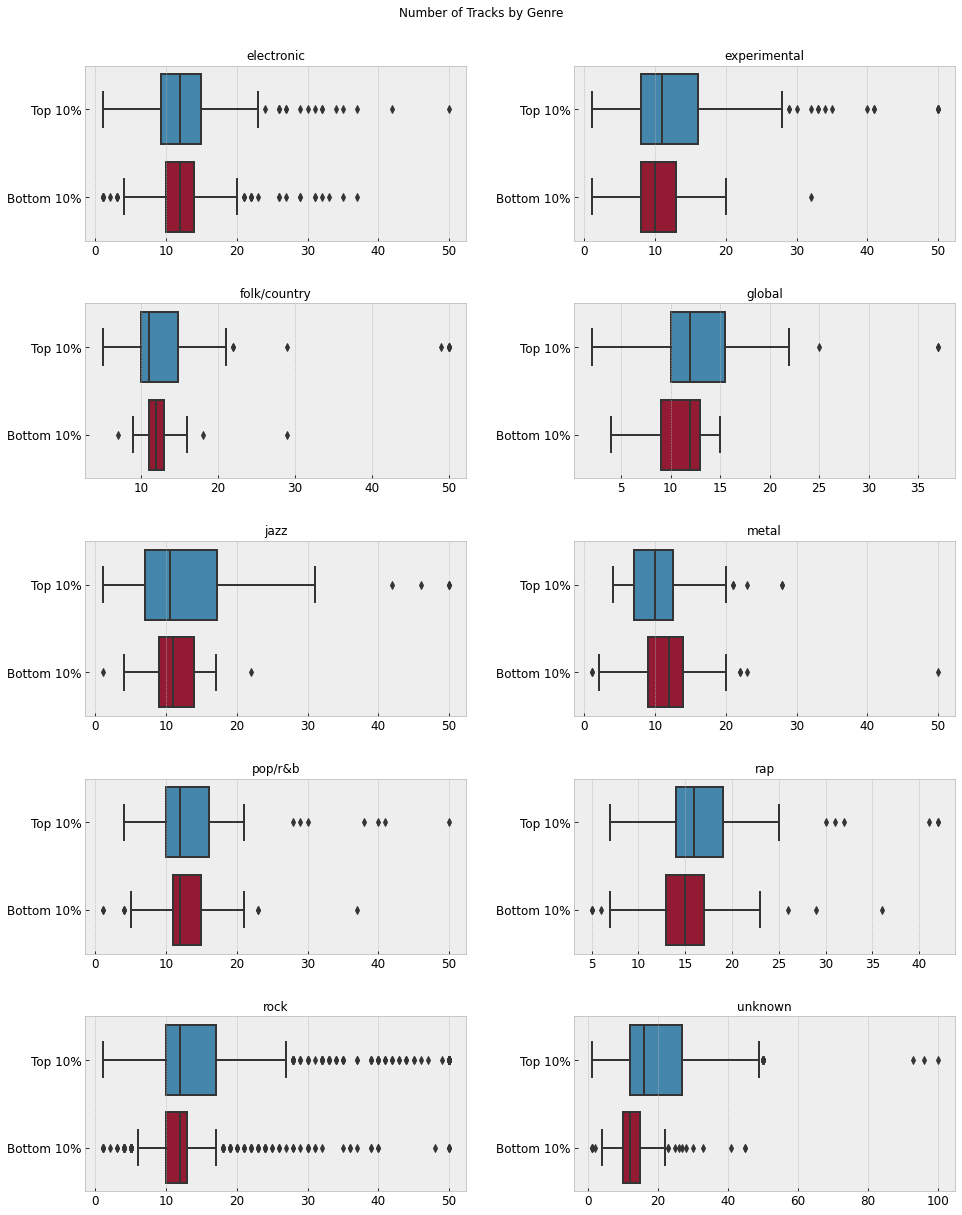

In [149]:
plot_numeric_grid('song_track_number_count', top_album_df, bottom_album_df, 'Number of Tracks by Genre')

In [150]:
number_of_tracks_df = genre_comparison('song_track_number_count', top_album_df, bottom_album_df)
number_of_tracks_df

# Lyrics
Albums with mean lyric lines = 0 will be removed from the analysis.

In [151]:
top_album_lyrics = top_album_df.loc[top_album_df['lyric_lines_mean'] > 0]
bottom_album_lyrics = bottom_album_df.loc[bottom_album_df['lyric_lines_mean'] > 0]

### Lyric Lines
#### Mean

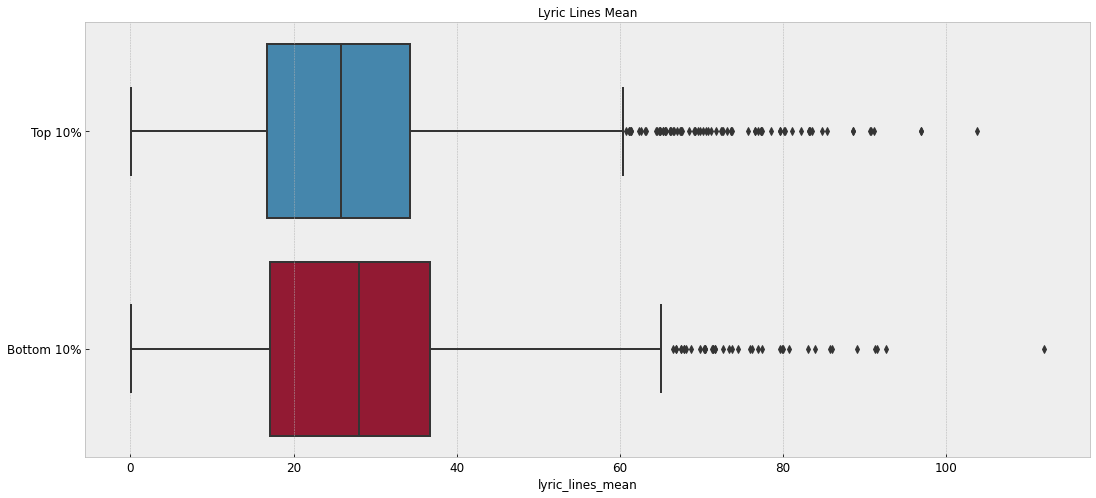

In [152]:
plot_numeric_col('lyric_lines_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Lines Mean')

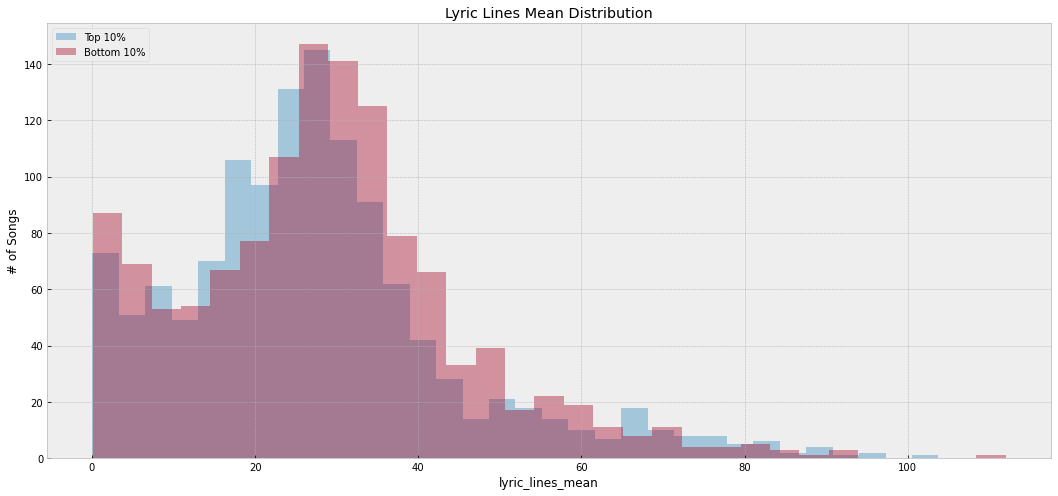

In [153]:
plot_histogram('lyric_lines_mean', top_album_lyrics, bottom_album_lyrics, title='Lyric Lines Mean Distribution')

In [154]:
var_comparison('lyric_lines_mean', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  741718.5
p-value:  0.002
Significant:  True
Common Language Effect Size:  0.467
Top 10% Median:  25.86607142857143
Bottom 10% Median:  28.076923076923077
Number of Outliers (Top 10%):  20
Number of Outliers (Bottom 10%):  13


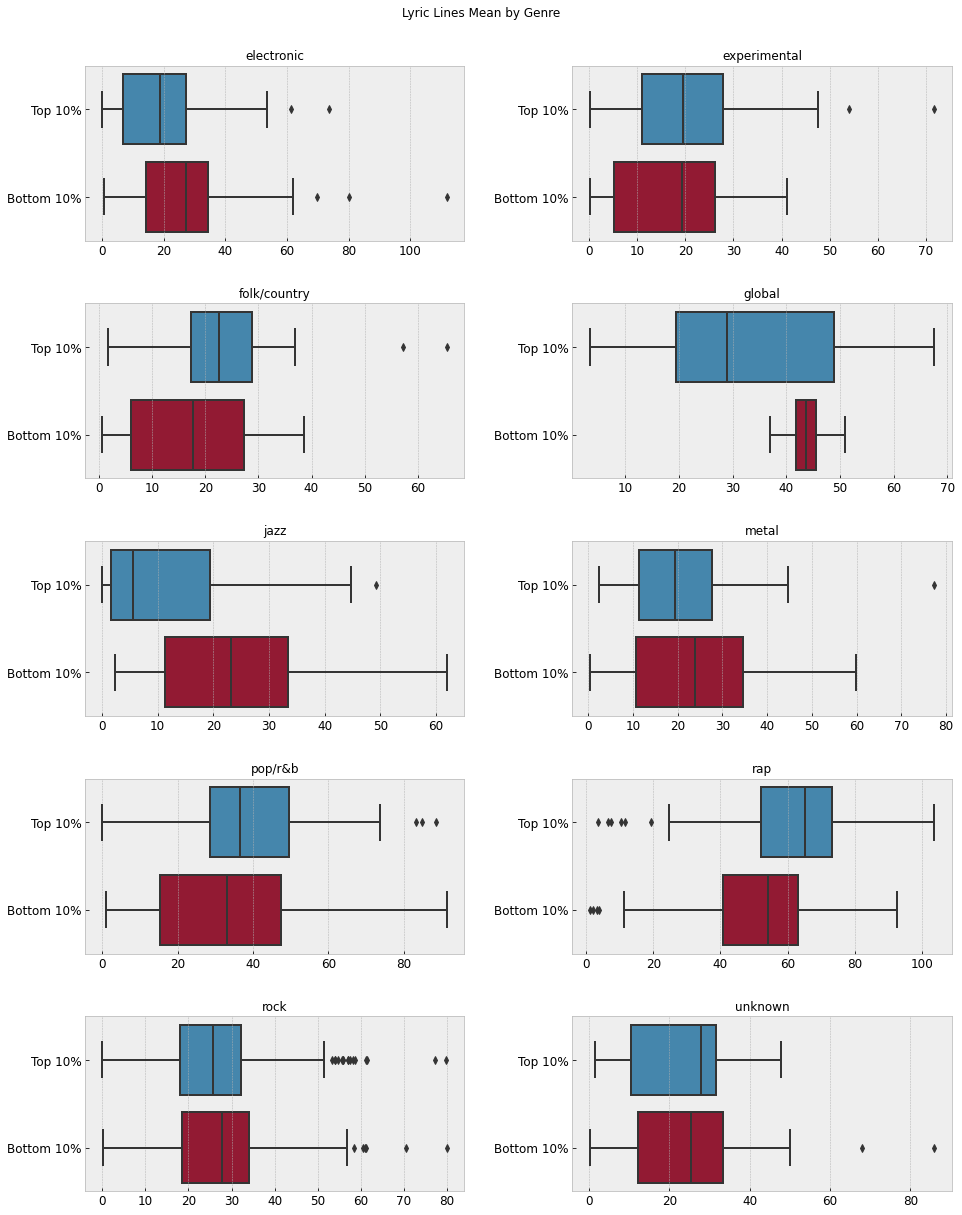

In [155]:
plot_numeric_grid('lyric_lines_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Lines Mean by Genre')

In [156]:
lyric_lines_mean_df = genre_comparison('lyric_lines_mean', top_album_lyrics, bottom_album_lyrics)
lyric_lines_mean_df

#### Variance

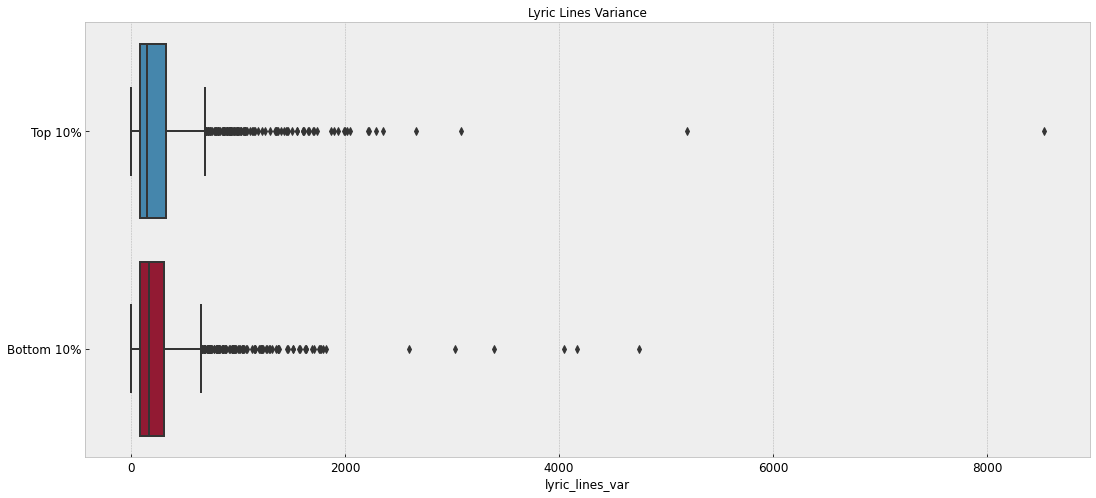

In [157]:
plot_numeric_col('lyric_lines_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Lines Variance')

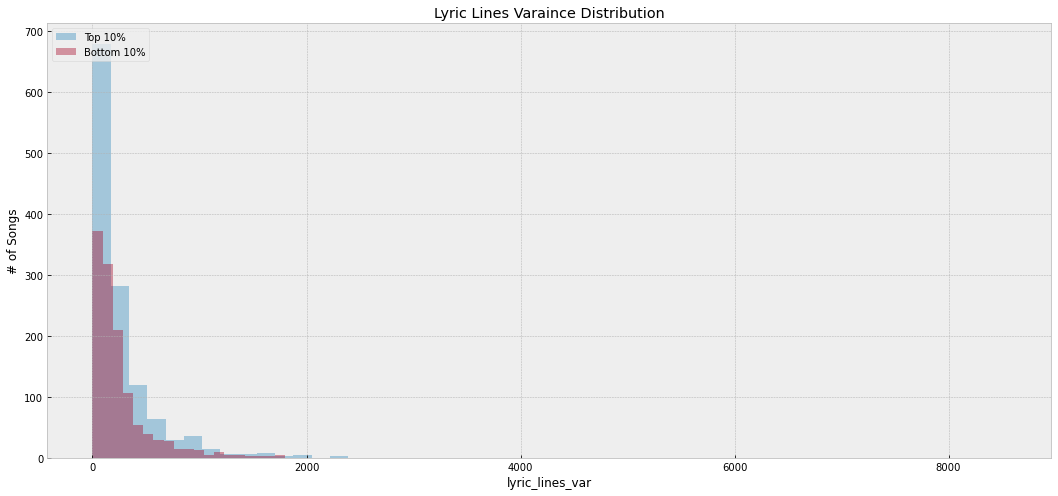

In [158]:
plot_histogram('lyric_lines_var', top_album_lyrics, bottom_album_lyrics, title='Lyric Lines Varaince Distribution')

In [159]:
var_comparison('lyric_lines_var', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  790218.5
p-value:  0.409
Significant:  False
Common Language Effect Size:  0.497
Top 10% Median:  155.4431623931624
Bottom 10% Median:  168.45454545454544
Number of Outliers (Top 10%):  21
Number of Outliers (Bottom 10%):  22


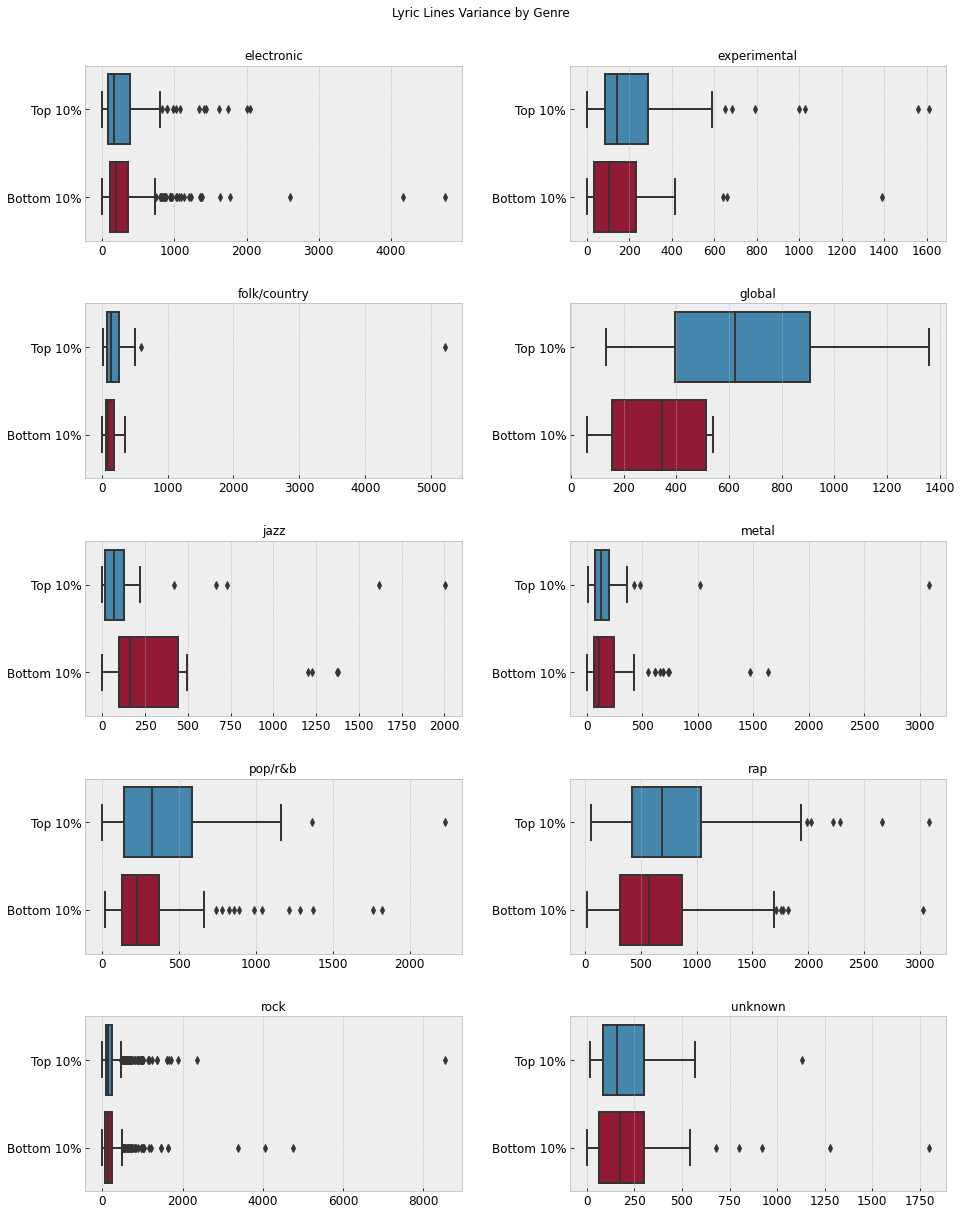

In [160]:
plot_numeric_grid('lyric_lines_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Lines Variance by Genre')

In [161]:
lyric_lines_var_df = genre_comparison('lyric_lines_var', top_album_lyrics, bottom_album_lyrics)
lyric_lines_var_df

### Lyric Words
#### Mean

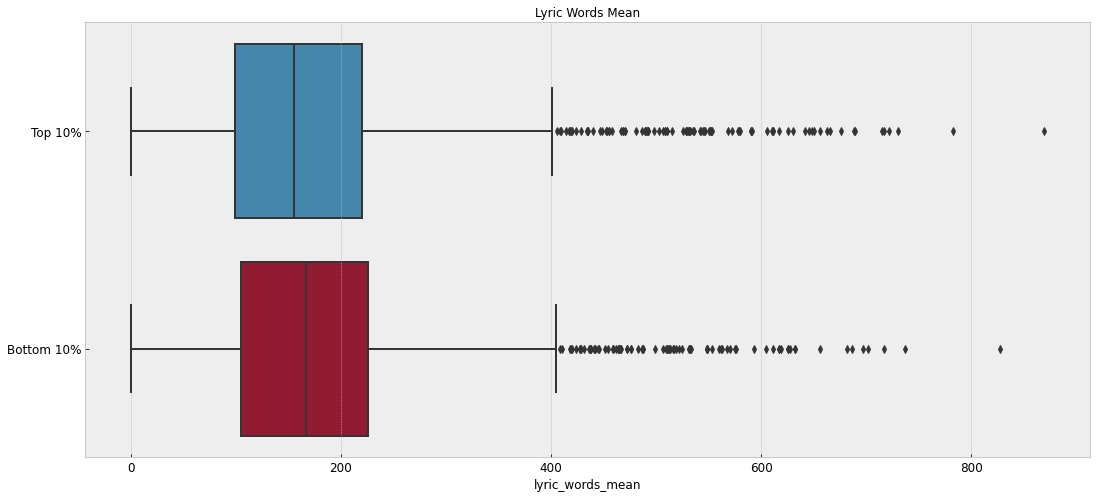

In [162]:
plot_numeric_col('lyric_words_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Words Mean')

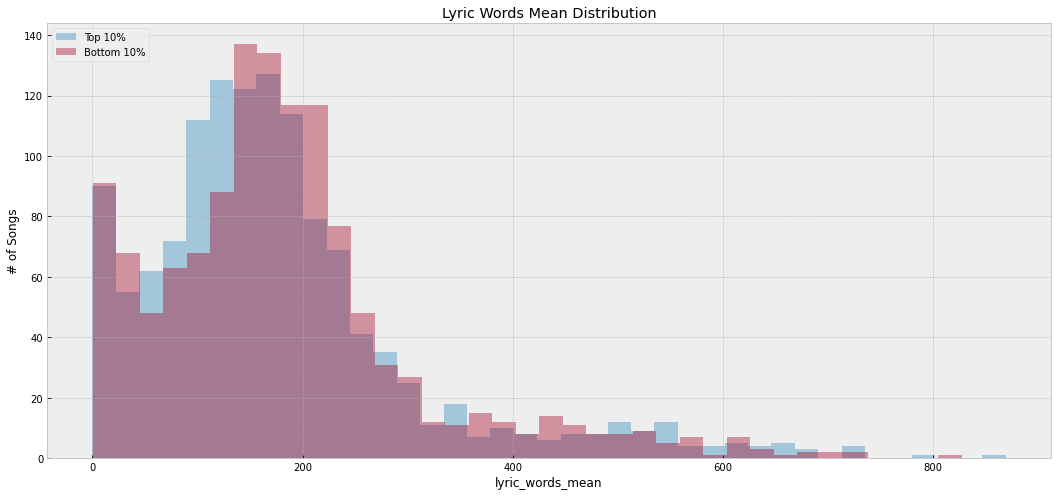

In [163]:
plot_histogram('lyric_words_mean', top_album_lyrics, bottom_album_lyrics, title='Lyric Words Mean Distribution')

In [164]:
var_comparison('lyric_words_mean', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  754079.5
p-value:  0.014
Significant:  True
Common Language Effect Size:  0.475
Top 10% Median:  155.25
Bottom 10% Median:  166.8
Number of Outliers (Top 10%):  29
Number of Outliers (Bottom 10%):  23


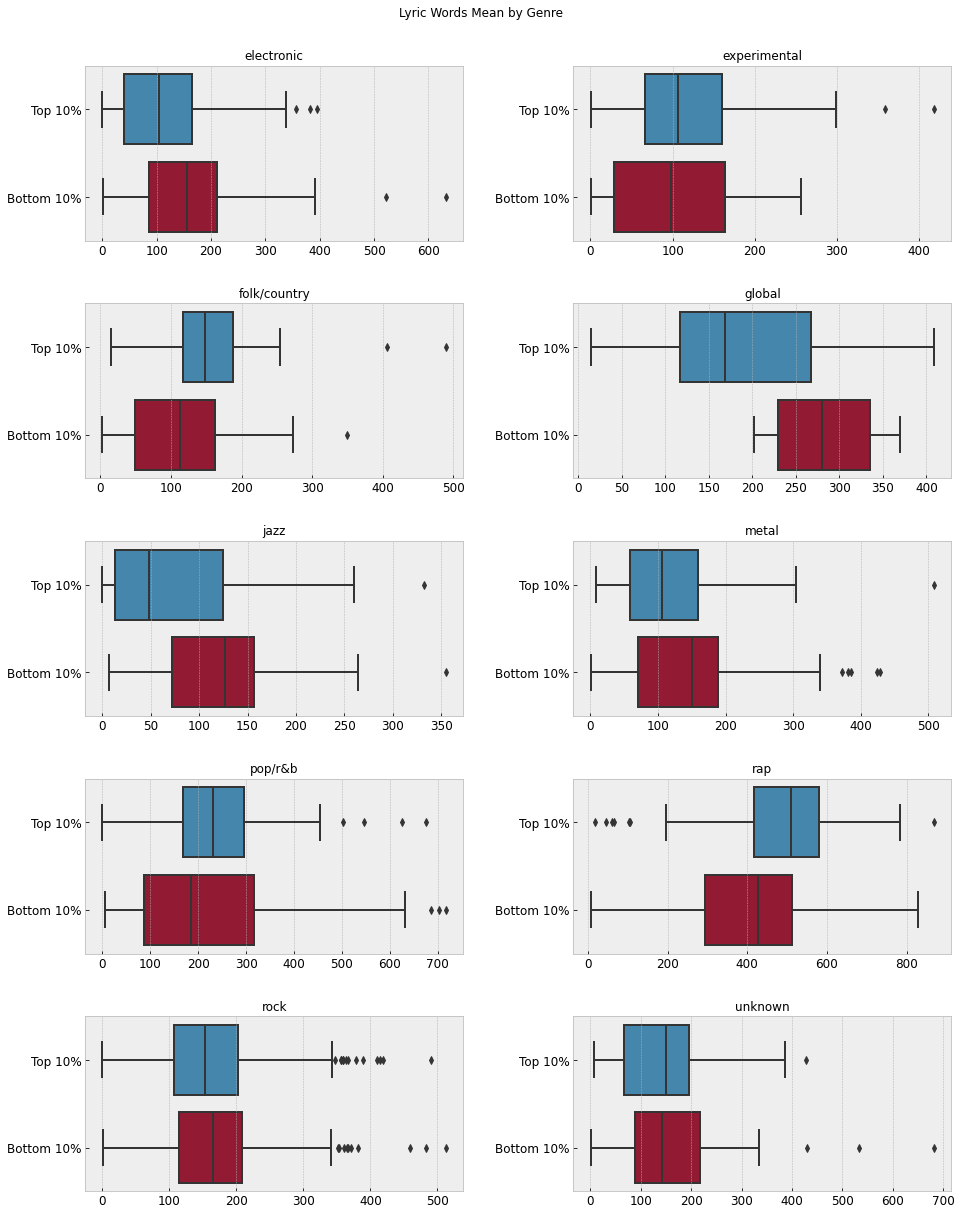

In [165]:
plot_numeric_grid('lyric_words_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Words Mean by Genre')

In [166]:
lyric_words_mean_df = genre_comparison('lyric_words_mean', top_album_lyrics, bottom_album_lyrics)
lyric_words_mean_df

#### Variance

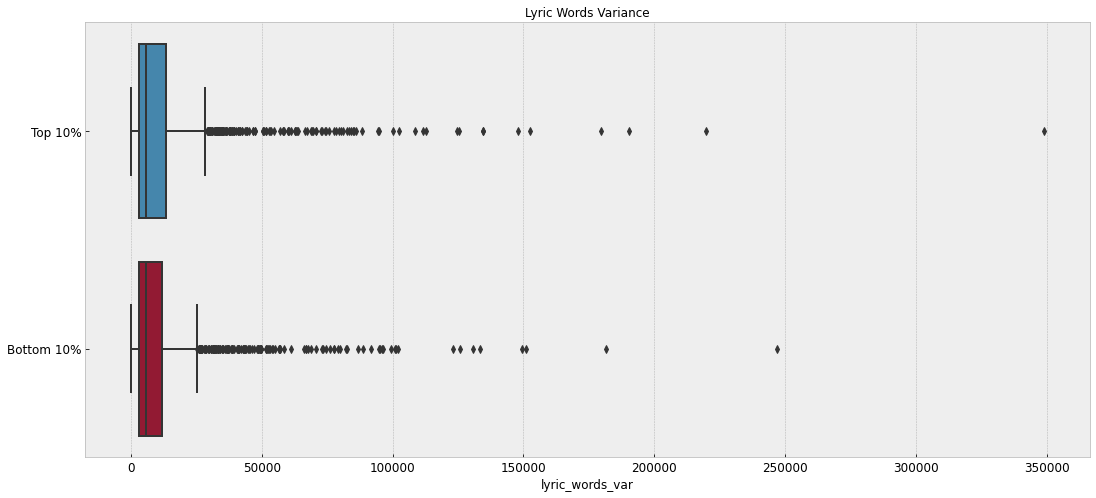

In [167]:
plot_numeric_col('lyric_words_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Words Variance')

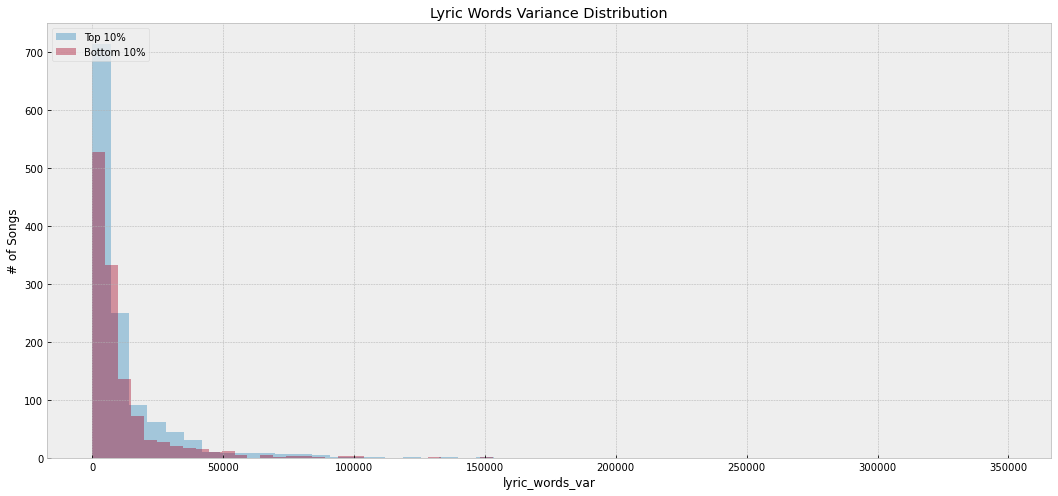

In [168]:
plot_histogram('lyric_words_var', top_album_lyrics, bottom_album_lyrics, title='Lyric Words Variance Distribution')

In [169]:
var_comparison('lyric_words_var', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  788864.0
p-value:  0.381
Significant:  False
Common Language Effect Size:  0.497
Top 10% Median:  5918.623931623932
Bottom 10% Median:  5932.386363636361
Number of Outliers (Top 10%):  26
Number of Outliers (Bottom 10%):  30


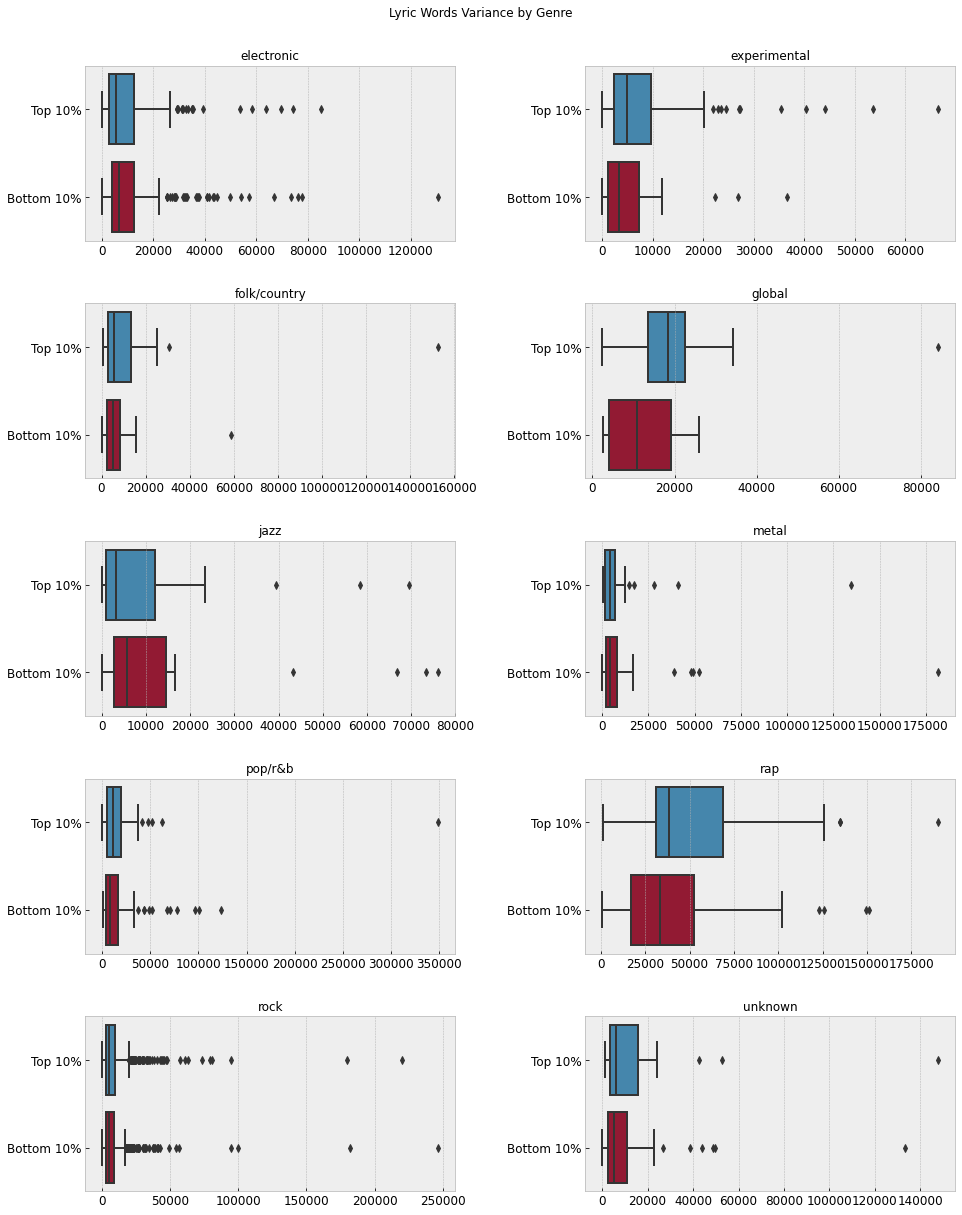

In [170]:
plot_numeric_grid('lyric_words_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Words Variance by Genre')

In [171]:
lyric_words_var_df = genre_comparison('lyric_words_var', top_album_lyrics, bottom_album_lyrics)
lyric_words_var_df

### Lyric Unique Words
#### Mean

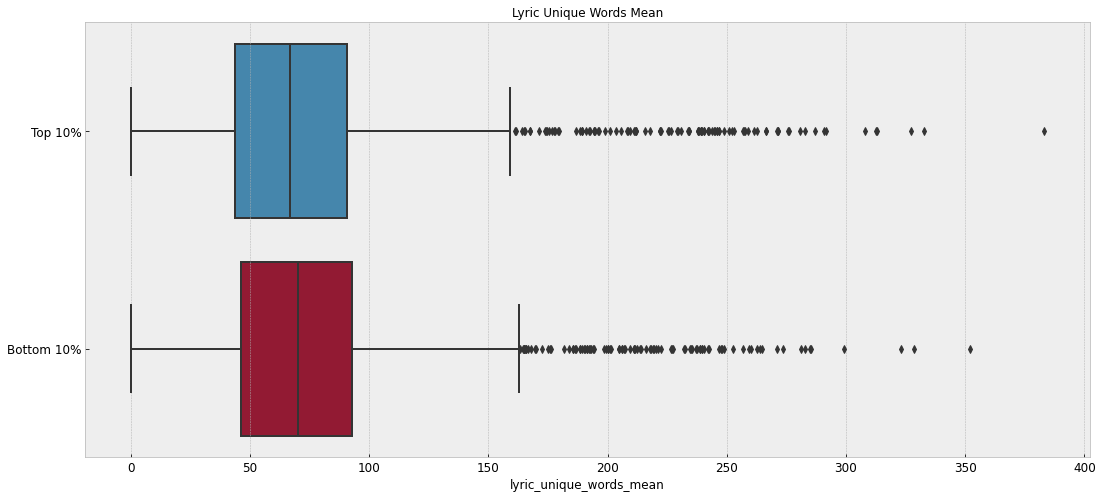

In [172]:
plot_numeric_col('lyric_unique_words_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Unique Words Mean')

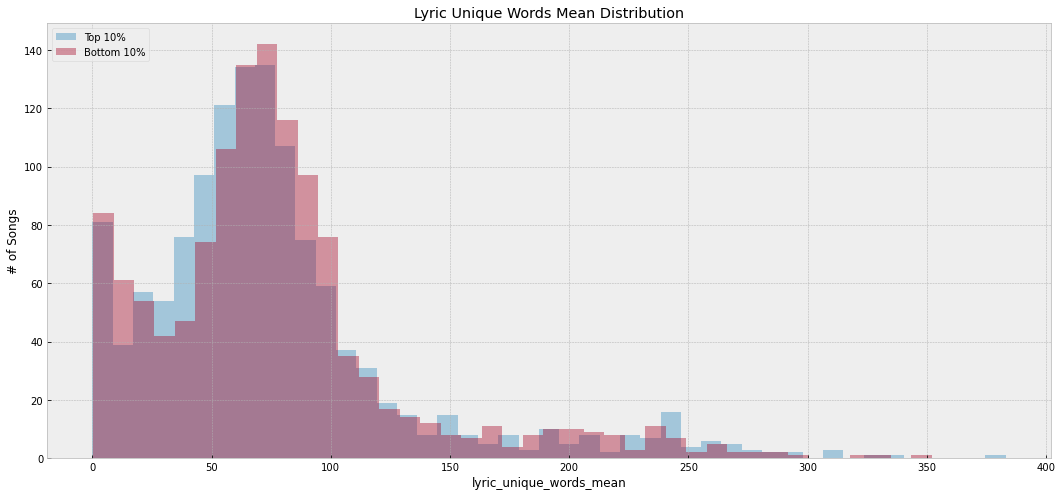

In [173]:
plot_histogram('lyric_unique_words_mean', top_album_lyrics, bottom_album_lyrics, title='Lyric Unique Words Mean Distribution')

In [174]:
var_comparison('lyric_unique_words_mean', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  765626.5
p-value:  0.058
Significant:  False
Common Language Effect Size:  0.482
Top 10% Median:  66.72222222222223
Bottom 10% Median:  70.33333333333333
Number of Outliers (Top 10%):  30
Number of Outliers (Bottom 10%):  28


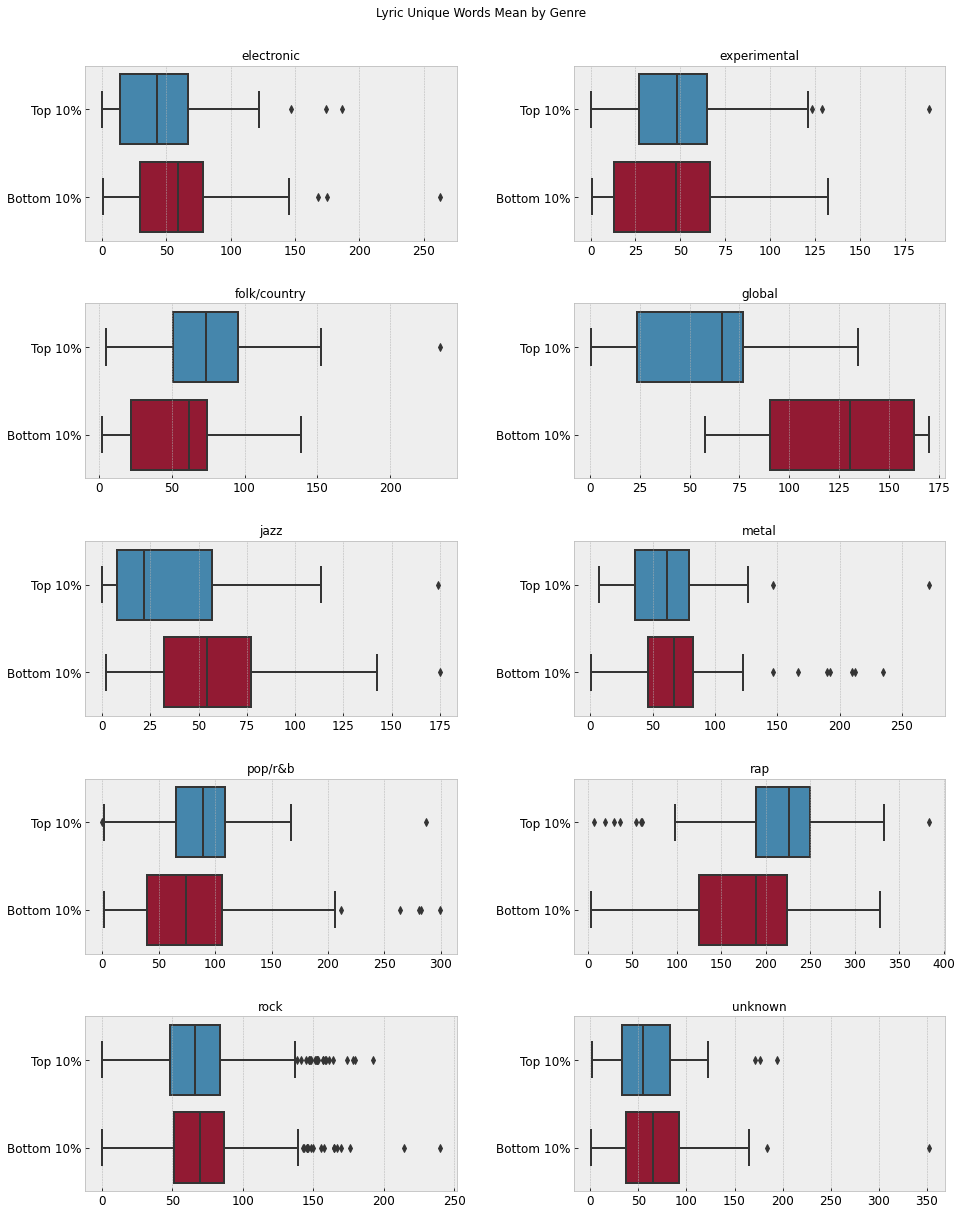

In [175]:
plot_numeric_grid('lyric_unique_words_mean', top_album_lyrics, bottom_album_lyrics, 'Lyric Unique Words Mean by Genre')

In [176]:
lyric_unique_words_mean_df = genre_comparison('lyric_unique_words_mean', top_album_lyrics, bottom_album_lyrics)
lyric_unique_words_mean_df

#### Variance

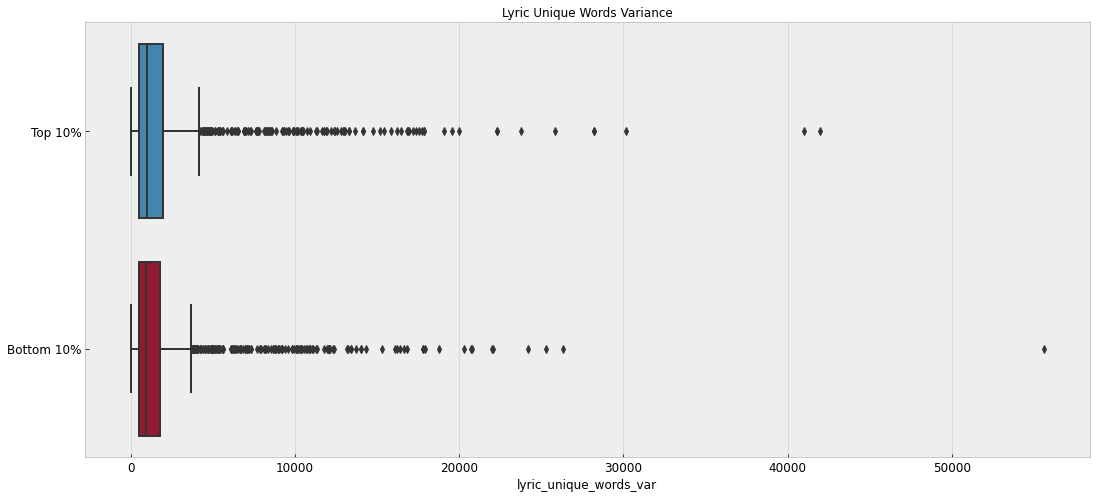

In [177]:
plot_numeric_col('lyric_unique_words_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Unique Words Variance')

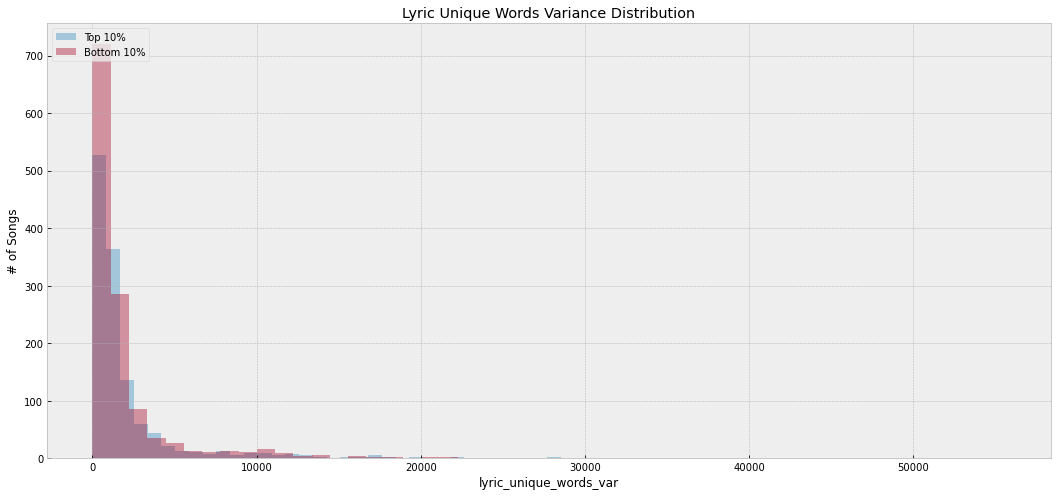

In [178]:
plot_histogram('lyric_unique_words_var', top_album_lyrics, bottom_album_lyrics, title='Lyric Unique Words Variance Distribution')

In [179]:
var_comparison('lyric_unique_words_var', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  763209.5
p-value:  0.044
Significant:  True
Common Language Effect Size:  0.48
Top 10% Median:  1008.2705442176871
Bottom 10% Median:  919.3636363636364
Number of Outliers (Top 10%):  30
Number of Outliers (Bottom 10%):  27


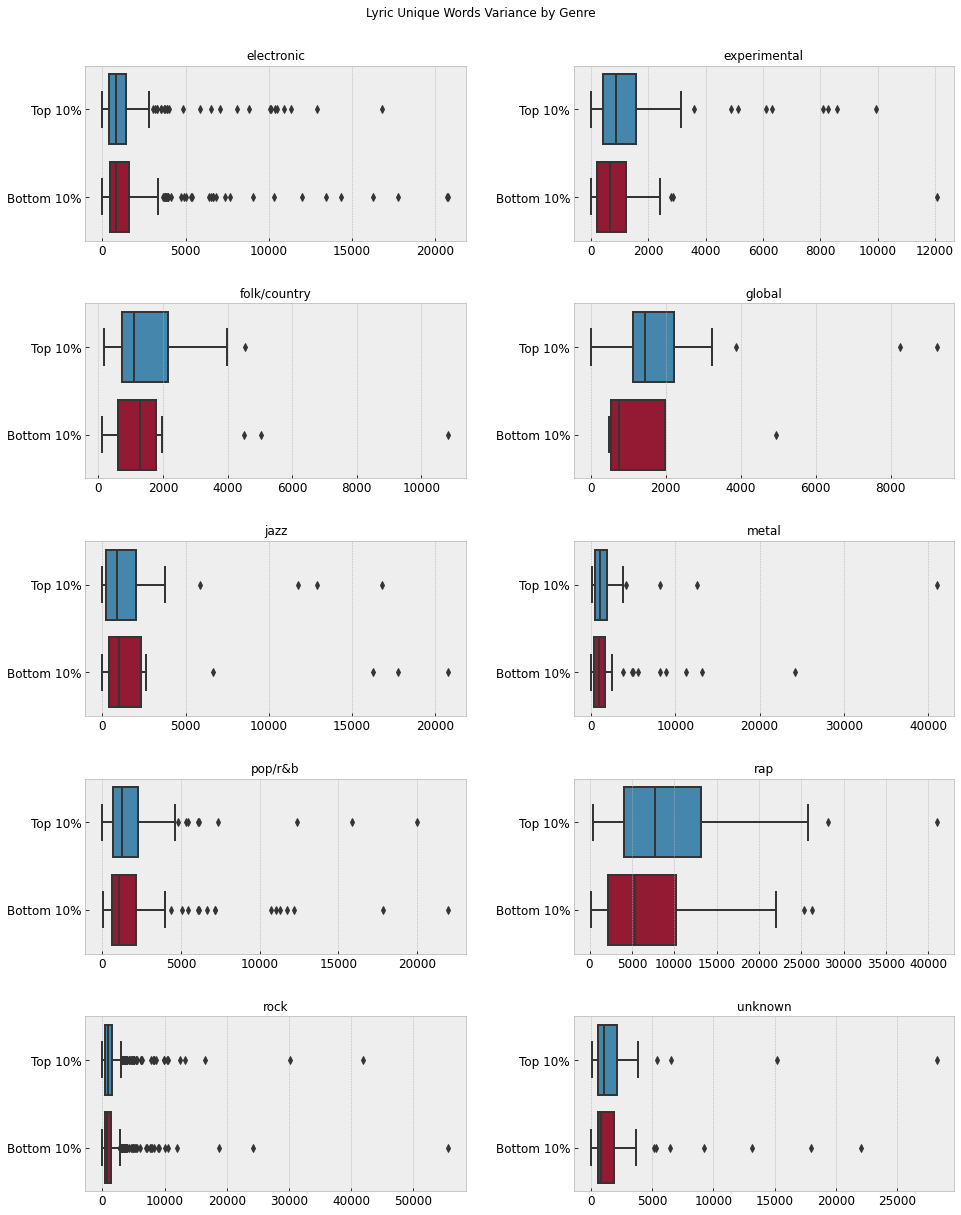

In [180]:
plot_numeric_grid('lyric_unique_words_var', top_album_lyrics, bottom_album_lyrics, 'Lyric Unique Words Variance by Genre')

In [181]:
lyric_unique_words_var_df = genre_comparison('lyric_unique_words_var', top_album_lyrics, bottom_album_lyrics)
lyric_unique_words_var_df

### Words Per Line
#### Mean

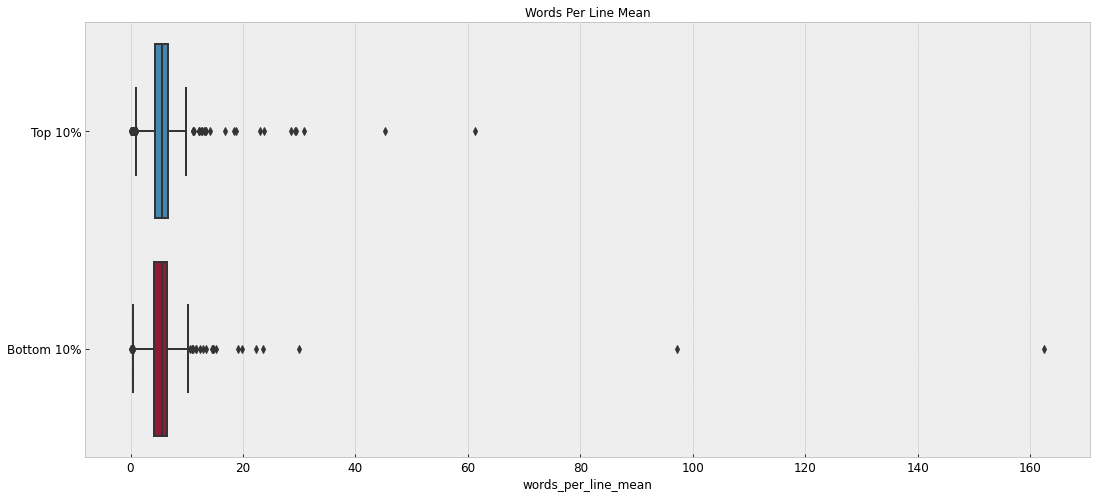

In [182]:
plot_numeric_col('words_per_line_mean', top_album_lyrics, bottom_album_lyrics, 'Words Per Line Mean')

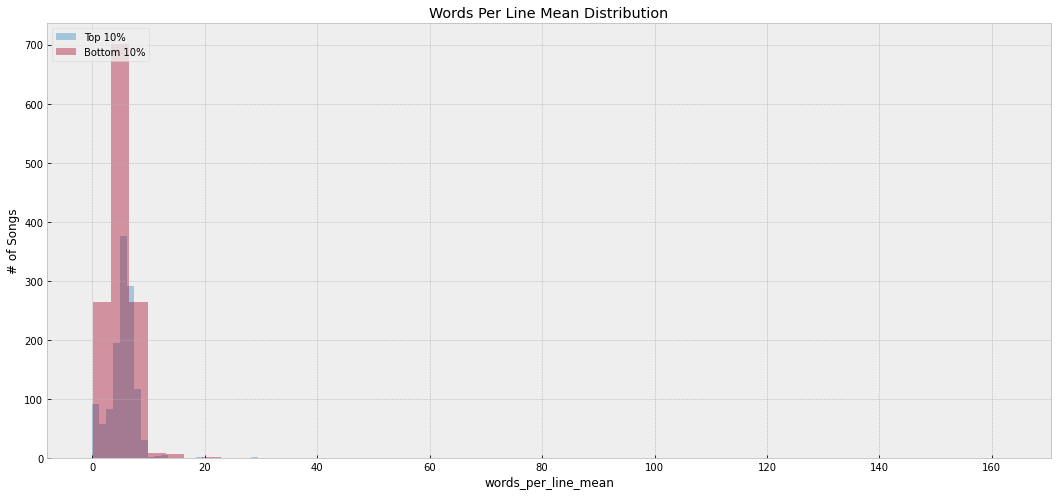

In [183]:
plot_histogram('words_per_line_mean', top_album_lyrics, bottom_album_lyrics, title='Words Per Line Mean Distribution')

In [184]:
var_comparison('words_per_line_mean', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  759181.0
p-value:  0.027
Significant:  True
Common Language Effect Size:  0.478
Top 10% Median:  5.68338814268532
Bottom 10% Median:  5.557631540700102
Number of Outliers (Top 10%):  11
Number of Outliers (Bottom 10%):  4


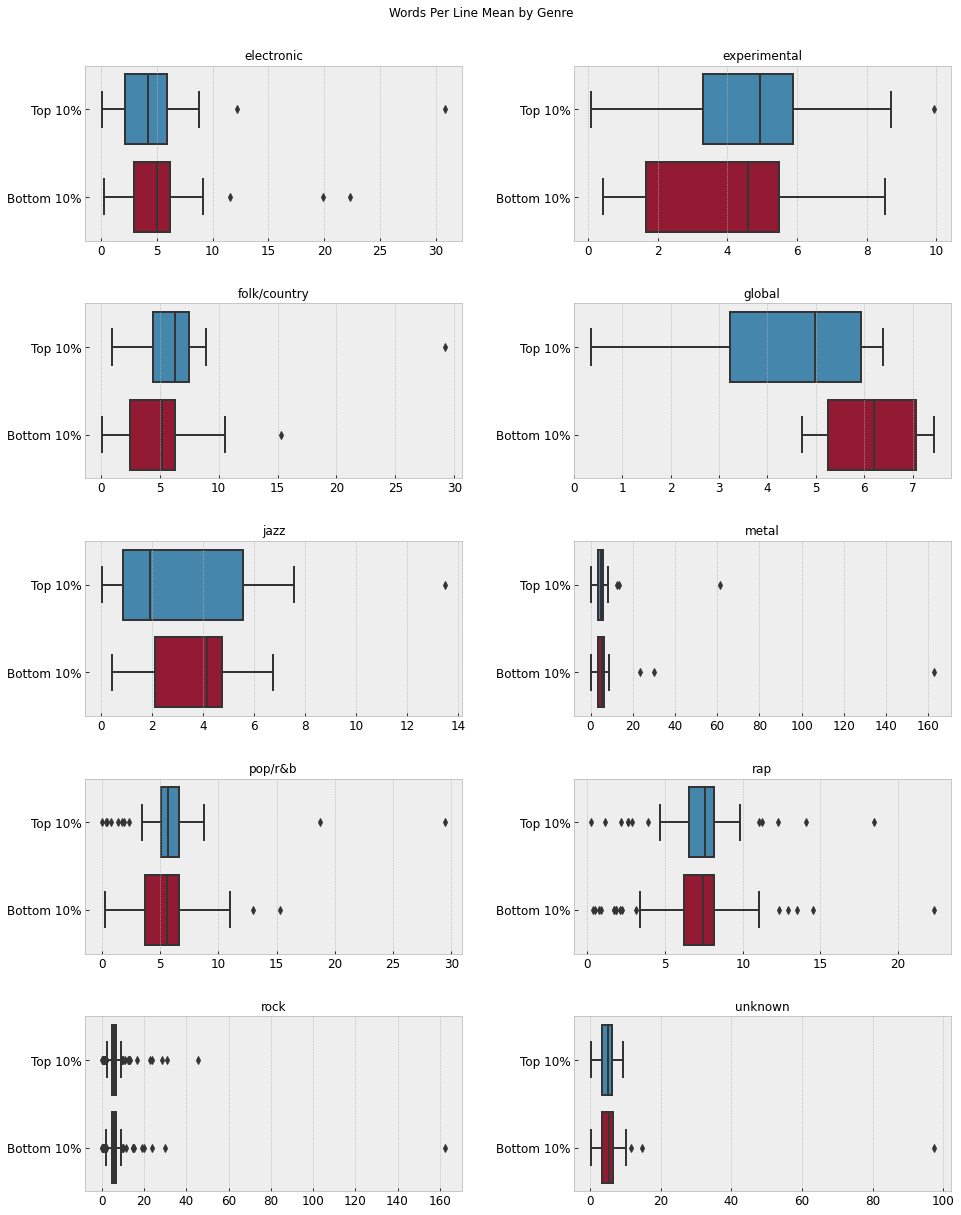

In [185]:
plot_numeric_grid('words_per_line_mean', top_album_lyrics, bottom_album_lyrics, 'Words Per Line Mean by Genre')

In [186]:
words_per_line_mean_df = genre_comparison('words_per_line_mean', top_album_lyrics, bottom_album_lyrics)
words_per_line_mean_df

#### Variance

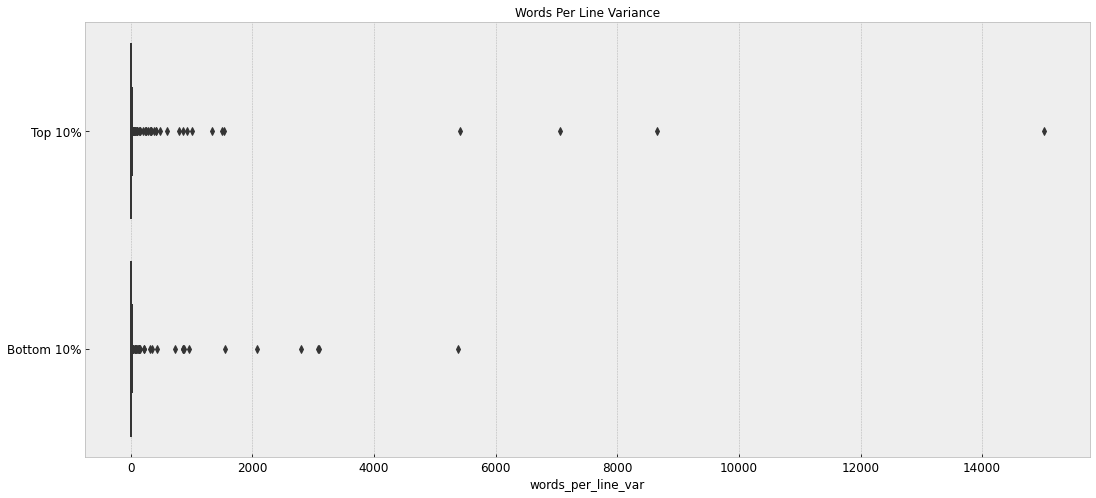

In [187]:
plot_numeric_col('words_per_line_var', top_album_lyrics, bottom_album_lyrics, 'Words Per Line Variance')

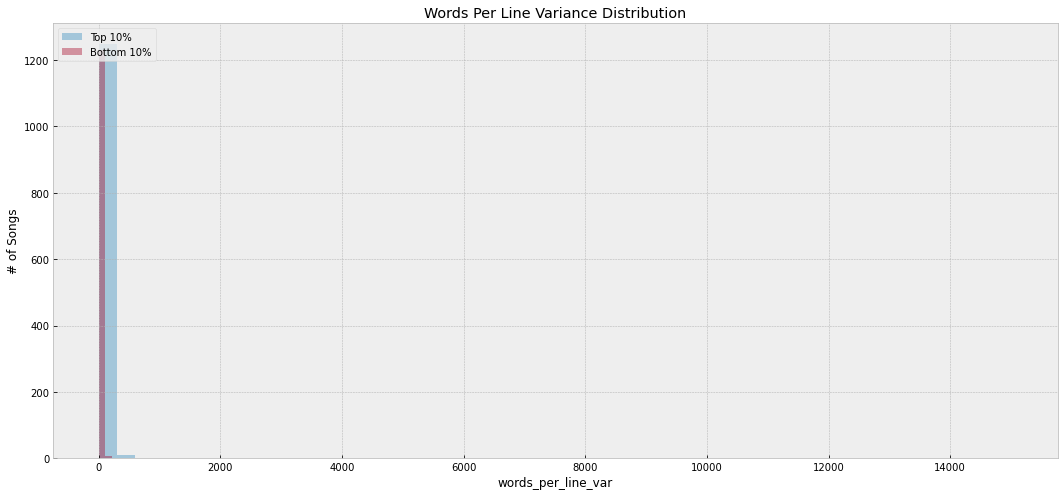

In [188]:
plot_histogram('words_per_line_var', top_album_lyrics, bottom_album_lyrics, title='Words Per Line Variance Distribution')

In [189]:
var_comparison('words_per_line_var', top_album_lyrics, bottom_album_lyrics)

N1 (Top 10%): 1268
N2 (Bottom 10%): 1253
U-value:  765813.0
p-value:  0.059
Significant:  False
Common Language Effect Size:  0.482
Top 10% Median:  4.134363186613792
Bottom 10% Median:  3.7821555561483047
Number of Outliers (Top 10%):  4
Number of Outliers (Bottom 10%):  11


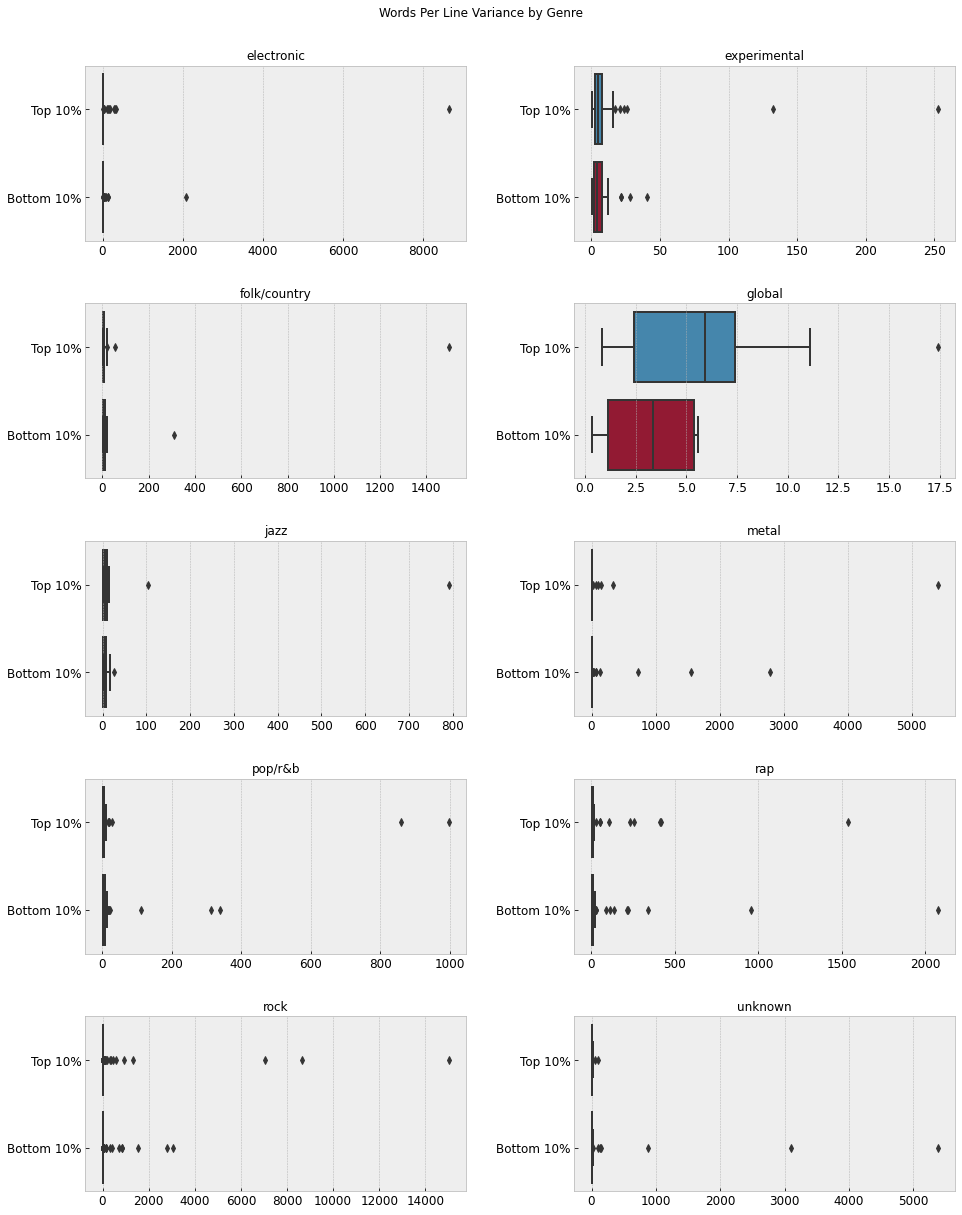

In [190]:
plot_numeric_grid('words_per_line_var', top_album_lyrics, bottom_album_lyrics, 'Words Per Line Variance by Genre')

In [191]:
words_per_line_var_df = genre_comparison('words_per_line_var', top_album_lyrics, bottom_album_lyrics)
words_per_line_var_df